# Detectron2 on COCO dataset

**Index**

1. [Background](#Background)
1. [Setup](#Setup)
1. [Training](#Training)
1. [Hyperparameter Tuning Jobs](#HPO)
1. [Deploy: Batch Transform or Real-Time Inference](#Deploy)
1. [Visualization](#Visualization)

## Background

Detectron2 is a Computer Vision framework which implements Object Detection algorithms. It is developed by Facebook AI Research team. While its ancestor, Detectron, was completely written in Caffe, Detecton2 was refactored in PyTorch to enable fast experiments and iterations from. Detectron2 has a rich model zoo that contains State-of-the-Art models for object detection, semantic segmentation and pose estimation, to cite a few. A modular design makes Detectron2 easily extensible, and, hence, cutting-edge research projects can be implemented on top of it. 

## Setup

#### Precondition
If you are executing this notebook using Sagemaker Notebook instance or Sagemaker Studio instance, please make sure that it has IAM role used with `AmazonSageMakerFullAccess` policy.

We start by importing required Python libraries and configuring some common parameters

In [2]:
import boto3
import sagemaker

assert (
    sagemaker.__version__.split(".")[0] == "2"
), "Please upgrade SageMaker Python SDK to version 2"

In [3]:
bucket = "photogauge-sagemaker-doors-detectron22"  # TODO: update this value
prefix_data = "detectron2/data"
prefix_model = "detectron2/training_artefacts"
prefix_code = "detectron2/model"
prefix_predictions = "detectron2/predictions"
local_folder = "cache"   # cache folder used to store downloaded data - not versioned


sm_session = sagemaker.Session(default_bucket=bucket)
role = sagemaker.get_execution_role()
region = sm_session.boto_region_name
account = sm_session.account_id()

# if bucket doesn't exist, create one
s3_resource = boto3.resource("s3")
if not s3_resource.Bucket(bucket) in s3_resource.buckets.all():
    s3_resource.create_bucket(
        Bucket=bucket, CreateBucketConfiguration={"LocationConstraint": region}
    )
print(role)

arn:aws:iam::592891983137:role/ML


## Training using Amazon SageMaker 

To run training job on SageMaker we will:
* build training container and push it to Amazon Elastic Container Registry ("ECR"), container includes all runtime dependencies and training script;
* define training job configuration which includes training cluster configuration and model hyperparameters;
* schedule training job, observe its progress.


### Building training container (No need to run these cells because Training container is already pushed to ECR)
Before we can build training container, we need to authethicate in shared ECR repo to retrieve Pytorch base image and in private ECR repository. Enter your region and account id below, and then execute the following cell to do it.

In [ ]:
%%bash

REGION='us-east-1'
ACCOUNT='592891983137'

aws ecr get-login-password --region $REGION | docker login --username AWS --password-stdin 763104351884.dkr.ecr.$REGION.amazonaws.com
# loging to your private ECR
aws ecr get-login-password --region $REGION | docker login --username AWS --password-stdin $ACCOUNT.dkr.ecr.$REGION.amazonaws.com

Our build container uses AWS-authored Pytorch container as a base image. We extend base image with Detecton2 dependencies and copy training script. Execute cell below to review Dockerfile content.

In [5]:
%%bash

# execute this cell to review Docker container
pygmentize -l docker Dockerfile.det2training

# Build an image of Detectron2 that can do distributing training on Amazon Sagemaker

# using Sagemaker PyTorch container as base image
# from https://github.com/aws/sagemaker-pytorch-container

ARG REGION
FROM 763104351884.dkr.ecr.$REGION.amazonaws.com/pytorch-training:1.6.0-gpu-py36-cu101-ubuntu16.04
LABEL author="pirrera@amazon.com"

############# Detectron2 pre-built binaries Pytorch default install ############
RUN pip install --upgrade torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

############# Detectron2 section ##############
RUN pip install \
   --no-cache-dir pycocotools~=2.0.0 \
   --no-cache-dir https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/detectron2-0.4%2Bcu101-cp36-cp36m-linux_x86_64.whl

ENV FORCE_CUDA="1"
# Build D2 only for Volta architecture - V100 chips (ml.p3 AWS instances)
# ENV TORCH_CUDA_ARCH_LIST="Volta"

# Set a fixed model cache directory. Detectron2 requirement
ENV FVCORE_CACHE="/tmp"

##

Next, we build the Docker container locally and then push it to ECR repository, so SageMaker can deploy this container on compute nodes at training time. Run command bellow to build and push container. The size of the resulting Docker image is approximately 5GB.

In [ ]:
%%bash
./build_and_push.sh sagemaker-d2-general latest Dockerfile.det2training

### Configure SageMaker training job

Configuration includes following components:
* data configuration defines where train/test/val datasets are stored;
* container configuration;
* model hyperparameters;
* training job parameters such as size of cluster and instance type, metrics to monitor, etc.

In [5]:
import json

import boto3
from sagemaker.estimator import Estimator

In [6]:
# Data configuration
# data_folder = "door-images"

training_channel = f"s3://{bucket}/{prefix_data}/training-images/"
validation_channel = f"s3://{bucket}/{prefix_data}/validation-images/"
test_channel = f"s3://{bucket}/{prefix_data}/test-images/"

annotation_channel = f"s3://{bucket}/{prefix_data}/annotations/"

classes = [
    "Door",
]

In [10]:
# Container configuration

container_name = "sagemaker-d2-general"
# container_version = "latest"
container_version = "latest"
training_image_uri = (
    f"{account}.dkr.ecr.{region}.amazonaws.com/{container_name}:{container_version}"
)
print(training_image_uri)

592891983137.dkr.ecr.us-east-1.amazonaws.com/sagemaker-d2-general:latest


In [11]:
# Metrics to monitor during training, each metric is scraped from container Stdout

metrics = [
    {"Name": "training:loss", "Regex": "total_loss: ([0-9\\.]+)",},
    {"Name": "training:loss_cls", "Regex": "loss_cls: ([0-9\\.]+)",},
    
    {"Name": "training:loss_keypoint", "Regex": "loss_keypoint: ([0-9\\.]+)",},
    {"Name": "training:loss_mask", "Regex": "loss_mask: ([0-9\\.]+)",},
    
    {"Name": "training:loss_box_reg", "Regex": "loss_box_reg: ([0-9\\.]+)",},
    {"Name": "training:loss_rpn_cls", "Regex": "loss_rpn_cls: ([0-9\\.]+)",},
    {"Name": "training:loss_rpn_loc", "Regex": "loss_rpn_loc: ([0-9\\.]+)",},
    {"Name": "validation:loss", "Regex": "total_val_loss: ([0-9\\.]+)",},
    {"Name": "validation:loss_cls", "Regex": "val_loss_cls: ([0-9\\.]+)",},
    
    {"Name": "validation:loss_keypoint", "Regex": "val_loss_keypoint: ([0-9\\.]+)",},
    {"Name": "validation:loss_mask", "Regex": "val_loss_mask: ([0-9\\.]+)",},
    
    {"Name": "validation:loss_box_reg", "Regex": "val_loss_box_reg: ([0-9\\.]+)",},
    {"Name": "validation:loss_rpn_cls", "Regex": "val_loss_rpn_cls: ([0-9\\.]+)",},
    {"Name": "validation:loss_rpn_loc", "Regex": "val_loss_rpn_loc: ([0-9\\.]+)",},
]

In [12]:
# Training instance type

# training_instance = "ml.p3.8xlarge"
training_instance = "ml.p3.2xlarge"
if training_instance.startswith("local"):
    training_session = sagemaker.LocalSession()
    training_session.config = {"local": {"local_code": True}}
else:
    training_session = sm_session

The following hyper-parameters are used in the training job. Feel free to change them and experiment.

In [18]:
# steps where epochs completes
total_images =  838
batch_size = 4
steps = 6000
epochs = []
for i in range(0, steps, int(total_images/batch_size)):
    epochs.append(i)
print(epochs)
print(len(epochs))

[0, 209, 418, 627, 836, 1045, 1254, 1463, 1672, 1881, 2090, 2299, 2508, 2717, 2926, 3135, 3344, 3553, 3762, 3971, 4180, 4389, 4598, 4807]
24


In [20]:
# Model Hyperparameters

od_algorithm = "keypoint_rcnn"  # choose one in ("faster_rcnn", "retinanet", "mask_rcnn", "keypoint_rcnn")
training_job_hp = {
    # Dataset
    "classes": json.dumps(classes),
    "dataset-name": json.dumps("door-images"),
    "label-name": json.dumps("Door"),
    # Algo specs
    "model-type": json.dumps(od_algorithm),
    "backbone": json.dumps("R_50_FPN"),
    # Data loader
    "num-iter": 6000,
    "log-period": 100,
    "batch-size": 4,
    "checkpoint-period": 1500,
#     "batch-size": 16,
    "num-workers": 8,
    # Optimization
    "lr": 0.005,
    "momentum": 0.9,
    "weight-decay": 0.0001,
    "lr-schedule": 3,
    # Faster-RCNN specific
#     "num-rpn": 517,
    "bbox-head-pos-fraction": 0.2,
    "bbox-rpn-pos-fraction": 0.4,
    # Keypoint Specific
    "num-keypoints": 4,
    "keypoint-names": json.dumps(['top_left', 'top_right', 'bottom_left', 'bottom_right']),
    "keypoint-flip-map": json.dumps([('top_left', 'top_right'), ('top_left', 'bottom_left'), ('top_right', 'bottom_right'),('bottom_left', 'bottom_right')]),
    # Prediction specific
    "nms-thr": 0.2,
    "pred-thr": 0.1,
    "det-per-img": 100,
    # Evaluation
    "evaluation-type": "coco",
    "opts": json.dumps(["SOLVER.GAMMA", 0.005])
}

In [21]:
print(training_channel)
print(annotation_channel)
print(training_image_uri)
import numpy as np
len(np.ones((4, 1), dtype=float).tolist())

s3://photogauge-sagemaker-doors-detectron22/detectron2/data/door-images/
s3://photogauge-sagemaker-doors-detectron22/detectron2/data/annotations/
592891983137.dkr.ecr.us-east-1.amazonaws.com/sagemaker-d2-general:latest


4

In [22]:
# Compile Sagemaker Training job object and start training

d2_estimator = Estimator(
    image_uri=training_image_uri,
    role=role,
    sagemaker_session=training_session,
    instance_count=1,
    instance_type=training_instance,
    hyperparameters=training_job_hp,
    metric_definitions=metrics,
    output_path=f"s3://{bucket}/{prefix_model}",
    base_job_name=f"detectron2-{od_algorithm.replace('_', '-')}",
)

d2_estimator.fit(
    {
        "training": training_channel,
        "validation": validation_channel,
        "test": test_channel,
        "annotation": annotation_channel,
    },
    wait=False,
)

## HyperParameter Optimization with Amazon SageMaker

SageMaker SDK comes with the `tuner` module that can be used to search for the optimal hyper-parameters (see more details [here](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)). Let's run several experiment with different model hyperparameters with aim to minize the validation loss. 

`hparams_range` dictionary that defines the hyper-parameters to be optimized. Feel free to modify it. ⚠️ Please note, a tuning job runs multiple training job. Therefore, be aware of the amount of computational resources that a tuner job requires.

In [40]:
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)

od_algorithm = "keypoint_rcnn"  # choose one in ("faster_rcnn", "retinanet", "mask_rcnn", "keypoint_rcnn")

In [43]:
hparams_range = {
    "lr": ContinuousParameter(0.0005, 0.01, scaling_type = "Logarithmic"),
#      dont bother, changing momentum and weight decay is making loss go higher and something infinity.
    "momentum": ContinuousParameter(0.8, 0.9),
    "weight-decay": ContinuousParameter(0.0001, 0.001)
}
if od_algorithm == "faster_rcnn" or od_algorithm == "keypoint_rcnn" or od_algorithm == "mask_rcnn":
    hparams_range.update(
        {
            "bbox-rpn-pos-fraction": ContinuousParameter(0.1, 0.5),
            "bbox-head-pos-fraction": ContinuousParameter(0.1, 0.5),
        }
    )
elif od_algorithm == "retinanet":
    hparams_range.update(
        {
            "focal-loss-gamma": ContinuousParameter(2.5, 5.0),
            "focal-loss-alpha": ContinuousParameter(0.3, 1.0),
        }
    )
else:
    assert False, f"{od_algorithm} not supported"
hparams_range

{'lr': <sagemaker.parameter.ContinuousParameter at 0x7fa24017a810>,
 'momentum': <sagemaker.parameter.ContinuousParameter at 0x7fa24017a850>,
 'weight-decay': <sagemaker.parameter.ContinuousParameter at 0x7fa24017a890>,
 'bbox-rpn-pos-fraction': <sagemaker.parameter.ContinuousParameter at 0x7fa24017a7d0>,
 'bbox-head-pos-fraction': <sagemaker.parameter.ContinuousParameter at 0x7fa24017a950>}

In [42]:
obj_metric_name = "validation:loss_keypoint"
obj_type = "Minimize"
metric_definitions = [
    {"Name": "training:loss", "Regex": "total_loss: ([0-9\\.]+)",},
    {"Name": "training:loss_cls", "Regex": "loss_cls: ([0-9\\.]+)",},
    {"Name": "training:loss_box_reg", "Regex": "loss_box_reg: ([0-9\\.]+)",},
    {"Name": "training:loss_keypoint", "Regex": "loss_keypoint: ([0-9\\.]+)",},
#    {"Name": "training:loss_mask", "Regex": "loss_mask: ([0-9\\.]+)",},
    
    
    {"Name": "validation:loss", "Regex": "total_val_loss: ([0-9\\.]+)",},
    {"Name": "validation:loss_cls", "Regex": "val_loss_cls: ([0-9\\.]+)",},
    {"Name": "validation:loss_box_reg", "Regex": "val_loss_box_reg: ([0-9\\.]+)",},
    {"Name": obj_metric_name, "Regex": "val_loss_keypoint: ([0-9\\.]+)",},
#    {"Name": "validation:loss_mask", "Regex": "val_loss_mask: ([0-9\\.]+)",},
]
metric_definitions

[{'Name': 'training:loss', 'Regex': 'total_loss: ([0-9\\.]+)'},
 {'Name': 'training:loss_cls', 'Regex': 'loss_cls: ([0-9\\.]+)'},
 {'Name': 'training:loss_box_reg', 'Regex': 'loss_box_reg: ([0-9\\.]+)'},
 {'Name': 'training:loss_keypoint', 'Regex': 'loss_keypoint: ([0-9\\.]+)'},
 {'Name': 'validation:loss', 'Regex': 'total_val_loss: ([0-9\\.]+)'},
 {'Name': 'validation:loss_cls', 'Regex': 'val_loss_cls: ([0-9\\.]+)'},
 {'Name': 'validation:loss_box_reg', 'Regex': 'val_loss_box_reg: ([0-9\\.]+)'},
 {'Name': 'validation:loss_keypoint',
  'Regex': 'val_loss_keypoint: ([0-9\\.]+)'}]

In [44]:
fixed_hparams = {
    # Dataset
    "classes": json.dumps(classes),
    "dataset-name": json.dumps("door-images"),
    "label-name": json.dumps("Door"),
    # Algo specs
    "model-type": json.dumps(od_algorithm),
    "backbone": json.dumps("R_50_FPN"),
    # Data loader
    "num-iter": 6000,
    "log-period": 100,
    "batch-size": 4,
    "num-workers": 8,
    "checkpoint-period": 1500,
    # Optimization
    "lr-schedule": 3,
#     "momentum": 0.9,
#     "weight-decay": 0.0001,
    # Keypoint Speciifc
    "num-keypoints": 4,
    "keypoint-names": json.dumps(['top_left', 'top_right', 'bottom_left', 'bottom_right']),
    "keypoint-flip-map": json.dumps([('top_left', 'top_right'), ('top_left', 'bottom_left'), ('top_right', 'bottom_right'),('bottom_left', 'bottom_right')]),
    # Prediction specific
    "nms-thr": 0.2,
    "pred-thr": 0.1,
    "det-per-img": 100,
    # Evaluation
    "evaluation-type": "coco",
}

hpo_estimator = Estimator(
    image_uri=training_image_uri,
    role=role,
    sagemaker_session=sm_session,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    hyperparameters=fixed_hparams,
    output_path=f"s3://{bucket}/{prefix_model}",
#     use_spot_instances=True,  # Use spot instances to spare a
#     max_run=2 * 60 * 60,
#     max_wait=3 * 60 * 60,
)
fixed_hparams

{'classes': '["Door"]',
 'dataset-name': '"door-images"',
 'label-name': '"Door"',
 'model-type': '"keypoint_rcnn"',
 'backbone': '"R_50_FPN"',
 'num-iter': 6000,
 'log-period': 100,
 'batch-size': 4,
 'num-workers': 8,
 'checkpoint-period': 1500,
 'lr-schedule': 3,
 'num-keypoints': 4,
 'keypoint-names': '["top_left", "top_right", "bottom_left", "bottom_right"]',
 'keypoint-flip-map': '[["top_left", "top_right"], ["top_left", "bottom_left"], ["top_right", "bottom_right"], ["bottom_left", "bottom_right"]]',
 'nms-thr': 0.2,
 'pred-thr': 0.1,
 'det-per-img': 100,
 'evaluation-type': 'coco'}

In [45]:
tuner = HyperparameterTuner(
    hpo_estimator,
    obj_metric_name,
    hparams_range,
    metric_definitions,
    objective_type=obj_type,
    max_jobs=20,
    max_parallel_jobs=1,
    base_tuning_job_name=f"hpo-d2-{od_algorithm.replace('_', '-')}",
)

In [46]:
tuner.fit(
    inputs={
        "training": training_channel,
        "validation": validation_channel,
        "test": test_channel,
        "annotation": annotation_channel,
    },
    wait=False,
)

In [ ]:
# Let's review outcomes of HyperParameter search

hpo_tuning_job_name = tuner.latest_tuning_job.name
bayes_metrics = sagemaker.HyperparameterTuningJobAnalytics(
    hpo_tuning_job_name
).dataframe()
bayes_metrics.sort_values(["FinalObjectiveValue"], ascending=True)

## Model Deployment on Amazon SageMaker

Just like with model training, SageMaker is using containers to run inference. Hence, we start by preparing serving container which will be then deployed with on Amazon SageMaker Hosting platform.

### Pushing Inference Container for Detectron2 (No need to run these cells because Inference container is already pushed to ECR)

In [23]:
%%bash

# execute this cell to review Docker container
pygmentize -l docker Dockerfile.det2serving

# Build an image of Detectron2 with Sagemaker Multi Model Server: https://github.com/awslabs/multi-model-server

# using Sagemaker PyTorch container as base image
# from https://github.com/aws/sagemaker-pytorch-serving-container/

ARG REGION
FROM 763104351884.dkr.ecr.$REGION.amazonaws.com/pytorch-inference:1.5.1-gpu-py36-cu101-ubuntu16.04
LABEL author="pirrera@amazon.com"

############# Installing latest builds ############
RUN pip install --upgrade torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# ENV FORCE_CUDA="1"
# Build D2 only for Turing (G4) and Volta (P3) architectures. Use P3 for batch transforms and G4 for inference on endpoints
# ENV TORCH_CUDA_ARCH_LIST="Turing;Volta"

# Install Detectron2
RUN pip install \
   --no-cache-dir pycocotools~=2.0.0 \
   --no-cache-dir https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/detectron2-0.4%2Bcu101-cp36-cp36m-linux_x86_64.whl

# Set a fixed model cache directory. Detectron2

Run cell below to build the Docker container defined in the image `Dockerfile.det2serving` and push it to ECR. The size of the resulting Docker image is approximately 5GB.

In [ ]:
%%bash

./build_and_push.sh sagemaker-d2-serve sahi Dockerfile.det2serving

We will run batch inference, i.e. running inference against large chunk of images. We use [SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html) to do it. 

In [7]:
from sagemaker.pytorch import PyTorchModel

Here we assume that a HPO job was executed. We attach the tuning job and fetch the best model

In [7]:
# from sagemaker.tuner import HyperparameterTuner

# tuning_job_id = "hpo-d2-keypoint-rcnn-220104-1226"
# attached_tuner = HyperparameterTuner.attach(tuning_job_id)

# best_estimator = attached_tuner.best_estimator()

# best_estimator.latest_training_job.describe()
# training_job_artifact = best_estimator.latest_training_job.describe()["ModelArtifacts"][
#     "S3ModelArtifacts"
# ]
# training_job_artifact


2022-01-04 20:40:03 Starting - Preparing the instances for training
2022-01-04 20:40:03 Downloading - Downloading input data
2022-01-04 20:40:03 Training - Training image download completed. Training in progress.
2022-01-04 20:40:03 Uploading - Uploading generated training model
2022-01-04 20:40:03 Completed - Training job completed


's3://photogauge-sagemaker-doors-detectron/detectron2/training_artefacts/hpo-d2-keypoint-rcnn-220104-1226-010-93aea8df/output/model.tar.gz'

You can also specify the S3 URI of model artifact. Uncomment the following code if you want to use this option:

In [8]:
training_job_artifact = "s3://photogauge-sagemaker-doors-detectron22/detectron2/training_artefacts/detectron2-keypoint-rcnn-2022-01-10-09-40-20-425/output/model.tar.gz"

In [9]:
# Define parameters of inference container
from pathlib import Path
serve_container_name = "sagemaker-d2-serve"
serve_container_version = "sahi"
serve_image_uri = f"{account}.dkr.ecr.{region}.amazonaws.com/{serve_container_name}:{serve_container_version}"

# inference_output = f"s3://{bucket}/{prefix_predictions}/{serve_container_name}/{Path(test_channel).name}_channel/{training_job_artifact.split('/')[-3]}/"
# inference_output = "s3://prod-photogauge-company-accounts/d1d09436-2d03-43e6-933f-5b2b7f0fae33/ee399e63-b823-4449-90d9-508ca676fc10/e63b2eac-f081-4d60-b4c9-89f1b8a53046/units/Door_scan_03-01-2022-13-55-45/photos/pib-tkaogfex/predictions/"
# inference_output

In [20]:
# Compile SageMaker model object and configure Batch Transform job

model = PyTorchModel(
    name="d2-door-model-cm--1",
    model_data=training_job_artifact,
    role=role,
    sagemaker_session=sm_session,
    entry_point="predict_det2.py",
    source_dir="container_serving",
    image_uri=serve_image_uri,
    framework_version="1.6.0",
    code_location=f"s3://{bucket}/{prefix_code}",
    env = {
        "MODEL_NAME":"-1",
        "CONFIDENCE_THRESHOLD":"0.5"
    }
)


### Register a Model - When you just need to create the model and not deploy it or perform inference yet
Already deployed models can be reused to include differenct checkpoints without having to create container definitions. In `"ENVIRONMENT"`, `"MODEL_NAME"` would need changing to appropriate index. It will create a copy of the same model if it already exists and consumes extra S3 storage.

In [35]:
print(role)

arn:aws:iam::592891983137:role/ML


In [28]:
model_dict = model.prepare_container_def()
model_dict

{'Image': '592891983137.dkr.ecr.us-east-1.amazonaws.com/sagemaker-d2-serve:latest',
 'Environment': {'MODEL_NAME': '-1',
  'SAGEMAKER_PROGRAM': 'predict_det2.py',
  'SAGEMAKER_SUBMIT_DIRECTORY': 's3://photogauge-sagemaker-doors-detectron22/detectron2/model/d2-door-model-cm--1/model.tar.gz',
  'SAGEMAKER_CONTAINER_LOG_LEVEL': '20',
  'SAGEMAKER_REGION': 'us-east-1'},
 'ModelDataUrl': 's3://photogauge-sagemaker-doors-detectron22/detectron2/model/d2-door-model-cm--1/model.tar.gz'}

In [27]:

client = boto3.client('sagemaker')

create_model = client.create_model(
    ModelName=model_dict['ModelDataUrl'].split('/')[-2],
    PrimaryContainer={
        'ContainerHostname': 'd2-serve-container',
        'Image': model_dict['Image'],
#         'ImageConfig': {
#             'RepositoryAccessMode': 'Platform',
#             'RepositoryAuthConfig': {
#                 'RepositoryCredentialsProviderArn': 'string'
#             }
#         },
#         'Mode': 'SingleModel'|'MultiModel',
        'ModelDataUrl': model_dict['ModelDataUrl'],
        'Environment': model_dict['Environment'],
        
    },
    ExecutionRoleArn= role
)

In [5]:

client = boto3.client('sagemaker')

create_model = client.create_model(
    ModelName='pipe-model-sahi-container',
    PrimaryContainer={
        'ContainerHostname': 'd2-serve-container',
        'Image': '592891983137.dkr.ecr.us-east-1.amazonaws.com/sagemaker-d2-serve:sahi',
#         'ImageConfig': {
#             'RepositoryAccessMode': 'Platform',
#             'RepositoryAuthConfig': {
#                 'RepositoryCredentialsProviderArn': 'string'
#             }
#         },
#         'Mode': 'SingleModel'|'MultiModel',
        'ModelDataUrl': 's3://photogauge-sagemaker-pipes/detectron2/model/Detectron2Model-2022-05-12-10-11-01/model.tar.gz',
        'Environment': {
                'MODEL_NAME': '-1',
                'SAGEMAKER_PROGRAM': 'predict_det2.py',
                'SAGEMAKER_SUBMIT_DIRECTORY': 's3://photogauge-sagemaker-pipes/detectron2/model/Detectron2Model-2022-05-12-10-11-01/model.tar.gz',
                'SAGEMAKER_CONTAINER_LOG_LEVEL': '20',
                'SAGEMAKER_REGION': 'us-east-1',
                "CONFIDENCE_THRESHOLD":"0.5"
                },
        
    },
    ExecutionRoleArn= role
)

### Batch Transform using the Above Model with SageMaker SDK
We can use this when creating a new model after a training job or even with existing model

In [29]:
batch_inference_channel = "s3://prod-photogauge-company-accounts/d1d09436-2d03-43e6-933f-5b2b7f0fae33/ee399e63-b823-4449-90d9-508ca676fc10/e63b2eac-f081-4d60-b4c9-89f1b8a53046/units/Door_scan_03-01-2022-13-55-45/photos/pib-tkaogfex/Auto1/"

transformer = model.transformer(
    instance_count=1,
    instance_type="ml.g4dn.xlarge",  # "ml.p2.xlarge", #
    output_path=inference_output,
    max_payload=16,
)

# Start Batch Transform job

transformer.transform(
    data=batch_inference_channel,
    data_type="S3Prefix",
    content_type="application/x-image",
    wait=False,
)

### Batch Transform using Above Model with Boto3
This can be used with existing models on sagemaker console

In [32]:
client = boto3.client('sagemaker')
transform_input = "s3://prod-photogauge-company-accounts/d1d09436-2d03-43e6-933f-5b2b7f0fae33/ee399e63-b823-4449-90d9-508ca676fc10/e63b2eac-f081-4d60-b4c9-89f1b8a53046/units/Door_scan_03-01-2022-13-55-45/photos/pib-tkaogfex/Auto1/"
transform_output = "s3://prod-photogauge-company-accounts/d1d09436-2d03-43e6-933f-5b2b7f0fae33/ee399e63-b823-4449-90d9-508ca676fc10/e63b2eac-f081-4d60-b4c9-89f1b8a53046/units/Door_scan_03-01-2022-13-55-45/photos/pib-tkaogfex/predictions/"

create_batch = client.create_transform_job(
    TransformJobName="boto-transform-test-job",
    ModelName="d2-door-model-cm-2",
    MaxConcurrentTransforms=0,
    MaxPayloadInMB=50,
#     BatchStrategy='MultiRecord',
    TransformInput={
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': transform_input
            }
        },
        'ContentType': 'application/x-image',
        'CompressionType': 'None',
#         'SplitType': 'Line'
    },
    TransformOutput={
        'S3OutputPath': transform_output,
        'AssembleWith': 'Line'
    },
    TransformResources={
        'InstanceType': 'ml.p2.xlarge',
        'InstanceCount': 1
    }
    )

### Deploy the above Model to an endpoint for real time inference

In [ ]:
pred_model = model.deploy(
    initial_instance_count = 1,
    instance_type = 'ml.inf1.xlarge',
    endpoint_name = 'door-endpoint-atest',
    update_endpoint = True,
    wait = False
)

### Test the deployed endpoint for inference

In [27]:
from sagemaker.predictor import Predictor

prediction_model = Predictor(
    endpoint_name = 'door-endpoint-atest',
    sagemaker_session = sm_session
)

In [23]:
# update endpoint
prediction_model.update_endpoint(
    initial_instance_count = 1,
    instance_type = 'ml.inf1.xlarge',
    model_name = "d2-door-model-hpo-3-19-2-1",
    wait = False,
)

In [28]:
img_str= "/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAYGBgYHBgcICAcKCwoLCg8ODAwODxYQERAREBYiFRkVFRkVIh4kHhweJB42KiYmKjY+NDI0PkxERExfWl98fKcBBgYGBgcGBwgIBwoLCgsKDw4MDA4PFhAREBEQFiIVGRUVGRUiHiQeHB4kHjYqJiYqNj40MjQ+TERETF9aX3x8p//CABEIBkAEsAMBIgACEQEDEQH/xAAxAAEBAQEBAQEAAAAAAAAAAAAAAQIDBAUGAQEBAQEBAQAAAAAAAAAAAAAAAQIDBAX/2gAMAwEAAhADEAAAAvtiAAAAAAAQAUAigAAAAAAAAUgAAAAAAAAAAAAAAAAAAAAAAIsEsAICSiCIAAFoAAFABx7cDIAFlAoBZQAAAAAAACUBD1gAAAFIoikiiKAAAAAAACiKJQAAAAAASiAAAAAAAAAAAAAAAAAASiSwAiwiwgiLAUABQCgBQefv5yIKBZQKAWUAAAAAAAAAgPWAAAoABAAAAAAAACiUAAAAAAAAAAAEsAAAAAAAAACwAFAAEsABACASwSwSwCAAFFAAFAJ5/R5iAoFgooCgAAAAAAAAAA9QQVZQAABAAAAAABQAAAAAAAAAAAAAACKIsAAAAACgBKJQAAAAiwSiAgAICAiyACgAFFAAM+f0eYAoAqgFAAAAAAAAAAAPVRAAUAEAAAAFIoiiUAAAAAAACiKIoiwAAAAAAAAiiKJQAAAAAAAA5+TVO3Xy+ogIABLBLAAIAFIoBQAMeftwKCihQAUAAAAAAAAAAA9YQAAAAAAUigAAAAUigAAAAAAAAABKIoiiAAAAAAAAALAAAABz6fHJ08Oj6nr+P9cqQrGTq4ZPTPLk9k8MX3vnZj6c+XD6c+aPoz58PfnxD158w754jpMDv149TVlKKAoFlAAAAAFlEUgAAAPWEAAAAKIoAAAAAWUAAAAAAAAAAAAAAASiKIAQrOTo45PQ82T1vFD3X52V+nPmQ+pPlQ+rPlE+nn50PoZ8I9HyN9DsZKzg7yFoAAAAgAzk6OOT0TzZX1vFg98+cPo353uPT15dU1ZRZaAoFAAAAAAUlAABFID1hAABSUAAAAAABQAAoiiLAQtxk6uOT0PNk9bx5PdPBD6F+blfpz5Y+nPmQ+nn5w988I9mfKPTngOucUuaIoy0MtDNoiiSiLAzzO04w78Wjyezw5PfnwZPROG7PU8XOX6OfCPZnyl9GeEPRnlDrOY1Mi2UKJNjKjDWR7vF9A9vXn0k1YNCgLZQAAAAAAUAAASiLD1hBSUAAAAAABTM8XBfp5+aPo58A908Q9efMPRONNzIsABKItMtCKIoiiJDTMNuEX0vHo9Tx5PdPn8o+o+Pa+xn5eT6ufmU+jfmD63n8EPdx85e14I7YypnVTN69z1fI9njTlNZWAvbj708/H7XyKiJagsAAUSgUWAQKJAz9T5f1z0dMbk1ZaoFlFlAAAAAAChLBZQAAQ9ZUAAAAAAAKJQ8Hn9XlWFJN+Y7vLiX2vDK+hfnYj6j5GT7M+PD7E+OPr5+WX6c+aPpY8FPXnyj3Y8g755DcyNTI0yNMjTI0yNSCoKgqCoKgqCoL934P0rPR4MYufqdPmaM+Htymo1Tn9TwbT7PwfrfOs4PVqa8d9uz576nywyNs0ltOboObqOU6w59fP2N3EL9b5X1TvvHRLZSgUKAAAAACpQBAWCgASj1hAAAAABSUAAPJ4/d4ViyM/K+l8tUFhSUOnX3dT4ufseA81VYtMqAEUiiKgKALEIKkNMDbEOs5w6uI7OQ6zmOsxSlMzpTnOo4u1rj9Df2mfl9fsWz5W/pVPnb9o8t9A43oMNKx8n6/lj53zP0f5yaspZQSgCY3g5dOfQudQfV+T9g9G8bS2UoKCgWUiwAAUAAIABQAA9YQAAAABQAAA4fP+l85ZKjj8v6vylgUmTo5U+r6/h6T6Xj4FOUOrkXrMw0Uxdjm6ji7jjPQPO9BPPe44uw53oOWtjGrTLQi0y0IoiiKMtDLSs20/Q+3y+S4+pPhZT72fgw+7j4kPs4+VzX6+Pkw+px8HM+n9D87983+Z/R/ml2llAAAc+nIzvOyTWSfb+N9o6bxtNApQCgWUSwAAqUAASwFAACU9YQAoiiKAAAAAMfM+r8pYIz8f7XyV5IXOs9CalX6Pt8XuZ4eb08D5ymk1ABQAAKIolUigAAVBQBKACqiiUIsBSKPuc/m6ufLjQxOlOP0PJo+3+d+58FK7F5TtmMe3ylRSAUABBx7cRvPQzneTX2fj/ZN6zpNWUoAKCgSiAAqUAAgFAAAD1qQAAAAAAAUAfJ+t8teaonzPqfNXyKa59eXVFF930/k/WmfNz3D5RbqUBSKJQAAUJQFIolAUBBSFAoAAAAQAABEok1TzdtCKMrkssIAAohSAcO/nOms6EsOn1vl/UN6lTVlKAClAAIACgAAAAAAA9gQAAAAAAUAAfO+j4F84h8/wCh4V8KxrHTn0KD0/Y+L9qTy22z4yxqqJQAAWUAAWUAlUigEUAABalUgAIsBSKEojRMtDNtMzcMN5MzUE1gAlAAogJ5/R5jtaJKO30/m/TN6zpLZSgWUWUAAgAKAAQoAAAAPYEAAAAAAUAAHj9nlPEJXl9XnX5axqLE6Bd/c+D96Tm0s+HLGtAAFIoFIoigUAAJRZUAJQKFFxk6zNNFIogBSUQAolKSiTUMTcjE3gllEtIsAIoz5vV5j051khD1fR8H0DWs6S2UoFlFlAAIsAFlABCgAAAA9gQAAACoKAAAUeb08D54lce3NfjzUWZ1g7FV934X2k6Y6+dPlY68mqolAUAAAAFACgnE7485OvLoqejz+mBaijHg+h4jU7U467ZjXTzQ9l8XWu5oikiiKqVTLUIozjpgzx684u1IoiiASwz5fV7j57GjWd4Pf7fL6k1rOi0KBZRQAASwAWCgSwWUAAAA9gQAAAAUAAAoHLrzPmCVnVPiZ3huY3lOwV9j4/109Xn9HBPm8PV5WlABQILFJViWqAM8Dvxx1TnvpBrlles5+xPN349hSlDPi93iNzfGXe+FPRrzaTty3s4dOmK79PBo9jj1SqqUAE0MtQxjrDnNwy1CLCAk1DH0vne6Pl2aNZ3zPp+vy+pNWU1ZQBZSgAAQAKABLBZQAAAD2BAAACgAABQAZ0PkzWZaD4/LvwaY1k7FWfW+T9RPTw7edOHj9/gaoKCAWUFhZaM8zry57OfTZLOeV1iaiT0brHq8/pTx9uXYUpZTPj9viOvHtxl7Y9VTwT34PJenJenbyU9ufP0SY9Nrz9tc07a8eT3vDK+g8Gj2vDD35+fD3XGxLBKMrBKMe3yeuPldefWnPpyj63p8/oTVmi2UAWUoAAIAUAASwWUAAAA9gQABQAAAWUAAA+Zz7cVtlj5Xn9XlanPpzO9lWfR+d9VOuPPE6/N+r8tVlUgAtxg7PNDvzzsxroJcZNZzqM67dK5dKQsOXr8nrryduXUoLZSeL2+I6ce3GX3WWwomdjz8PoQ+ZffwjjrOF9HTyU9t8VT2vHa9WeA64xRz64Tv1xuk1CAgIsNd+O48HXl2rPLryj7Pfj2S6lLZQBQqUAAhSUAAEolAAAAD2BCiUAAAAFlABSUPn8PT5lWWPn+L6Hz2pjpg66xtZ6/L3Pp8fVwZvx/rfJVNF8t12ODvDlrVJcjUxk3majN7brn01ChJSrFPP7PJ6zzdOXYFFlJ4ff4TfLtxl92s6soRLDSqTQzz6U83P3I+dj6kX5T6WT5z6A+fr2+GPRz6869Wpq5ijKwzZVZ3E2cpfN159KnLryPudMbk1ZS2UAoFlAAAAAAAAAAAAPaEAAAAAKAoIWUA8fk9viVZTyfN+t8maZ1FvTj2GpD1cOdPT5qFmjzdOfY5y2MzpTi9Frh06DO5RLDSgLIoso83r8nsPL25dDQFlHh9/gOnHtxl9+s6uaKko1ZQUi0iqikxN5llDn8/2+KX0c+vM9q3WcqM51DKw1nUO3k6+TN1panPeT7es6k1ZS2UAoKlAAAAAAAAAAAAPaEAAAFAAoAIoAPP4Po/OVZTl8j7PxpqBc9/P6BKFmiTUJQ49eXU5duHYqgmhKJqUiw2iylMrCg8/s8nrPPvn0KUWUvg9/zzpx7cZffvOrlVqSirSUpRCiAk1CTQ83h9/gzr1ce/E+hJrWYsMKMyw1nQ8OdajepawupfrazqTVlLZYAoqgAAAAAAAAAFJULA9oQAAUlAKAAWWABTl8z6vylWUz8b7fxZrIXn6PP6RKAKCFOW8aOXbl1NAmpoSiWaIUWKtzpIsBTz+vyew8287KUmpS/O+l843x7cZfodOfTWRSLQqyUFUlBNQkoiw83h9/z832ce3A+hWtTM1DnWjlvI1KPDZuKsqb59Zfq3OpNWWLZQCgooAAAAAAAACgShKPYEFAAoAAAUlAIWUnyfr/KXIL8b7PypfOsa5+ny+oAoBoysOdmjj249jYJrNKsJqUFpKGs6SAFPN7PJ6zhZTVUmpqr836fzUvLtxzr6PTn01lVrOpSlSKFUTUqLCSoKPJ8/3+DN9nHvwPf0zvecGjlVl42DWpDw9ePWNSCduHol+lqVNWWLZQUFAoAAAsAAACgAABKPaLAAAAACgAAUAfM+n8+OBVfN+l8+XyZ1lrl6fN6UoXUC2Uiw50Tl057a6hFlLLBZoCgLc6SFJVPP6vJ6jnNZN2WmppNfN+n8wvHtxzr6PXn01lrO7MamiqJZaalSKI1DBSGjw+H2+LOvZx78T6O5rWeVoxKONWWLDw9eXWIFz6fL64+hrOpNWUtlFlFlAoAAUiwAAFAAAAAPaLAAAAAFAABZQB4Pf4o8tlV4vb418ON5muPp8/c3KFlFmiSjE1lOes6a6hFlLLC2WgARvOjNBrNPP6OHes57cY6Wasazo38r6vyzXHvwzr6PXn11mamrM7zoq2udUus7TFoTQ5aUxdD53i93hzr28u3I+na1nnVONlOKWUU+f15dYhFz7vB9KPXrOpLrOi2UWUUAoACgSiAFJQAAAAA9osAAAFAAAAFAB5fV548FlV5fX51+bjeJrHTFOyiUGs6IUzz7cEzReywWUoCqAWVJvOiAUrh34djfHtxOtmkalN/L+r8s35vT5s6+j349d5uppM6zo0WzFDWp0MKE1mue5qMtD5fi9vjzr3cu3I+rnpz3nE1mOU1gwslrGjw9OfSWRDP1vkfYjvqWS6lNAWUoAoAoAAiiUAAAAAAPaLABSUAAAACgAC8e3OPl2Vbz6Rfj8+nOaZ1g9KiVTOpQUef1eSxNZl9EompQK1AAtlRvGzM1KWU4dMaOvHv5zvqVLqWtfM+r8qHDvwzr6fXl23luWzGpS7xtM1ovXHSuakmdw57mjNo+P5fV5cb9/n9PA+tLN5xmyOco40lxNQ8W8blyQx9n4v2472aktmigUKKAWUAAAAAAAAAAA9tLAAAAAAFAABQZ0Pj2WW6zo+Ny9Xmm88+nM9YFCUFlN+P2eOy53zmvRRAKKoAS6lJvOqksFlOOpTt5/V5T0azpLqWt/L+r8kvn9Hnxr6fbj23jW+fSufTHRM7mjn0z0NbzbMJQUlmiW0+D5vT5sb+jw78k+rz7ct5xLmXnNZOaJcyw8PXl1lzLI5/d+F983rOpLrOigpQKAoAAAAAAAAAAAPcLAAAAACiUABQAD5M3iW2U8Hi93hazjpyl9VlKABZovl9HKxx7cZr0hALYqglmkus6qalIUzqVORF9fj9njT02WtalTfyvq/KV5/R586+n34dtYvTHSufXGktUx159qtE52UAVoLg+Fw688b92OnKz6/Lpy1nMSXGNYMSyWS4PH159ZcZ3iMfoPgfoC6lkus6KC2UFoAAAAAAAAAAAAD3CwAAAAoAAAoAFlPmcfR55dWU8nzvqfKacuvKX1WUoAFlJz687Jx7cJr1BFWoUAWVLrG6WUllSamjjnWF9nj9viT1KrdlTXy/q/LM+f0+bO/p9uPo1i7zqyb59C6xoz25bs6xDnZorOhWTfPfI+Hz6c8b9+d87Pq+ftw1M3KMY3k5y5lvPfM8vTl1lmNZi/e+H9yLqVLrOigtlAqgAAAAAAAAAAAA9wsAAFJQAAAUAAFDweX2+KXVlOPyPs/GmnLpzX1XOyUBalCY3hHn9HCX0axsWWpZSglEbzqmpUiwtDly7cV9/h93hT2LK1VS/M+p8snn9Hnzv6Xp83o1jWs6sm801c0nXl0ra4TOs6CaLmwc98z4kTG/dm5s+hy6cdSyyOebkwSVy6cDz9ue5ZnWI6fc+J9uNWVNWUoLZQKoAAAAAAAAAAAAPcLBSUAAAAFAABZQDy+D6PzpdWUx8X7nxJrONxevTj2pYFlAJnXNNef0eeXvvn0ApZSlJc6RvG6WEsDQrHn9Pll+j4fb4U9xK3ZUvzPp/MHm9Xlzr6Pq8vr1lrOrGs6BC9OfSumNYSyC656NZZN8enI+IOfT2THTWfby78LGbknPeFxEicO/mlzqIZsXv9n4/2JNWVNWUpRZRSgAAAAAAAAAAAAPdSwAAAAACgAAUAOXy/rfKlpTXwvv/AAWuZuXHo8vqoBrOiTWRz6YS8O3KXp05dQKWUtzSazpG8boRLQoqeT1+OX6Pi9/gT3Zua3ZpHzfpfNHm9Pmzv6Pr8vq1i3O7JrGzNQ1vO63z6cUa57JrGi5By3hfiax0577deXXWfZy1ixlDOLmXEuVeb0eaNxIRF9f1/k/WktmktlKUWUooAAAAAAAAAAAAD3iwAAAAUlAAAUAAnyPs/HJrNl6fF+z8pfJ15bmuXq8vpqkLrNEomdQzy3mL24dwWprGhYKlS7xugKlQDXg93hX6fg+j81Poc+mau9edO3zPp/NW+X0+bOvo+ryevWdXOrmbxskuDp056rpz3yJvnpJrFDFGbzX4vbh3577dOHXU9XO87NZkGLiVlIeb0eY2SVLD3fU+Z9OS2aS2UtlFlFloAAAAAABZQBKIAAD3iwAAKCFgoAAKABZR8n63yzlZZdfN+l8xfHrNm8enzemwC2UEFmjhmonfz9xrOqzqUAWVLvGqsUagssL8/wCh88+v8/6Pz0931vk/XOfi9vzknzfo/Oteb1eXOvoevx+zWdM6sb5dEZ3kuueq3z1gsvM1cUMC87mPj+jz+jG9dePWzvhnUSSVm5iS5V5u/CNkAPo/R8HvktmktlLZRZSigAAAAAAKABKIAAD3iwAAKFAgAACpQBQfN+l8881llvg9/kX5lJvHp83psAazSywbxs8ms7jHfz+gbxusgWUWDWs2xrOigssNfO+l84+t8/3+BPbrErtxuh4Pf4B5fV5c69/r8nr1mrLHTntEuS0rXPWC5uCpDNyhllflejzejGr15dLOkkpEhm5VEice3E3LAg+t7fL6pLZpLZS2UWUooAAAoiwAAoAAIogAPeLABSKqUAAACgACgeH3eSPDZZb5fV51+UuZvHp8vpTQFitRC6yPN0xuOXp83pVrNsgLc0WUus1Lc7oQ1LDfz/f4D63zvofPT2Uq2UeD3+Avk9Xlzr3ezxe3WVysu+ezWblLc6GNYLlCJFkZGbmX5vfz+jNdePWtRBEGbmLm5HHrxOkAlPud+fSS6zpLZS2UWUqWgAAKBLABYKAACKIAD3qsACgAAAFAABQAeb0+ePnUlvHtzX5GOnKbx6OHZOgALLmtIOOpqOPo83pW3NsoCUWDQRvGq1Lk3Lk14fd4j6Xi9vhPaSzVlJ4fd4R5vV5s69fs8fr1mksusbGdYNILJBAzEJlIZZX5/fh3zZ249SyQsQZuS5sHHryNgXOj73TG5NWVLZS2UWUWWgAFgoEsAFlAAABAAD6A1AAAACiUAAFlACice/OPlKlc+mT5HLrynTPTJOwFgssq3NOWs04+nz95bZbKlJZQDSUaza3mxNRDfi9vjPoeP1+Q9VzbN2Ung9/hHn78M69Xs8fr1mwsazSy4NICQRkZuYkZVm4jxduPaadOXREQsQRFSwce3FOgJrOj7+87ktlS2UtlFlFlqywAAoEsAKAAABLAAD6A1AAAKAAAAUAFAGdD44zVmj4vHtxm7jfM9Gs0/QPnRn635r9D+ftWVeOs7OPfh2l3FsWUlAC2UWUsqyyw34/X5D6Hj9XmPQK3YS+H2+OJ5/R55r0+zx+vUBLc2tZuUQIhWUiZuRlImNYXyd+HbNdOe6kQqBLBnWQ6/Sk+Mzqm8bj9BrOktlRqUtlFlFlLLKAFABACgAAAAiwA+gNQolAAAAAUAAWUAA+TnpzzWs6Pkeb2+KbvPeD0UPteX3fPZ7/M8na3VlXj057OXbj1l2LKlKlALZRZaA1FTXj9nkPd5O/A9MsN3OqeL1+WM8PRwl9Hr8frsosWUZuQQiCZsJmwzLmJjeJfL15dZW8aqIKIhC5srt9Dwe2T4+s6p059D7+s6ktlS2UtlKlFlLLKAAoEsAKlAAAAEAo+gNQAAAAACgAFAAAPm8e/CGs2X5/g+h8+bY3zPTZT7Xg+j4rn4vfz+hrdlOWkMbxqXqssKFlALc6FgpaWU15PX5U9Pn9PA7itXOyeT2eQzx7cs3r6vJ6LOsssqUmbBLDJBmwksjOdZXOOnKPP15dZWs6rIgBLKTWTv6eHaT5mpadeXc+5rOpLZS2aRZQBZTUKAAqUSwAUAAAAAIo+gNQAAEBQFlAAFEAAFPn+b2eOVZZfB8/3eFtz6c49Flr7Hm782fheny+lrYM56cgsl7CzSaM20ysFlKg1rOqlzTfl9PnO3LtxT0wLvG6eT1+Uzy6c8a36PN6dZ6LLCjMsLLDGd4EsJLIzneFnLryjz9uPaWazqsgWABnWT1biT5+paejz+k+1rOpLrOhrOkWUAWUooABZRLACgAAAASgg+iNZAAABQKAABRAAFlPL4Po/OlWJfF4foeRr0/P9fiPT7/F9g5c/X52fznp8/ob2Bx7+Y6Z1Je0tsmkGsU1AtgA1rGjOs6rXn78Try6807yw1rGq15fV5THLpzzeno8/proi5qUysLmwzneTMsiSjOdZXPLtxjz9uXWWazqsgAAZ1lPbi4jyUp6/J7D7Flk1ZRqVFABZRZQKAWUSwWCgAAASwsAD6I1kFABABQAABZQAADj8n2fEl9PDrZfFjtyX2ebflPV7fl/dE6YT8x6fN6W+gHl9PnN8+sl5zqOLsOLqOV2MNjLQzVJqQ2xT3c+etZ9MC2Wteb0eY5Yuc29fLD2Tyw9l8UPa8UPc8MPe8A9755Pe8A9+fFD28vOL059JWs6qSiUEokpOOs6KCe7xe8+pZZNWUtlSpQAC2CigFgsohQAACAAAA+iNZAAAFAAAAKAAAD5/w/1nxpfB09dXyeD6Pzpr6Hl80Nfb+J0Psej5H20+V09Gk+GG88PVDzO8l43vDi7jg7jhe9OE7087uODvo8z0LODvDhj1w7WWrZbL5vTzPB16zLE6U53cMNDLUMzQ5twxnoOc6DlOuTnntk53WS759CAAAZ1DjvHQgH0fnfSj6NlTVlLZUWUAAoKAKAsCgAAEAAAAPpDWYsCiUAAAABQFBAAHyfr/ACZcFXz/ADPr/HmpLJp14+ix9z4Oj9J5viVIsasCCACgoWWhSKBSwFlFLFCVRSyUACCgEREEQuZJbIGWRm5iSjE1CLACLBLDj0xsiwfT+Z9WPdZU1ZS2VKAACgqUACgFlAAIAAAAD6Q1kAAAAAABQAAAWC/L+p81eAlfE+58SXAm56fL7LOYW2aLjeRAhIqDSDSCpaqC3I0gtzSpS2VLYqsjVyNIsAApAQQJEhAksMzWTM1mJnUMTUACwiwksOW8bAH1vk/Yj1WVNWUtlSgAFAFlAAAFloBAAAAAA+kNZAAAAAAAoAAAFlHz/oeFfHZZb8j6/wAlfOxma37PD7jkRdayOmQnm9PnTOt9JeE70870DzvRTzPSPM9SvLfTU8z0jzX0Dg9A43rDDpKzaJRLcQ63iOzlDs849E80PVnzw9Dy09DzQ9LyyPVnzDvOA7Tlk6zOhQSwSwksOW8bAH2/ifejpZpLZS2VFlAAKBZQAAACyqgAAAAAPpDWQAAAAAFlAAAAFB4/Z5V+fZYfJ+t8pr5/v8fW58v0vlfTm0uJrpMDpcUvDryRJzl9FujDYw2MNCNQAUpYNMk3edN3kO14U9F8w9OvJE9l8avdfAPoX50PpPlk+o+WPq5+WPqZ+cPoY8Q9fPzjvjnyl54nUzvHQASwSwksOes6AH6D4H6CLrOktlLZUUAAKBZQAAAAAKAAAAA+jc71mAAAAAAoAoAAWAHn9HFfliHy/peCviZ93mM+v6viXy5594wnI9E4w755YXfTml+jvn0mgABCpQKAqDSDSUrJNsU0zTTKtXI1cjSEtwNTIskNSQsQmNw5eP6HzpenTl2MdefRAJLBAksOes6EsOn3/hfci6zpLZS2VFlAAFlAKAAAAAKAAAAA9/Tj21mLAAAABQACgAAipRz6ZPjllx4/Z5a+bz6Ys+18H9D8g6/V7Q5fB/QfAOIhz68ly9vjmvd149s7LAUgJQACgKgtgoASgqC3NqoNILEAIlRLAQRDPz/ofPl315dSdMbQCS5AJLDlvGxLD0/Z+R9eS6zotlLZUWUAAWUAoAAAAAAoAAAD2d/P6NZASqiiKAAAAAAAAgD483iWcO/Kvj8unCz9F854pf1D4nI34RKD6fytZO3Cyb9Xfh2zvSCoCCoKlAqpQUiiVQpJQKJVIqooy1CSwiiTRMrBLDHg93gl6dOe4u8asJRmwJSSxeW+fREsPX9b5X1ZNazotlLZUWUAAqUAWUAAAAAACgAAPV6fL6tZCgAAAAAAAAAgCpT5XLtxlnPrivh8e/nPT5vP7pfNfbF8T2Dx31Q8+fTTx9uqa138mpr0vLT0vMPQ4Du4VO7hTs5DreQ6udOjFNM2qC3I0yTVyNILcixAgqUk2rDcMyxMeD3+CXpvnuNazbBSQWWUmdZOXTntAPb9T5f1JNazotlLZUWUAWCpQBZQAAAAAAAKAA9Hq8vp1nQoAAAAAAAAAABSPm+f1eWUU+T5/VzX5/bn1X0LM7LCgijz6wLYUIijLcMNjm6jk62uM70870Dz3uPO9KPO7jheo5XYxdCLCorTmOrlDtrzxPVPMPXPJD2Txk9Xi1DdlN2WxYWAgGdYTGs6APd9P530ZNazotlLZUWUAAqCgWCgAAAAAAAChD0+jzd9Z6igBCoKgqCoKAAAACiPD4/d4VazqPB4vd4p0nPryjvEWwW3ItzQ1gEABSKSKIoy1TOelOGuo43tbODuON6jleo459VPJr008mvQPPe0OTrDk2OTrDk6w5zY5565OeemTGd807JQFAgJnWEzrOgD6P0PD7pNazotlLYSlAAAFlFgoCUAAAAAAAiw9Hbh13n0CkAkKgqCoLYKlKlAAAAjy+D6PzlazqPH4Po/OnRx68Ze8RdXMNM0WDUQtyLAWCpQAAEAKANIrSDSCkKEtzSoBDUyNMDV5jcyLJCyQY1lMAJVSwliHPfOy2UIPp+/w+6TWs6LZShLZQAogFlAKCWUAAAAAAAgO/Tlvc9cssRAgAAWCgqUqUWCgAA4fM+r8qW6zZfL8763yJtx7cpesRdQGoLc0OO06ARCoKyNucOrlDs5U6OdN3FNXOgsKSqlFgoBSKIsIsIUytMqSTUMTUMTWCQABISwcuvI0LFg+r7fL6pNazotlSgtlAKBLBZQCglAAAAAABLADrrGtz2JbJELM5Ojlk7ThmPS8+T1vJV9evLtO947rozSgAWDPyPsfIlWWXPxvtfFmpy6c5rpLFsC7wNXGjjVTr3+d6ju5LOt5U6MDcgqaqTdTGe1PO9NPHj3+SXzduPaWpQDzdPP77OL2w8evZDyvRDjdYNMDV5Q7OI6uMO045O845OucQ0gWIsQAnPpyTYpYj6/r8vqTWs6LZUqUazoAoEsFlAKAAAAAABAAA1rF3PZrhqy5zyjpz581645yNzCXbA6a5aO2uW7OvTj0rpvlTveWrOlxoAfI+v8qXFiWfG+z8eaxz6c5raVQhc0tzaxROPfh2XSCoLrNTTNKyNXA2506Xjozrn0OXbj1LZSSw8no8/c9Xf5Pss9W/Jqz1a8dPV08Vr2PJU9GOGT2Tzw64Q5c985cZuYz5+nOXtKICwBBx68U6oqpT7Hq83pk1rOi2VKBZSpRYLAAqUoCWgAglABCwAAIzNzv18/dM+frwXM2y5zrF5tZDI1cjp04bPR04dLO+uXSrQ1rNrWufRHzPp/Ol4CV8f7XxZrnjeZua59ASCUWBLizHbj1l0iqg0QtyNSCwCUazTPTn0OXXj2KCA8vbj2OXo8/pFlBDUhLrIsgrI3MwsyR5+3AuN4O0sCUEAJx6+lPJSgPt+jh3k1rOi2VKBZRZQAABZRQiqAAELACAAAOU+fy1Ps7+D7a9+vBD358dPY8lPXfHs9GMajHP06Xya7co1149q3149LO2popbLqUeD3+KXyJZdfH+v82XxknTHTl2MoiUUlTXLpyqdMbjUADUsqpQgsABZSbx0OPXj2KQWDy9+HY5+ny+mFloAQqUQIEubCSwnn9HnTWN5OiwlgAEJ9P5n00+bnWaA+725dZLvGylSgWUWUCggAC0qApAAAAAIAA/LM+jc9HTmTrOQ63kXtrzw9Tz9jt18XSPVrhpe/Tz9U3WqdZ2JpbGpS2UeT1+VfBZc2/O+j4F+eM9OfTn0JCLLFXNNcunKy6zY2gXNNSwWBYACUWB057OXXj1rQJZTy9uPaOXp83oKloAAQsAgEREJw78E1nWToCAASwn0/l/VT5ebKWU+/0xuS6zous6RYLYLZQKACBSwoAAAAAAIAA/K+vh23neYN5zDUkLcbjv8AQ+ZF+r83lmvR6PnfQl36fP2Om+e7Ons8/Y6JbLZSpS+f0cT5ozq+L2+VflEz0x05dCCLLFlg1z3ixZY0CWDRCy5NJSEFzS2BvGzl059DSUllrzd+HeOPo8/oAKgqCwogAQSQM8e3FNZ1k6AgAEsM/V+V9VPkpaazs+/rOpLrOi2aSpQC3OgKAAWUAAAAAAACAAPz1N5LCKJNDm6wceo5TsN+3yezO28SX29PH69Tp28/S59GuXStBLYLjcPkjOrw74PiZuc9cdOXUkJbLkoLjfNKQ2QWDRCwFgAlgtgdOezn05dDVgJTz9uPY5d+HcWCpQAQJQSksSSwnDtxTedZN2USwAZ1kfX+R2TzUHTn2r7ms6kus6LZUtlAGs0qWgAFlAAAAAAAAAgD4C3eY1STpTlrfU4z2SvJPR6U+ZPZ5Vz7fPrOul56xvp6/F67O+stZ79fP1s7XG6qVKlPkLM6Sj4OdZz159eXWMylSiA3y68U1mw6ZsWoTSABYKQAWC759Dl057NpSJTh15dTn34dipQAAQAEBLGbCce3FN43g6XOiEKlGdZHLryToCd+HoPs7xtLrOi2VKCgWUWWgAKlAAAAAAAAAAPg3hbn068/SvRrhU9e/m9K+7jw8l5/X/OYO2OEj2ebzl+rrx+jG/X7Pmda+hfFtPZ18HSvob8XW59N49K2lT5mOvLNazpfz+d4z159ePaJNRYCLDfHtxSyw3AAoBCgssECgbxs57xs3BZYTj059DHbh3AAKBAlgAhLEDPLryTeN4N2USwAudZHLryTolJ6fN6z628aTWs6LZUoKgqUtloABZQAAAAAAAAAD8oyk6dPPo9WONs6c5yXbna1rA3w1xL24dT1+3z/AEOPo899NzvzX01PNfTa8uuvg3z9vo+V7t8/s9vN6d48HD0+aVrOpfhcu/DPTl25dJWbldM0A3x68ksuTaUAWUiwqDUsICpRrOjn0xo2QJTj057Md+HYoBCgAgBBLEksrPPpzTeNZN2USwAubCc+nNNge3xfQPo7xpNazotlSgAqUtloABZQAAAAAAAAAD8alS3NN3mN9PJlfocfP0ms575rjZbids+3PT1+rG/P6tJZbqDWHy9YvKeP0eX0/X+J9g+36/D7t58fl9njhrNl+T4/f4M7zZJreN4VYKDWN80ubDQFlFgAAoIBZRrGznvOjcCJTlvGzHbj2KgssKgsAgsCERmypz3hNZ1k3YAAAM8+mE0B9D530j6Gs6TWs6LZbKIAqUtlAoABZQAAAAAAAAQ+b8P9T5fI/NzfP1zdx0Mzoa4XpzTTGi7vrm8e+dePou86xu7zSnzLmcHl9PlZm06fY8Xszv6/u+d7+nLn4vd4RZZfm/P+n8zO851mXUuWrc0qDWN5SRDaCgqUSwoKCAAazoxvOjUozZTjvGzPbj2ALLkoBAQsEQJLKzjeE1nWTYAAAM43lLLB9T5f1T26zpNazotlsogCgazoCgCUAoAAAAAABADGU+Xfj/I+z5vdPn6y7Ot5aMzr3mvP6OvXHXPodOfVprOmlB8+5nmnD0eWYW5fQx1x216PN6F+p9H5n1OvDPz/AKPzkCXx/J+x8fO5kXWdZlBaQ3nWUzA0BZQABQAAWUms0llNWUyDlvGzPXl1FgssALLCELBEsISpjeE1nUNAEKAQzBLAfX+R9g9Ws6TWs6LZbFlFlgCgWWgAAKgqCwKgpAAAADGOmPjX4Xr9HT2vy+fR5/XFir7vH9DHXr0nTl3ams6u801Z4LmeKc/R5XMuXsz6M9Vlz0vfh2T6X1/j/X7ee/M+p8tJYl5fD+/8Ga5zWZrWbJVhaDedZTmDVgtlAAFgoAAFgWDdgzZTlvGzPXl1ALLAADIQQsCSys51lNZ1k2ABAsDAQKfY+N9pPTrOous6NXNstlhZQCigKAAAAAAAAAAABz64+JeGOnLtfjfP+v5PoXydfX21vl33vl1zrVmpdJZqeK5386Z7+a8k1h6PP75vaXn2alL15dK+l9f431+vm6/L+p8yzKWWfn/0X52azjWJredZlWCg3LDmDQKCgAAqUAAAlg3c6Mg57xonTl1KlLmwAsCBEBLCCs51lNZ1k3AAsAQxZpIKn2vjfZT06zqLrOi2Wy2C2WAKKAWUAAAAAAAAAAAuLj4lxx6cut83D049fox2va9M71qWVYnL0fB3jyJfR5XK5uSdKd/P6s77Dn3tzU1vGq+h9j4v2Ovm7/P+h4LOIlv5/wC/8Ca543zmt51mUC3NOkQwC2UoFAABZQQqUEANazSEMaxsz15dCgELAssEEEAJLKzLE1nWTcogAIDGs6RLKfa+L9xO2s6i6zotlsqUtgoKABZQAAAAAAAAAADGeV+XenHu0+dn0cO3q3056u96xZd3Hnsnxrn0eW803zZtLaXXszrn3SyatzbNazT3/X+N9jp5/V4fb49Z8wlnwfv/AAZrljfOa6ZslgLc6NAwC2UUFAAAABZRLBLDWs6GdZOes6M9efQWAAAQEQAQSysyxNZ1DUAACWU5bxtGdZq/e+D95Oms6i6zotlsWUoKBZQACgAAAAAAAAAA/Nb59fP15ei9nTqmsbVqbVysfFc/R5riTfJAu4V7M9sdgz0kuUtlstlPZ9j431+nD2+T1ebWPIJZ8L73w5rz43ia3EiAus1dWDKVLc6VZRYKAAABYBCyw1rNLnWTnrNR05dFqaICAAgQBCoDMsSg1LAACWU5bxuxnWS/f+B+gTWs6LrOotlRSqBZQBZQBYKAAAAAAAAAD850dfP670ms63ZqatmJHxXL0eZi56ciBtB6p2x1trHaAmdZsqWy2U9f1vj/AFt8Poef0cemPCM18f6/ypfDjeJupYzYNWVdWU52VGs1bVJZQlAJYKlAEsLnWTWs01nWDFlSdOfRVlBABLEJQlIKgMyxKDUsAAJZTlvn0sZsL+g+B+gS6zous2TVzoqWllFlAFlAAKAAAAAAAAAD4u7ry+2aalagnxnHv52WenFEG0HeezPW53nHVc2UCZ1mxYs0lPT9T5X098fqc+mOnP54zZ8v6nzZfnZ1mbzrOjNg1rOotlXlqWybxuLZVihAASwoFgsUksNXOjWNZMWVJ057W3NLAgQAgACoDMsSg1AAEAOW+fSxA39/4f3EtlNWWS6zqqlFlFlAFgoABSWCgAAAAAAEPm3Tye+Wonxr5u/muWevJLUxveTPXPvz03N5595mwllLLDMqyCy3Ojv9H5v0Ncvs5rrx+bLM6fP+h4ZflZ1mazrOlksNazY1ZTlqKbwOl5WNsDbFNM0EKCoWwLnWU1rOludZOes1LrGi2VUsARAAEqgiwzLEoKABLBLDl057sEPR9v4f201ZTVlkus6pZRZRQAAoAFlIBYKAAAAAgA8Nrx++fG34u/nRnrxGh7emsdvNO6M9M6zvedRrGbEms6qyyMyyxCy2U7fQ+b9DXP7WsdOvH5c3jNeT18JfiY6Ymsazok1lbrOjQGpU5zoObrV5TqOTrDm6ZMKBSAtxTcI3c1bLDmLG8ai2CoAApAAVCwMBLc6AAEsGdbPNv2+KyA9P2fkfYS2U1ZYtlstlFlKgqCgqUAAAAqCoAKgAAA8fyr4OPoZue3CFH0J259kTPTKwWDrLlc51hmbxqrLCSwgstlN/Q+f7tc/tdeHfrx+fz7cM241mPhcu/CbzrNLBWsbNAsAoAAXI2wNuY6OdTo501GjOeuTNiXSF53Xa5809GDk3DLQzbAg0zDo5jowNzNIlGs6AAEsG8bT2/M+n8yyBfZ9f5P1ktljVlLZbLZRZQACgWUAAAAAAAAAAA/IxhZQnuz6sdUTHYEksEsOsDObLM2UsBAkLLZTft8PtuPs+nyevrw8Xn9PmlWaj4HD3eGbxrOgC6xV2gWUQAKgqCoLAAAWUAUCDVzTWuY7OJOrnDo5jcxRjpo4PQPPe4809MTz3qOWs1aQqUSwnTG09fzfpfNsBff8AU+b9FNWWNWU0LGs6FlAAKBZQAAAAAAAAAAD8bLFvpnsx1sMdUFSxJLksE6XGlzLLMlAEsJCy6zovr8fquPs+zxe3rw8vl9fklms4zfJ8v3eNeOs1bmwtzo0FqiKIoiiAAiiAWEqVVgqUAAqCoNIKgqCs0oKhEoazDXOwSwqURB059k7+D6Hz7IF+n9Dx+xLZTVlTQFlLZQACgAqUAAAAAAAAAA/G9Z7s9NWOfcFSiSxJmxAq6zYZ1moCgZ1CSrGs6S+jz97Pse/5/wBHr5/N4/f86V5OvDOuXi93iOFBnWjr7vR1s+Nx9/z5raFqDTI1ILAAAgSpShQAAAAACwASiKQUiiEKgsQAWBLBvEO3nlsA+z6vN6Uus01ZUtBZS2UWUllAAFlAAAAAACCpQAD4DWePrUUqIKmdRMzUSCm8bJLkiwoEsIWxRL6OG0+z7PL6+vDHzPq/OPHNZzcef16X4874rl9Txfp05c/V47Pj+YmtXNlsoiliwAESoKgtyNXIqUqCgBUtIoiwABCC6yNM0SwiwICCgQEuUiWgPu9ufRLrOi2VLZRZS2C2UlAABYKlAAAAEABYKAg+HjU4+u2WVKIsJLLJLlApvGyZ1kiwpSLCWW5WUu86Pr+/5v0+3mfO+j4Tw51Maenz048fUXzfc+Xuz6XyPR5rPnPps6+W+jhfDPZk49WDp59Qxbo5u0OLWQCXNLYKBYKgqCoLc1agqEWBYKlABCwEQAWUSwZuUllpZT7ffn0S6zotlS2UWUtzS2UAAAAsAAAAAAAAAD4WbOPrusaloAJnWbJLLIBvG4Y1kSyrZRLALlZS7ws+p9b432evneX1cT5ObrGrLCTUMtDGroloKJKWNDDY4T0Dy8foD5HP7Y+E+zg+TPqcz599mTyzvhcNQlAsElKgrNKUiiKIoiiAAJCoKUksGN4QK19D5/3k7ZlLZotlS2UWUWUtlAAAAAAAAAAAAAAPhZ1nj62sbKJRBmyySyyAazqGdZLnWatlEBC5qC8+N3y+39r4X1Nc/VyxmvldDG0sAFlKpIsKgqCgBQABC89DQQoWCc+o8/H3Vflc/sw+I+yPiz7XM+S+jyPJ21zOM6w5twzbDTOTo503Mw3MjUBQSwmN4qg19/4P3E6WWLStWVLZQUWUoKlAAAAAAAAAAAAAPgy54+trGzSWVCpLEksSCllLnUiSyy2AQEpz6eS4nTn798vq9+O03hk551JZLFAtmiqSRAFAoAAABE59cbFgqUAAAAAAASjLQzz7Dy8Poj5fD7eF+Nfq5Plz6MPnT18K5NQmgZ0M46wxVH3Pifak7rDQNWWrZUAtg0lAAFgqUAAAAAAAAAIPh46c+PrllN2WWCpLEkuUSqINwJLEWCxAYs58Tpw6fd8ftNb56NRDMJWdZBS6zU0yIFAAoQFAAY1zN6EAAAAWCoKlAAAAAAAEACZ0OPH2Dw8/ow+Xy+xlfjz62D5k+jg8f2PD7k9UsNA1ZS2WwCgtlAAAFgqUEKgqUAAAEKgA+Pw9Pl4+uWVOlhoCSxJnWbEsANAksARLB5evn3zv0vN9PXLdlW7xqNSysCVmhZQAAAAChAAUCY0NBAAAABCoLc0qUAAAAAAQAIBKICLDKwk1Dl6OXU7A0DVlLZbAKC2CgAAAAsAABYKlCAAAD5nh9/h4+yBnpc1QEsJnWUgoDSaMywIRLws5ax7unD0emaLZYXNOksMBYolCwAAAFgWVAAAXn0xsFSKJQgAAAAKABLAACpRKIAQASwAQICLCazT0A0DVlqhKCpSgWUAAAAAAAAAAAIAPD876nzOHszK1ndzZagEGdZRLKBNXOlzLCQSeTpjfHp9Tz+3WdFAlqU2DEoUBAAACgiwoQABnWFuhKAAAQALABZQABLAUigABKICAAiwAksEohk9c1k0lNWWqEoKCgAAWCoKAAAAAAAgAA8vzfp/N4e3lDWNazZaBLCLEyssWC6zpcywzjp5dY5+nj9LfHv1mgWIsVZTaUwULACAALCpQAEAAc9VaVAAAAJQllIBZQACKJZQAAACAQAIACSwAmd4PZmhZS6zqqEoFlKAAAACgEKgqUAASwAAIPP8AP+h4uHt8sTWLvOoWVQJLEkssAtlWRlMea76cO/0eXoubVlBUBZTSaM0EsEAAACgABAAMbxsUAAAAAEoSwWUAAAAAAAAiwiwASiAgIBmw9NzoWUus6KlsWC2UqUAAAAWAAAAAAAAgA8/l9PDh7vBnU1zazotllEEsskEAazpc+T0+PXN7vP8AT3y66miiUBAWU1rOzMsBCLAAolAAAEAZ1g3QEKAAAAACLBZQAAAAAUgLASwSiASiLCAgJLD0a57LZS6zoWWwC2UWCpQAAAAAAAAQAAAA83PefP7vmZ3jfNrOjVllEESxBFgXOK44z6t+f0e3HSrqWAUBAFNbzomdQgJKJQEKAACxUiwYajQoAAAAAABAqUAAAAoAEogEsAEsAIBLBAkuTvvHQWUus0tloEoKACwKgqUAAgFgqCwAAAAPLDz+75vPtx3zm8aN2WVEELIEEHk6cd8tfS8v0dc96mpaVUsEsAFmjWs7JnWQDKwAAFIACykgOfXG4ChSLAAAAABAWUAAAUAAAIsAIBKIBLBLBLCZ1Dr05dS3Oi2aFloEoKAAAABYLLAQqCgAABQAT//EAAL/2gAMAwEAAgADAAAAIQADHPPPPfeQcQQRfffffefffffffffTQQQQQXaVfffaQdVQaea//wD4I76L64IKpTygAAAAAAACARzzzzjDHHEEEEX333HGEEEEEEFH33330kEEFX3333330lFUnXWvfsN77JaI45apTygAAzywwAADzzzzAAEEEEU0133GEEEEEEEEEEEFX33320F333X3kEFX0WmlVVUMN+II7oKb5a5DwAABTzzywAAD3iAAAEU33333kEEEEE0000000EEHHX33333EFGEEEEHXmn0mmnf/ADH+6CWm+W8A4AAAc88888sIhBAAV99995xxlN999999xxx199NNJBBBxxhBdpNd99pNhp9pVVBDD7zCCSCSU4E4EgAc8888888BBBV9995xBBBd5xBBBBBFNNBBRxx99NNBFN99199991a5hxpRYuOymvDPjWCQ8EoEsA08oY8888BN999xxBBBd9pBNNd9999999tNJBRx9999x5kQ8tt5X+SUw89x/wC/+2qmvmgrPFIPLCFPOIAAGPPffeYQQQTXfeVfccdfZRRQWYOBCIMDOEQcfbQWQSXCKvificPFFMYUWANMIhlPAFPPPPPOAAAENPeYQQQQXfeaEFLHAIVTXedTTWecfCGFqVUabUAgGWI4PNpAoiAGGWbNIGJNiFKKFPPPPPMFKAABOQQQRXffcYQKVQkJhkv8pmj7SU/zSda08/yzwww1HebBf4eLDFAIPbefdQOPHIFPPPPPCAHLAAEAQRXffeYQRdN2y+YVMKCOBGMMhDAS0880zw2yxkjuJwCyy+uD20YUQWXUXAPPFFKNPPIAAPPIAADXffffYQRfUEywUw+YAfBOJINAFZXw/wCv8tM84b7ygJNtfI7awQn320EEGzxThxShTzwgABTgAAj/ANxxxBBd99oP3NfMNBgUMhNNw4owM87bDTPRgM04gscYQb9XCv8AYQTecdeHAAPFAEPPCAAPIAAAMwQQQRXfeQVM80FaB3xKCcbXfZLGMIGh++xXfPMJODL10hupl6zcebRfTRNFAPGAAPPAAAAABAAAwTTff/8AsMewd6RihL1DCF32kECAyjR+MMPmkwzTjRzv+9ObIe+W1MOvPtgBwCigADzwAAQAAwwAN/8A/wD/AP8AjHfpfu2ZM2588951JBUYAAKLvLB5tcMIMYt/ztcI33rbHPzzXHYo8MooAA08oAEAE8MAz3//APzwx/8AsMMbufhFEzCXkEEHXkwxbNFtHlR3OODwsvGjTxDuf/s8O7+OXzTCiAABTywBQDzzywMd/wD/AOw//wAMc/uatRX2SDSAlmvEx4tf5uNWVQTi9eyC8CQxCYjzCxz3aOKFQDigAABzwABATzzzx/8A/wD8wx/4x+113y2AbXBEbafzWIk6H0F6wbbPP72KF1D9zSMGOIMBGNJBnWACKAAAPOAABPPPPPP/AP8AjCC/rDf/AHS417HacRCNVbfDPD6J75dTQCNHPuoczOHxPOI7kipvkKHiYAPNCAAOIAAENPPPPP8AOMIZ76p7qOisOMRBlWDBSknW9UYfEnFnhzDC48eFh3MajidCue8osTjykCiBSgAAAAAABTzzzwMMI777IH+o6CHZZyjhCDgdvUGR6o2FH20T7bw832rppiW6Irx0FFVkb4h0CgxQgAAAAAADzzzzwM577oIEX4J6yka4LghDA42BgoKY0HUEE3ga76clZqyHE0Vk5J0S113t0D0D75QAQgSgAyzzziRz/wC+6jBF9qW689qGaQcAqO18yaSasdlZDZamyUp2WVNrqKS2nP6O6mKT1cdCqeWAc88888888AQQ+6CBBF95hXqkVbsa8M5WapPHjiYYBNZGaygx4LQE/vOA0KKXjhJ+umrLO1DqS6E8880888wAAAQBBBF88wBF5Abx/OT8dFnXMrDD6UsJ5yOWcxBOmpjWkFh1FZB1izRSGHCe/HqKq88840884AAAAABBFc88gA8oE/BsaKSpVTjcDffA0tnmOQWJPdO2fGQYLrDj31zCKBSy72k//rui888AQ84gAAAAAtd884AAc8gcvB0OCjXb7Xx3/LQo9/8AtNFO74lpKwmRUihJktWgCnWjmnGN9w/1vPMAAMIAAAAAAPPOIADHPMAPAyQPgs+427cU49CJBzkBLBJxAqjJBAyzAefaYWvBsYhNpfW0191PKAAAAAAADAAAIAAAABPIAHICLQQnt9570aJx1KKZ8FPMFCrJFvQJQ5raey47V9ZpavKB6a6101PAAAAAAEPPKAAAAAADPMIDOFPKXXZv010yQF7xDPQNCJSFTJXPLRL2uHz/ANOvm3VZUqXiOmOtcNAAAAAAADzzzywAAQxzzAATwDyj3U0LcN9/EzfBjw0hSvejVQPHTtW+6U/M+YdW1iLFZ1C/uO9cvwAABywATzzzzyzzzziABzyADyDZGMpvfmH1GsiiAeSveug9wPUAfF8qgctsKe23Du2M2GOtddevwSxzygDTzzzzzjziAABb6IJ6oL4FtMG32nk8/wAo4LIvfhAvEDphrt72srPLrTmRn7Q3i/qfXXTvg8888scc888888gAACCe+CC+iWSRMTYBh1lbH8sMroHjFoFgz5IFBDeUHnnb4WN7Bb0zDMKTXTrA8888888888888ACCOe6iC+6G+ht1HMFF5M7/AEDBG4Ki+yH3ZdCGGayhAK5y4KhLHVGxZFGk1w66PPPPPPPKAEPPPAjjnPrggvglqgfRbnPUZROz7IFKxOphvIyunICDD3/HNGCH5w3fM9GpPfu1w61PPPPPPPAAEPPPPvvvOAghvivogfOMgEbVeI16EPLofqolL/aKLMIO94WZYa4CbfP/AD+DE0LtcutHzzzDTzwAADDzz77rCAAzzADwCv74a4MU2SupTxyKdH6JBfX6hziz4PPd+7XYHwKBdW0k0a9eusnzzwBTywAADDzzIIAARzyAByBS7Yr78MOU1J5wBy7+3wZHYVJiDWFBR47pkshGc9dVFmknYNeuun3ywBTygAAATzwAwxzzCATygTDLL+Kvef00SagjxZrxE0G4EHUiV301W33eSNA0FUzhGmnp9euv1XzwBTwAAABTzzzzzwAATzgTgTi68v8An70hYWYAgUKqRpNK4lbYk+MJ5oK0b8qgUsAw25HK/wB66/1fOABPAAAAANPPMIAABHOAHKFPNqp20wzeTCPGHIBiPGUUniGuSgoorquGbcvvLApjIgBKv1/y01fPAFPCAAAAHMAAAAAPPAHOAFPHblrw+PCYLccQEChvIEc/WECT1iivvGQxJVgKvlNMoEKvm/8A/t33whTyAAAAADAAAAEzygDyEH3mnpTf1az3BHkHG357wxh1sEAqnbIoDUFfRUKigQxQKAS6qv8A7r198oU8AAAAAQMNN9988AU8hB9pFigUgng9kZ5hN9nqC4UtXdgRULbiQx/7A1iosU89K1MWCj3rrz98oUsAAAAUc8988995BV9pBd99jT2J+ANYiQx9pBB52mZT5MtdUks0AN9VNakQgQ5FBgWCDfr3H19sQ4AAA888899995BBV9BBV9J0yZhivNhOmGeqaeyNN2uh53bHznDxZZtdlp9NJR5tGWCL/rXTX99cAAAE8888B1zhBBB95ABd9mQSGRou4QCi2CIIQYWq10+hhBIQh9he6M3pZFNlFh1eWCrXvXDf/wDfKAAPPPPPAQQwww0/4ww/7UFH0mUEHKAglluEJDCGsxHpjdfBLODihIZyWXZYfVQUlgq1/wDsP/8A/wDqAHPPPPPCwwwww/8A8MNf+sSiXw6yBz2Ka477TlG1FZQDlk/vp56iW9/+XmFUH30EJIKv/wD/AA6//wCr5Dzzzzzz888Md/8ArDX/AP40K9G3IAKDVaw0/hloIEYfGgo8Ssn+001fXuXTVYaXQRghq8//AMOv/wCqe+88884gT/8A/wD/AP8Aw1ffewwvyfhG31aGY8stusMHMGBSy1LBo7+1VdfZGJw+SQVfTgli6/8A+t/f6777zzyAAAvf/wD/AP4w3fffyx+/p1aQT7rP9qyognPDIAH1z6HPloCRebNKMwzaQceQwlg6/wD+tdP7Lb76hSwADcNHHEEFX3333/8A3KbSOfzb0nDDrOa0YogwTvzjBJg8IRxREGtxZJAJB/CWDrX/ACw6/gvvuggAAAF6QAAAAFffff8A8tuVJqGCIQCjgTTk8ec9rjAw+sPMecPzBnQ61EihS2kMJYOv+8sOsIJK4IIIAADegAAAABT33332Ou/vSNNfNKDa7a7IhjyzI7qaZLBzSVE5tdJEQjwVWnsJYOv/APPDvCCCCCCCCAEPoAEMMMMx9999DhrSzP8ALPphPOIQx2jrrXTTc6otl6RaXXGAXeIILWQdwlr89/8A+u8MoIIIIIILY2hgzjDyHkjHHX+GspoQgjQwxCwgBD//ACWU0AWzLDzfrv8Ajgq6SFKnQTcwlvw18/6/w4gggggggviEALMNLEGWbQQUfLtvlPBDJz38/wAcctOapYTiwTwATwjj0GiRDCZZL20MJNcNcNetcOIIIIIIJb7DDB21fdavlX321jo1vAjwDKrGNIIzlMMLtu6UaJ4cO0mXUCASYb6vW8MIN+tMNesMMIIIIIJ776C2dxH75JWjZGH1Cbm8RcsXG0BSsI+PsuO9vMnVFKRH01HC0pLJ4b80m8INf8u9/wDLDIACKCGe++I/4veKBhaLEys5uWjUcHbXNvIcAscY4koYw0EUQWf37DK7C+WKmqbZxSCDD/r/AP8A+uPAAARz7777phxiRxuwNyyb125ouRj/ACXczb3UIMYQwQYkksP0gEYA5VAB62u+uDoAiqTD/wC/Qw/4PBPPPPPogqEeePMK6N5evQcbKkaMO/CDFz78poskvonMAFp2MIBGDLTISPNIFC9LCvq7x48fQ03PPPPPPPggmQbfR3zNKfRna3UQgLDLULKGQZxliprpslv8Cm9jjkDMCSKaQbAEIvPAtky0ywfaQfPPPPPPPggrVeTafXcqgL/FRaQkTKCJEJvadd4pvpphj52ktZy8hmhEfHaaRQFB/uAvl6w7yebafPPPPPPOAguTossEWKji992GSaqvAuGNDn1DTcbhmrGx238pS09rstoXNfSbSFFw7qvl9w46YfSNPPPPPPMAANeIyQAkwEZM3v8Ax2OrRIDTRKt31UXBRxDFNwfYlX8N66oFhFTlX1UMvq6rv89ukH2gCDDTziAAADgJeaj4MdfAMxmD1WoGJxjB+ckGmUxDwhGW0kW1G3KJKbPi1ylXBy//ACuqv3/LhB8oAAAAAAAAAAJ59Nmg3qVcEdVKYhuzOw08lb9plpAgQoJxJ9A5NROeOancd8FtsI7re+q5T/LDBR8oAAAAAAAAEMlLhjf8R4km0eub5irbkIM5PNVJ1AAA8ohR4+pRFQm2bbg98EAQATfm+ChD/DrBB88AAAAAAAE8cr+KKVj605z7jBsYS6NRwEpCB988g8AosBpUm9tp0UmfWsxwVFBsvbG+CBprDXpBV8MMcME8888L2cq2Z+kFdzxhvsCmxAdkAh+lAU8swE8kFhwS19hAo7nKA5UBBcczpd2+NrrDV9BRQ888888888Tgd0PVGvfP4bj8HWKVcVlx32UUU88Iw8UspcGJJZ8aDbWoBUd9dkzohW+9tjHB1pBA8888880886KDA8elqXpxSPQpqwAk84JXC8Uww0oEIEIldeERkcSbHqUpUR9o8DARC69dFVBVpBAAQ0884w88aJs9iEPLXCO2NlTO0wgYyYyC20gAIU8oU89JewkwQmH+mQpRdpQsiUtCq19VRpV9BAAAE88oAgAKz8+BoPvK4IHBxgeA0kP3muDe8sACSwssAFBHOYAyizCY45pVxA8IUpAqD1Vp9p9tBAAAAAAAAAeHQLHzDDXyuXdxDQALUrnWCXGSqKCuKA0QlFH+0ECTKKg8ltRBAoIc5AvLd9p9hB9BAAAAAAAAAL7hoDfz8RO+WFQRoA/EoNLK1rGye+2yuaqdZDuOa/jO6AshhdNEQcoh0/pdpphtB95sAAAAAAAEQe/ETPGiKif6RIWNUq9MUnL0cf8A++9+wis+Yax4ko3shANAVeQVUoBDPP6fYYQdQdafLAAAAADPElbPNO4+PkIvnVDMMEq6YOMWXWFNAPCGDIzrMKt78uHPJHPSaRVAuPMPPvaRTTVSQfffDDPTPPfbUON6dqpB7cQoQJfLC9xTDAGOEALGPKSQj94g65cdeVTceWKYUQA4cAPlvQUffVaQdfffffffffaYOXIUlkSefSndGquJ8r8VLKGOHPLEENKMIHKEPd421por2zhCAI1QLPllaQffVaQVfffffffffdFGXMdnywcECiSCd6Pz1kmtIHPMPDIDLeJOIEDPEMMDED+8vlDDu4QANFVfQffUfSUYcdcYQQQQQSTEAX6d1XAEgLVAbUFt02flEAFHPCOecNPKBAPNPHMSYRd/qpFvnNBDFdeQaaQfaQQQQQQTSQQStMqEc4KRdFCnPdxqZbka2TU0fNKBQUZReRQSGMNKAXZXc9qrlno2FHKHfaRaYQVbSQQQQXfbQTURkpvRyBfcPJjadsUUaepqY+lsjz8fSqr0ffbTePDaYedZmhvqli6BFKFfaTaQQQfXfffffadffXXoghQTC3yvFkWXaeuRVYeVQXADJLYa3+3hjomku8/wtvvnrrksg9BXOFeafQQQQVffffffSdffUGRjmdfG/wArj501Td0xAAxX000HTzzxB3H00rK57f8AbH3PDTzXjD4EBe0V95hVJBBV9pBR15h199s5KItXoQrnjHEimDnRIAcRF88AAwwlpNJxxx99999JBzmiC4MgQYo3qWUp9Fd99tJBBBBBBBBBN96qo4vQcNDnH1BokcIAQBJ888BAEIcB9999tNJRx5xBBBNBRhfSCazqWWp9Vp151tJFNJBBBFNxtrEgA9Qc0iDWIhcrVoYA88888BFAM0Fd99plNNJBBBBBAYAoQshl1ViWWh9VFBBx19d99tJN95BYzt9BXoaYmP2p0DfDAgsc888s9NNoA5xh99NNVBBF98IQ8k4Uocp1dMSU1VdVpBBBVpV1999xN9zZJtsXCDIA+Tkc+KmQgE8k8A0999o9BBBE809pBBV4wAAQosA0IEZt0eUVFVV99tNBBBBBhBN95udmQ2j/AB6VOPAG9KCONAPJNCAPffWOQQYQYafKQQYKADAAKHAPAFKdWquFUfUdaffQRTSQQVfeTeTI7qg1/wDUs3UMByhwxRhzzwAz32l2EEkEEFEWkFEzzzzwzTQhGEm0kyKp23kkEFHmX0FH3mHE30xhGCYF99xZRwaB0FhQzTzCBTz32kEUGEEEEHWkEV3zzjxxRCxGWn3k0KL3mm0kEEFWkEEEX32kEb3y6Y08NivyNwF1HRihCAQBTxnEcU0FEE0EF0kV33wgJrxTwQX0VmUEIbj3XX100kEHmU132EEFf26J4iMMIn5pVXlloICRwBhzxGktXnU0GEEF2lX32SxaLajxE0VV3lUroD1VX333W1WUXHEEABX/xAAC/9oADAMBAAIAAwAAABAb7KJ66Z//ALDxV97DPPd97/8A/wD/AP8A7ww8/wD/AL3/AI1aQQQVS5QSXXQ//wD57JaZa+tcOk2gAIb7765+IKIY77rLPPMf/wB5FPfzzhDDDDDDT/8Azww9/wD/APrBJBF99plR91hhf37Hme2OiXPjrpVoAeyCSy/vD/C++yCDDPf7zx19zjDNPPf/APzyww1/zwwU/wCMV2V3kEFUm0FU0028+OI7JpY/8O83VDx6oIYpP/8AL/6iCOf7zDHPNRBDf/8A8888888/7z89/wD0013EHmEX20nVEEmE00c/Ns7paqsOv3zBTz6IA48MNOeMc76sMe//ALzzjzHPPPPfzzz3vPzznPPHxxhNhFRhBBVyJFpVFVNPfbzCeqnnR4Yw4c8iO+//AP8A89//APrD/wD+8xz/APfvMc888/vPM89vPO8PPP8A7xF9hN99xZLKBtVZ4Sjr3Ka7/H7E0wM4Q8I+qa//AP8A/wDzDP8A88wx/wCMc9/POMMM9+889vPc9PO88M8/O6JjlX0EcLQzHA3/AP7nKGaWnD4AE0AQ0qe6iCDb/DPf7jDf/wA4z+w388997ywx35qsk8z828jvoojz/dKcvONMR/niq9jhoyz9fzgFCDPCAAnugggUdf8AuMN//wDjP7q4aChZEoCc7z39tJJwcgHsQ4ENx3UBLsnHvsdd3/P6eDrvDyjkIAc88oAW+yUoABH7DDf7jDfznNYZWh//AF/mIcXApwWJ1yxX859wzzzvgIC3NgBpto345tnoigmAINAFPsnviAHLQQURz+4wx+41+zdz5e7sswEdeWcdy3t9OBFktvlrn612OkwfnnwOxkr2z8jt83GPJKINvvIAAKfYQQc4wz3/AOMfsclsqOyi80mTCTASZSlu1mQ0et/LOtM3IQuX1Bk1snccN+Lb+YhTjTihTzwggBTkEEkV/PPMd+M992Pw9TAF3VUUzXzHXl1Ebm89/wDkdh1pS0dpg403GYPvDHG6/Y0UEc0EY88IUA8gBBBxDPf/AO43+xyI9rv4S4+ZUNZbPIdaQ5sOy2yffeSURssCv+55zpd0678mp0FPHPMBAPPAAAABOPbTX88wwTeTeVu58qvdgfRfIHaANSQa2hzzywYOZfe2jtf6wp115a14TbMGVKNPKAPIPPAABAPMMPPYQQT3/wCfuO+6rROFtVV0BlEjClkVnyNPPlExUkMob80sw3XKu1nX+vovkBTzCwjQDDygARTgDDw8sPP88dsftUprmFmCmnHxgRzwzhXcBtwtHzHzZq2JXbwEVrFmtOP8OkojGnQzyDwhTywADQAABD/uMc/tcd8Onr8BU0BUCF2FxiYQ21MOjMvHxFL+FbXq5F26ogZe0m2wQKOx0ATRTyBzwAATgAAACMc//Mfv+NsGZ/ElGEUjUzhRti2jEP5spfUZXdPnQZs+FuQknV75qqZ4wvznDRwDADzgABAgAgAD/wD+iH/CieivUjE1VBdRZREsE3TNK9tnwFyfXPq0IIhWmvbOqN8kgo0Wijo1IAgIAA4gAAQgEMcg/wA4n+436424iR1BQ8BDe9uWGJEoEQ+WYme46x4E/wA6Nhdwu/oIcuPr+bpEB1RwCgAAAARwigDzzwM7/Mf/ADUWrzJdlcGbIBfL3LQ4jVeN9JqIbNcHBBQNy2EZC6MKoetF9wmNg9UwAM8sM8888AM888+zjf7DE4fXnTV2UMzrFjpJ/wBydexWaYdgi2DMB0kQ0GRz96zAHg0rhjYdXLSw/AONOFPMEDPOJHCn/wDuZzhSutuolJBB9e8lyU/Gs88A+f8AsaBaeuGbbd/wt3ZNnXW6xNRPZ5c//j/cgAAoAAU88AQQ/wCwxPOBONLqwrQ8oA12nTubBJlwQFw0qfavGRuBTCHJ9LHqs/8AXEKEII/vX6vtPgABSQwxzAAABAhDzgE3EThBXFkb0FN5YjtxQx4OlB5LFeeQcDW0fS8zvv8Apdh8R8TGeS+K/SDnrAAE40884AA8oA884hd9hdBp5T9JTWZGSQPg9HmJBFg1zc2XMmJXlbcIE04QkhMnz7yebGX7rOT3IE8AQ84gs88MsQgFd5FNl9ll690beyk9LrFjHuxYvUfkY4dWJW82LDTPPcvDRRc7/wB2XJ9d41yizfMACMIBPPPLCDfeYRcYfcXVStCFzh1/x4dQ0ySULV9bGFAoYvkPbDVBNWfadfpH78v/ACiTNMOan2gASwDzzzDzyyEEEH3lWE2WWVi3rZuPMd37PqVws4URZQysIQYGztTNss3mHGuU/wDG7+SEbHrS99BM8888sAAU88BNN/zPznzbrP2zJyiH/wAgir0pYS7Qvv3FwV6AB2LJ/DUf8gDSeWw/egh2I/6yuQVfPPHPAAAAEPHe8438x+11x61m9Onl8807nrfTuyThaSD9xYZPK8B22v2iyORbP99yg1bt+75lVffIEPOAAIDAEAw1+5zpno/14wb9t0ryeB0xufZsdJxw0uZtd6tIzI3rT0u9LdwWqxMZDdgw/wBL3lGABTwgTzzwAT/uMJ6hSB2Gl0ysrxQG2gvVrH3oEINvG7XaGFd3Pw8bm87Z1r15WoHKbT58vvqEEEEBCCDzzzygCII5zyJ7b4eetJOxC3E2SsloHGa0ddcEos/mXQfuiOLUFskp4EpsLnhUf/uvv5UkEFWwBDzzzwwD7zzKJqJIZpoYG+tWQUXnbJqE+98sJ/tqVStwLZsy/IIHF02dBbB6XEPc/suvb2kEX2gBSgBDzwDzLKBa4J5IKoJbaIwHHW2Eob2OvOtYIJaXKXQ7bKnIks8cdvToSpvbg+ANMsv4GlH330jwABDzwAIIZzgIfoJ4ab5OvRG2HEVJuVXdhwl5qIFR6SZr8WewiwSc87c/FGitAHVMud8QEX3HUhwAADDyB77rCAzAzAxxRAEGxdPVUWLDX2+Uu6FatVIlVqseQWM/OD5R/WBGiExVnHutddwFX0FTywAADDzzI4xziTyBySCg+PAzoNf0TfQU1sUOVfFgxKW1YwTsfyXGYtXXAqGX1x12xetde0gW0FTygQgATzzzDCBzCxgQhxTtMIAJt/ywHBl+tW4ALqDglIgFXESbpKVO8XRuc0DTxkHqMNd+kQ30FXwBSgBTzwAwzwAThThhjgBtAmKvLkiUxntPeJrEvpniNMVDag1HQpsqibgTgByMDaYuPf8A3895BF8E84AA088wgAM4g4cksoAWfyO3EC89LprrXrkwryZz+WEmbq+asf8AO6VhHMjmEbQVqw6289ffQVfHPKAAHMDBDHPAHHJOFKFCa/8AdOdmEEqTK+/moSZ/DxVwGTNvv2dQPib7hb5yC+EF67Ouu91z0lXzDzgAADDzzz3AShxaP8fmm4R6jwFULYUbrr0eFwSIdrSo3fPU9b0kR6oASyBC5V3qquu9dUz2lXxTyAABAzHEEEZ4Kp6PdOvoKZDjLH2iLUCJYx8OAgv+hD1igSV94vnzYJxiwgVOykIKONcM8H2lWxTwABRzw0IY/wD7Dr3r3j/TucdWvgda5biSuSCuhq3Ns9kFjf2eq/8Ax8dmHKEKfCcQhuy135ydLUeHPAPPPPP/AP8A/wCww61w/wCtcdlBmMpM0F6Fm3M84rFhGBECNMa5jiLhWV0FX/OFGhk8JbOtf+eNHR0FCATzzzwPfGMMP8Ptb+P+diQpLKXwjpJfdHHOIQ7G/XGEB2odV1znWjtNe8tnSXub4MNP9csNT2kADzzzzy8MEEF21WHX1W8XZO9pk1FAYNMtEW1K7SesnYHk0TRgqnuQF9ecOeskF9b4MM9PesMIOEFzyADgDX88/wD/AA/w3636VNqN9YcURbm/2z6Meb0p0YG40OC3Ff1HjoUy4x362KRkvg6/991wwl10fQAAAAAc8/8AuNesesP+NbnIS3jF3k5zyB/dvhT3k+GW+DFDsJanMdauvfttWHmKrpedf9cMMNePekEAARyksMMM/wDHpBd7DcXNcQJ5He+YPPHLBVNFibBqN/wDa8eyW6kItNHfpgR2qq37f/8A9yg0w8wQQXPPD9zz3/414Xffy8emcNZeV3LYB2o4xxfTRQ/YwjfwfMu5/r7sJYZ3/ZAY6qv/ANf/ALrGDPLDDVpR99JLQwwAEpF999/9W1cemDTnpUGP+jv9ZZRnx/Da0khBsfHiMCXPnZk8hTCq/wD/AP8ALX2D/DDH/wDffQaFCQQQXaFfff8A887jLXDfxohln6odnx7INV+JXXmMduqH6d0pNsCjiyHYqrvde8tdb/8AvT//AP8A2kFlWkEEHWkDX332N5c756e3CTGtNd6a0VTn8+IobYjxzUuAvEOkDDxFwE4KqtNf89cf/P8A/wD/AP8A7hFVV5FBBB9EQ951TUXp3BKmooPLKzlI/TeRVPSUxvpwmmm6lQdRUYAhshqqqHbf/wD/AMfpv/8A/wD88w9/1X95zw5HETDWc/E0Hnx9/wDdO+4oYY0Zd8Uv6TWn21l2xuPaFkjCekg0aqJeuvP/APX6b/8A/wDOMMP+bf8AL/7n3OEkABl9GonJRHv9ymIRJNcgrzj9e+uK6iCuqPCr68cr36Ut++v7D/DX7jCz3/7DDDX/AAs29BF91I7ONPLdRgzCdZbwQ5wA1+EzEL7hl0G00dZX2w7rxiAn94+J/vv26xw161wg048ww3//ANKy8ijiTiqlBUj186tGHqIwZw2+l+qBgr0WVX7ud9S6cFXf9aI9vc8BHr6sP9+dvd8IkEMsMd+sOWkG/wApOWhinQIVIiE+RnXjT6hlnHPxRxTeq+4Rig5EYsvLv377f3vgcv2D/wC9www44sQQRXf+wwywx12yWrNNq0k48jt5sS4ORPznqQUQcacX387GuX7/AIr8uPZGE2EWqHHcJMOscH/9eH0X3332N/8AshdkWGqOzIRpmOEeY9Q1WOsVp+X/AD6+5x5QaeznTXfTLIw0q423+3OdQ1o7/wBs0H/t3333330P/wD5t9trK5JpP3XVblWzp4T6iorzInTD/bz3TS5DAbHPJlMRLjyCTvrFdBaa7PvLxBFsxx99999D/wCzYcSBEcRNSsSt781g1GElo7xx65EU4yQZXlsxS/Ogw75JEV4tkv8AOzdGsb//ALDJtZcBBRZ9BBF/PYVLGgK6UJIHhqPHe5Muy1dX1aP3q9phnMupqJPR2/nOKkJDS6XLXoC7qK7fjbpd0dJBBBBBBN9x4QTcvCHLb5Ss547X5U6OFJv0DDrmLjbPOEagdf7xSL++sp/zq/8Arri5xvhwz/6fQIfXTSQRXfeYXrj2mbxgyq3juH1wXsBujfUDO/8APIecN/aYdao8dd1ue4Y3N/6J9/pM8bpMv8sn0ElH333332kEHZHO6PE1bY208fXBRbVT71E9RPM/r9O8tqYN7O8fc1s4652+OrJOftNdaIWf8sPGz2nHH33GEEEXEmsDBknqa353JeAZoiJ423MgPdpJcP8A33y7vpiiCnIG/qdiD7/v/h2K6qdXfDrBAR1BBBhBBBF9r6WHSSkWByMD+dSPGqMvclLV3i3vz/8Ayw8ql+Vpkmonuq7Tmw/slyjkogofaw24VSATTXTRffffQJLx3AeoY46xFeJLSiVc6IBsLm8/7z+9zxrm5Aw+t683l/Qv0i3y5kKSuja4z6VUZLcccfeccffQHOOO6ZXVt6z96noWNvevg7QM10882z0+82oxNq1s6Yzs4bt3v3v2jdaovRS+1WaVPQQQYYQSQYQ4mVmGKPz6Url/T9xgwd85jEI15zyy53/+xpiI9r31B9k+Yh0g199lSfhoXbfcZaQEfbSQQRTQQX7x27z9h6/T3ZeGkmWhLqBzVjY9/wDfv6sNNJLSeOuKAaMuWdJ5atu/035omHUWkFQAHX3kEFX131uDNsw1cvjozTFT9bn4qft2V8Ca77gQ4KLeOsE1Osx67Mm0f5c/u/VmmiJfFWnnAC0AEX33333310NycbEuGMLJxGxvCk2Rp7YBbbQhiKDjY5b6XGjs+Bcssmlt8f8ArXBJVoHfdpBBJ91BBB19999tBj9Zdl/3KxrjV8dmkJ44skD2kjGye6WO0wwKUV8JtjKPHp4dfLzrj458cf8AWdQXRVQeLQVfffQQRTAuUu6W2Qhkobk1v/ZS4ET54IQzzkot3tvbluuevmuy9QYNop/ujQPbQJ6aXYdXRSaPbQQUcQTfZXGgsOgxupGxWuyurdMH1BUAx6mjoPDKMWhUyZ4mhwVeZCKgncq0jIEQFvVeTTdTfUcNTTfDffIPO70q5IBh4cV0k8UIS/NruFTRZfVRTKwoVD3LFG34U0190g0qhtwyDKVvuVbffQaPSQVPPMccYQQKuXi9YGxeqiTmoMrSXcD7qZRcbbefaEIBYTQWh5CLE6jpyzR3w5muJUvgaddPeafaQQUQQQQQQVnvSD/s7IU9yTIlsJRmnFRdkYQeacOHLWPDXfVfdcTDlhVA3V2zb41BXKQeVVfTdSbXTSTXfffcf5dON31F/Fw1UWxO8EP807Y6olfWQJO1xuvtuvUZQel029qFVS5eqGMJKYRUSaVUaUcccecTSUQTTAhM+y4QN69K5n0qPRjS4uRL8rnv24xw7yx9nudVMz6y1Mz3STS6cSAJaVRaYUaTSYQQQXUZQTcfn927k+PZ84SR0uvHY0HU7ltbWCLgpbZDr/8AtO4LO/8AbaRnfrP7vVscA9pRNhJBxVd5x195VJ998ufrX8z6ag7ohjAuNND3jjjz+uh5QuYw4Q8tZdBc8ghhhLn+Wz+yYV8Y1tJRptB159AAABB1JRBVdb3CM7mig3oJCXJQam2mT/PPVIAw8sF1RT4h9xqS73DzrXHLz71CFq0VpRZx5BBhBV9tJFdJBBHSf9S6y9SJF6kkI5RregGvP+6Q8MMZJhZJFdxzxR13Ph0nrddxxeu2dSU5VlJw4tJ15xB1999x940zMLWSG8Vr+PBqO3WmIbL62yR84wMld15xpBplNVJ08IaKsyVI4GH1CWhdZVJFZlJlNJB9hFNNF1s4rACiJU2DazDmQCKuyyiAcF58wQ5lNtVdMIJ1wwgABFpVxxk9NrdGSZBRtd5NJ1Z95tJNxVhYPJhyH+EdUGQwAqvnKy2aCA0sBxx0kBxh998IMBFcc9LXvHHddpNNczGAdpd5hBRxp1pJBxhJN5FwGWniU/pefGER4QwSGm+4UA0dtBUh99AFd18oR8QRzH/bXbJxhRRELKA95Vp1xlN19999d5N5F0sUvdqlP4zgipZmeWOqCgYQIwF5NEx99MAgoxgBU9vfz/Lffrhp9A052EtFpFJVR9VlFZxhV5htEPz5BONHm9Tx6Ofhey+egAYEQ9ZVtB11NBJRVJRMRDDPP7rz3IIkIMjcyJtFJRxtFNh9tx15BpxoTseNIpznwoJ4LIoSKmwEwgoI9tRBF1d9BFJ1pB5gf/bzfvrR4w5psaHKttVtJBRxpVhV9tpBV9vYT5xkbrcfsfrkJpmCO4gEM48ZlLxx9t9x955JZhg3HBVPfDV4tRMM6VukNVd9dNJ159tNZBd51apAQg7r2NB38YVl0YcKYgMgk0dBj95Bx9d1hJhpFMbTrf1PbY1d5FYedSo9BxxBx9hRVNNNxg0p/8QALhEAAgEDAwMEAgMBAAIDAAAAAAECEBExAxIgMDJABCFBUBNRImBhQgUUM1Jw/9oACAECAQE/AP64/wCsP/8Abkh/0qLJL+mW+9uXLly5fhbgh9R/Q3rc3G4uXLly/WhYui6HRZJfUPlcuX8dRubEbEWRZFqNDXQfmPjatuPtS5cuX6iF7FzcbjcXLiZL6R8G/L3F6If1D4P+jv8Apb4fH9HfD48m/Qf0zH4Fq3FxbLl63E+Vi3F0f0D6ti5elmLHBjybUOLpdilW5cujcbuTyIf0DF07l6JFqI+eDyKlhwHF03M3G5G5G4uLHF5Fgf0DFxRbhelhLghcGLHHah6aPxo2M2MatRYXJEvOdHyQ62pbkhVY8i6U8nwLC429xEvOdHR8EMXSR8urHkWOiyeaLHG1J+c6Oj4IYukj5qx5I4XSn3H6Fjj80n5zo+bwLpLJ81Y8kccbcGT7j9CxxdJ+c6OnxxeOmsnzWWESyR7V0p9x8oXOXnPovprI+6shkO1UXQn3nyqvjLzn0vnmqrI+6sh5I9q4rjPvPmNXxfnPo/B89Jdw+5URIlkh2rpT7z5jV1dHn6dc1wXcPKrPBLJDtVF0J958xq6MYx/TrA88lw+T5VETwSyQ7VRUXKXexdyq6MYx+f8ANGLk8i4rHB9x8qssEskO1VQuLwPvYu6NXR0Y/PeaMWeKJZFjiuD7kfKrLBLJp9q6LwP/AORi7lV0dGPz3mjFniiWRY4rg+5DyqzwSyQ7V0WPvZHvVXR/RSoxcUSFjiuEsoeVWeCRDtXRZ/2yPequjf0UqPAuKJCxxXCWUPKomTwSNPsXReD/ALZHvGy43R/RSo8C5SFjiuDyiXwMWSeCRp9qoubwLuI942NjY2X+iljoyFxXCWUS+KJE8EjT7F0LjwLuFkuXGxv6OWOHxxkR6MiXxWfaSNPtXQuNiyLJcuN/SPFXk+OMiPRkP4rPtJGn2roMk/YQi5f6V4q8ixxlgj0ZDwhUl2kjT7V0GyWBfVsVL1lgj0ZYH2qsu1kjT7VzdG+i/oXSQqbavAs9GQ+1CpLDJ5NPtXQYxcnn6N5oxUSqxZ6CJYH2qrwyZpP2XQYxcvn6OWaSFRY4LPReD/kVJYZM08LoMYuXz9HKjFRY4fPReD/kWKSwyZp4XF0dGL6mT9+Pxx9z3Pc9z3Pcuy7LyLrbWWGSFJo3yPySPyyPyyPyM/IzezcX+qkqMvRYLK3H3LMsyxZlmWZZlmIQ8FpG1/o2s2v9G3/Db/ht/wANv+Fi1V9RKjqmbvpH9DKkseCuk6vpP6F0Zsl1rMsyzLSLSP5H8v0fz/ReX6Lv9F3+i7/Rd/o3G4v0n9C6rBIfB56PuXZdm6Rvkb5H5Jfo/I/0fkf6Pyf4fk/w/Iv0fkX6N8f0b4/oco/VOiRaw4Nn4zYbDYTjYXjWRIXmLHXjyZqY8ieRCx5a66Pji3dE8C8eYhY8uPXTL3RKTR+Vn5D8iPyE5G43I3I3I3Iui5cui/K5fnIXmR6zzSLRNq3FljabTabTaWZZlmWZZlmfyP5H8j+ReRukbpG9m9m9m9jdxC8tdZ5pLPg2pYsWLG02mw2I2I2I2G0t5iF1Xmk8+Tcuy7Ll/OXWlSeeVizLMsyz+xVbly6NyNyN3KVJ5FyUjcjci6LoW0/iWibIk4xXBe5sZskbJm2X6LS/RaX6Pet/OTGxzHNl2XZcTEJ8JU1KPg634XZuZuZe/BshqvDFqn5EKaNyNyN0S8B2H5ywSGmWZZ1TE+MqalH0b9Fi4XLl2XLsv1311xaQ4Is0RoqzxTUxR8Pjrr6xl6WEhKssOk8UfD46zF9WnSRB0XB4pPtdHwXWf1di1NTJusQncT4OksUfBdZ4F9RYsbTZbI4mrH2vTTzRPi8DyPgus/AXj/liKaZuQpxuWW+6ZKSdr/A5D91YnGzaISikb4inH9inH9iaq8DyPHBecsePYXsbi5uYnS9kes9VJalos/8Ad1Beun+hevf/ANT0+rLV91Fi3JoWB5dJZY8cF5yx4/sNFjaNTWGRnL5pr6q04M1Z75t19N6eWtP/AA09OOnFRRP4IO6JZpPuHgdV5y6K63ov/KvSahNtxuQkpxUlh0baYncdkanqYwRr68tRjpoaEtWaXwaWlHTikkOSSHqbpGm/4onmk8nwOq85Y6K62lrxc/f9noNf8cNLTniS/i66k9iuavqGzU1HJjdNHRnqzSRo6UdOKSQ3Y1tTc7LBp5NLtRPNJ54ofVePAWOiutpTtIh67Qn6X08Yye+FmaGotTShJfKp6qaUbEpNjGaWjLVkkkaGhHSjZU1tX4VIZNDtJ01MnxwQ+q8eB8ePCVmelbueg9RFek008on6xW9jU1nJ5HIuaejPUaSR6fQjpQSWaa0nGNYZNDtJ01Pjih+avHhpSueni1Y9LK2jElqDky7PSaL1dT/FkhBRSSVdbsdY5NDBPFJ/Rrx46fqItp+jlY/LBRtLTcH/AKj02pGWkrMeRmnpvUkoo9L6ZaMLfNW0lc1dRydVk9OyeKTx4L8V+Jt2yNSUZK0oRY4aUeyO0bIxlOSSV2ej9KtKN33OrZrau72VEKnpyfa6T8Fi+onL3GyRGLk0kej9ItJbpdzqzV1fhVVfTvBLDpPHgsX1EpDYk5NJHo/SLTSlJe/DW1kvZcFXQeB4pLHgsX1Dl7iu3ZHo/SbEpyXvw1tXavbJdt8FXQeD4o8eCxfUZZ6L0e1b5r3o2kifqHu9sIl6hteyG280QxCrovB8DyOj6li31fovR4nMSpr61/4rghDFw0SOES7n4F0Ow0WEvYsWLUsWLFi3JeRFJKmvrX/iuS5aWSHaifc6Pw7s3M3Fy57HsWLFvO19b/lc1VV03/I0+1Gp3DfmXo/M1tVRTSyOqFRiqqw7jS7DW9nRYrYa+1lK7b4IVGKqrHuNO+xGtF5pGkI7iULIf3SoxcFSPcjS7Ea3bRUhOzJ6iasuHt9shUYuWmm5Gl2mp2Pq3Ll1xt115LqhUYhUVdKG1GnKyJzTi/CuXL9dUfjvgqMjx0YXd6vybly5uLl+bF4q4qq4JXdiEVFfR3NzNxuNw340eK5I0YfL+/h88VwVNOLlISsvv4ZfFctKG2N/6BDuo6rjpR3Or++TtIQ6qrErmnHbGj+/+RYHVVZoR+f6F8iwOqqouTSRGO1Jc195DtQ8VVdGFld9BD+mXif/xAAuEQACAQMDBAICAgICAwEAAAAAAQIQETEDEiAEMDJAIUETUCJRQmEFFDNScYD/2gAIAQMBAT8A/wD1ExPjYszaWLFkWRYt+1syzLMsWLVkvgj2rFqNP9PYsWLFjabTaWLLtWpZlmNWEro2lixbsPHuWLFjaWLFixbs2Ztl/RtZsZsNhsPxigbUWRZUckiNs11MGm+4/cWK7WbWbGbWbGfjYtM/Gj8aNkTYjajaiyLdzWUrKxtkKEiOFTUwafw2XRuQmn2X7kaQ4XF3bouXLly7Pk+a2JzsfkZvkOTLl3SDZB37EvcjSFb0Rcu/6Pk+T5Pks/7LG02m1Fi3bl8to2s2Gw2o2o2o2mnxdZe5GkM0VHkWe4+49OW65sZtY4simbTabUJLi6y9xUhmizSWRZXuW7Lq/cWaQzT7pPIv0rrL3Fmkcqn3SeRC7j9h1efeWafdJ0WF6tu+6vP6B5VJ4pHC7LrbklSxalh8r8nmr99YHSWKRx2rUuPluNx8FkWpYsWLMsW7CH7qpHCHiksUjjnYtRur4rHBSFJGTajYbGbWbWWHzQ/dWKQ8UPAh4pDAxc3wY+Cxyub2fkZvN6E7ofYQ/dWKQxRYpZVj22PgsD7UKPPND92NNPDpHHGI+0x8FgfahR80P3Y006R4xyPtPghYHntQxVfpI0080X3xjkfF8vqqFgee1DB/fY+n70c0h5UWXxiPt/XCOB5Y+zDxHh8lT695ZpDyosvisj7f1VEcEsuj7EPEeHyVPr3lmkfJU++Kz2Hw+qrLI4JZdH2IeA8PkqPHvLNFmn2uP32/o+qMWSOCWXxfGHgh4lyVJY99UjhDyuL8mfXF0fD6oyOSPiS8n2oeCH4yFxVJY99Uh4ofF5Fjk+H0fVY5I+JLyY6vlDwQ8SFxVJe+sU08EuMvIjgdXR8Po+qxyRwS8nwdXRC8ES8WLnL344ppYZLAscJZI4HxfBYPp1j5EcE/J8HV0WULwRLxdVVUl78cU0fslhixwkQwOro+CwxYdY+RHBPyfB8ULwRLxYqLjL3400sjwRxwkQwOro+H0LDrHJDBqeT4Pij/ABRLxFRISoqPPvwppeQ8EccJkMDzxfBYYvsdI+RDBqeT4Pij/FEvESLCVVR5H70aaXlSPCWCA88XwWGL7JEbkckMGp5Oj5pH+KJeJYSFR1eR+9HNNPyosvhLBAlnsoX3SyFkhgn5vsJCQ8DwWLVdXkfvRzTT8hYF5Pg8ECXZRH7qskMGp5Oj42LCHgeCxarq8j95ZpDyQsH+T4PBAfZQsuqyQwanlR1twQx8X9cH7yosojgflS9GQyPsrIsuqyQwanl2Uh8nlcH76Fkjgl5Kjuab+WMj5Euysiy6rJDBqeXZXNiq/wBDDxJZR9H2Qja7pHJLHZQs1+yGGanl2VzeeD99U0/FEvqn+RHFFkeOysi8qOmmai+W+yubzR/oViml4onij8yOKfY8dlZP8qM+zTJ/fZXN5EP9DHFIStE3P7ZKTWGX/kRxR5HjtfdGfZAnl9lc3mksfoYr4osUZ9kMUeRYpZHwWR8HwWRZDSP8uEBpM2RPxo/Gj8aNiNiNhtLc/uksfoYsuaSTR+M27kjUjtkJu6pbuOqZc3f7N3+zd/s3f7N3+zd/s3F+x9uksfoY00cH0RwT09zFo/OfUtW3bVJY7T9eNNGkfSfpKksfoY5po5Z+WH9kWnwYu1dF0XRuReJdF1/Z/H+z4/s+P7Pj++2qT/QrNNN5H5M0ccJCx2bFkWRtRtRsR+NH40fjX9n4/wDZ+P8A2fj/ANmx/wBmx/2bX/Yk+zL9Cs0UrF7kdSx+V/2flf8AZ+Z/2flbNHUbdn2rd5D7E/0b5LJo+fcfG3OOB8lSX6N8lk0fNewsc1SWf0SpZpkIbmf9cfTs/wCvI/68jS00jabTabWWLFmWfoIfYnn1H3limpF2TSNFNSQqtEbpm43m83G5G43I3Iui6Louj+JdHwfxLRLI2o2I2I2GyjzxdZZ9R95YpppOCGldC4IsWLFixatuV2XZuZvZvZ+Rn5WfkN7NzL8Xiss+o+8qaPgh/XrWLFkWRtRtRZFuTxWWe0+0+8sU0PElx3G5G5G5G5F0X9N8Xirz7VixblGnT4JY4rI4M2ss6/Jdl2bpEW3wub0fkib4m5f2XRdF6X5yxV5fafcsJCibUWGq24Rp0+GPAsVYvLhYsWNqNiNiNqVLFiKJaSv8D0z8Y4M2M2yLSP5CvzlirzR9h9xUui6q1yhTp/seCPiqsWeNi3YXCyLIsiyNqHFFuUqvtP0VIuh8Y5p07/kMj4rh99tVQ+/Kr9i9EWLclmmh5qkMcHnvLI+w+bq/YsWtSHyNUfBZpo+apDhLPejkfYfN+3c3FzStY23JwsNcoeSpD74SyLuxz2H2JUeB+rcvRl2yJov5EjUxRrjHyQiGXwkLsoVVntPlL6o8eq+F/wCNiMbCiK6wQleKZLc2bWODHF/0NUQsojgj5PhIXZQqrPafJ5VH6tjabRRFEtaljoejjLRvND/47R/2P/jdP/2Y/wDjF/7HU9PDRzP5JJMYsCIP+KF5P/4KshdlC7L4Pk8qksexGSjlXIvRl/jYnpQt8U6LQ/Lqq+CEVGKVeq6qGhB/Pz9I1dWWpNybIq9yS+SOKaXgheQqyF2/qn32HR8n5KksertrGMZIlHaJzfwaHRS1JK50/Tw0Y2Vep6mGhBt5NbWnqzcmyMXJ2R/1/wAend5NTyZHFNHwR/kKs8Cx675PNH6zom0aOl+WVrmh0UYmnpqP0JU6jXhowcmzX156025MSuzpen2LdLJ1K/gavkRpoeJ/khVngjju/fafJ+VJY9VG1tlqf8fpyc930QjauvrQ0YOUmdR1E9abbdOk6a385IRr/wDjZq+RGmh4s+1wlgWO6s9p8n5Ul60co/6s5u6NL/j3dbjS0VBJJCVNXqNPSi22dV1Mtabbx9KnSQjPU+a6qvBmv5EadPhjyuDwLu/fJ8Hyfk6S9aOUdNpr8USMCyLHWa60dJtZeDU1JTbbdejT/Mqz8GdRkjmmh9j4MXd++0+T8nSXq/JH4aZ0U1PSVhU1NSOnFyk/hHWdVLXm39LA3SMXJ2R02gtOKvmsvFnUr5ZHNND7Hjiu2hn32ny+3SXq9NoSnlfAuh0n9HTdMtG9nmk5xhFyk7JHXdY9aVk/4obolc6Tpti3SzRjPpnVL5ZHNNHLHgWOC7X2IZ99p55fbpL1dHS2xSEqSkopt4R13WvWltj4odEdL01rTkhUY6dX5SFmmjmiwuC7aJH3xfF8lSXqxj8ISJNRi22dd1z1G4Qf8R16TpXJqcsUVJV6xfyYs00vKixRUXbRI+/QVJeqsDaSuzr+u3twg/itmdH0z1J3kvg2pJJIYqOvWL+Trp+SosUVblzci5fj9iJH+XfYqSz6vwlc/wCQ65yb09N/H3RJyaSNHoUtJ7vJkOiin8u5CKjZJUYhjr1i+R5Fgj5Ki4WfO5cuX+RDH5Uv2HxkKks+r1/XZ04P/wCsbErux0fS7FvkvnixMY69YsEssjhCyhC7VixYaZFO4mXJOzNxcuXLly5cvyngVHn1ZS3O9Oj6S1pzX/yjHV1der8US8mRxSL+EKiffsbUbUbDaWZ8nzRs3C4TwRo8+t0XS3tOaq6pjq69UrwJ+RDAkRwKi9iw0uMsMWKP1ek6V6jUpeIkkkqsdEOrr1H/AI2avkaSuMjRjmyMrr3ZY9jTgoQUVwY6IdWN01VfTkajW5mnJYonTUlZEXcj8L3XgXtsdIj4Omp4SNTyZp+Vbk1chGzuJo3IuXLl63Lovyv3XgQ/XVWOiHV115qOm2yeSHkuzdl2bmbjcXL0vS5cuXL9x4o/XVZDoh1bo/g6nWepK30iUbsjFpr0rsuzcbjcXRel2XZuLl0XRero/XWasdEMdHTq9XbDasuqQvZuy5cui65v1n8CzVj4Os5KMW2auo5zb/R3YmXq/W1Miqx8HXrNb/Bfv9bKpejHwdNbUUINkpOTbdF+nfray+FRVfBjOq1t87LCov32r4Kiq6qnVauyDtljYhL99NXgMVXVE5JXOo1fyT/1RL9+/FjFV1R12orbU6JC/f8A0T+JMjV1nqKEW2ak3Obk6L9Y/U+jV82LIhsder1d0tqwqIXtuj/R/wD/xABBEAABAgIGBwcCBAUDBQEBAAABAAIDEQQQEiAxMhMhMDNBUXEUQEJQUmGBInIjNENgBWKCkcFTcLFEocLR8CTh/9oACAEBAAE/Av3qf9lj/ssf9lTgj/sqcEf9lXYI/wCyrsP9ln5f3xEeGNmnGNY0ktShRNIyffImX98Uh4mGp0RugszVEyHr3yIdX73iPstmnTe7Wjo7EpBUSzZI99vMc1bbzWlZ6lpofNdohrtLORXah6V2o+ldqeu0xFp4nNaaJ6lpH80wn970uPMyCZbeFoyoLtHEHIqamFabzWkZzWmh812iGu0s5LtX8q7UfSu0vXaIi00TmtI/1FTPPbM/d8xzVpvNaRnqWmh812iGu0sXahyUalGwVncmOLWWedThqQe6WKtHn3pn7hmFabzWlZzWnh812hi7S3ku1fyrtR5LtL12iItPE5rSv9Stv5q07mpm/EfaKhsqOpWkD9W2mrTea0rPUtPD5rtMNdqYu1Dku1HkjSXrtD1p4iEd6hRLTE39pzHNW281pGc1pWc1p4fNdoYu0t5LtQ5LtR5LtLuS7Q9aaJzWlf6lbdzUz3SOZNHuobZ1nWFNTVsc1pW81pmrtDF2lq7UOS7UeS7S9doiLTxea00XmtLE9StO9Smed2SkpVFBFUXApv7FmOats9S0sP1LTw+a7QxdpYu1D0rtPsu0u5LtD1p4nNaaJzWkfzVoqZ76XNCMeHzWmaVpgocTSOkAqS+EAGHEIRgJo0g81p1pig6amnuIU706ta11a7kr0qiqKPoTfNpgK2zmtKzmtND5rtENdpau1Dku1ey7S7ku0vWnic1ponNaR/NW3c1M97mFabzVtvNTCtt5rSw+a00Pmu0Q0I8NaaD6kaTr1Bdq1YI0h/NaaJ6kY8SUprTxeaL3nitdYBJkg0UWDM4lRHF7pm6EFEGpDZBS2U66Pugh5tSM/frQ5rSM5q2EYjQu0MRpLV2r2XahyXav5UaS7ktM9GI/mpu5r6uam7n3AQXlQJQorC8KlOixXahqWji+go1yqotGfFaSJLsDvWE8WHubyKn3eE2UNnRDzakZ/jbTCmOats9QWkZ6lpWc0Y7F2hi7Uzku0sTqTyXanLtL0KVqwTqU44Ixoh4rSP5qdU1O9NTU1Oqe3o9FYYLXTko7LBcAeCc5xe2fBNhAMtOK0cJk3SK/iDGsjauV2gRgxjx7rtQUQziPPvstSm3mrbeattVv2Vs8ladyU3cl9ShvnjWLKs4qHrYzoh5tScw6XJJ0VoRpAXavZdqK7S5doejSH81pX+orSP5q27mplT2k+/tp9iE1gbgEaY+3aK7VN0w1dtilspLtr5CbcFGivjPL3KRVkqw7ktG7kmwYs9SfAbotR+pCjPmuzldnQo3VCifylCiH0JzHWjrVg81Y91owtGFYCshSUlKqSOBULihXwULI3oh5tSfDciOkxyJvshuedSdRIg4hCG8+FGYPfpKV3UtStM5rSMWkYtI3ktJ7K37K0eS18l9XJfiKj0V72WpTQoD+QQoLvZCgnmuw+67E3mhRGLs0PkuzwvSFomekKw3krIUkQhQobtczMqLQWhrpOMxwOzdlKh4XYG7b0Q82pOUdbkbduRvslomH2TsAoPFUrfO7rMK0FaCthaQK2FpFpPZW3clafyU4i/EVl/NWHc1ovdaJaMLRtWjHJWQrIUqpVSUGhPiNtTkFR4WjhhvJS2hVGNiJN2FnFUqb9K7whkuuzflKZluwsjeiHm1I3fzcj7p2wgGcMI5QgdZUcSfcmphWgrQVsLSBaQLSey0nsrbuStP5L8RSiKy9WH81YdzWi5laJaILRhWAtGFZCshSUlJSqkpVy2VGMhAnhZTiCdVUxzVtnqWlh+oLtEL1LtUHmu2Ql21nJduHpXbj6V21/II0+JzRpUUjMoR1AcVSdUGKCPDs4mUqGPpusyhDzaNu3XIu7f0uEyWkC0iDzyTYsYamhWaXZnIyTYlIaZJ7orsVJ6su5qwea0a0a0YWjarAVkKyFJSUvIoBGghT5Kkve1/ELSP9StnmpqatBWgpyWlatK1aYclpvZaT2WlKo02RA6Wqyqe/8KK46vpkFPZRcqh5UKxwQQ82iZHdLhEwbhzKQUkFRWNIJI1zQ3RQA0p1KmjWzp5fBtWaO4YSX8Q0haHAamrSO5q27mrRUypqitYcVSGwRD4KJK3qWuqSkpLt1IsyBknvfEzOmpbKLlTMGoVszs61DzY4G7FEnmvxC5QjqeEzK9fqDoqaNTD5eyPFZqa5PpUZ7C0u1FWFYVkKyFZCgb5gOE1/EjDFG1O6JgOJvy2cbBMwbchb1nWoebnE3KRndWcRcoR+s9EzxrxtVM3Tfu82kiwk6ypdyjYIYN6XIG+bUPN4md3W5Sd4a3cLlE3wTMxT87flUrcfPm8u5x+CGUXKNvh5zH3huUrefFb8EK6NvmdU3Oo2LfvVI3Dv2VH4Lwjpco2+85pOf4uUrMOiNT8pTcBXA3jOq8YVIGo/cFE3L+iPnR28bELhcom8PTzmk4tuUvBqNTsCmZRXDzDqvE1R8HLGGei4edHbxc7btEzO6ec0nw3KVkHVGuHlrCPhKjeLomZB5GXSE1pQrYVod4O0ib1t2hDU8+c0nIOtykD8Ip1cPA1hfpsPsFF/woWQKJqe8fzHvJeEYqtuUMmdZrflQEyVZPNScpvCEYpsUFWx3Oamp7N+8CFZVD3Z6oecUjd3I27cjXD8VxhnBZ9qf4VDmWBRh+I/r3YuRiq08qwgxEKGPqvPyoceqnVJWFYUiFaeE2Mg4HbkKSAUtlxAVIgwmwWkME0EKnKibn5Q84jbs3H5HdE6tmd1yB+XajlYoGX5VJ3z+6F0kYhOUKyTiUGoMC1IlATQz3n5U3xdVgpq0ratLUrKLJqRCbGkhEadtJWVLZeNvVUvcs6IYIY1OVF3IQ84iZHdLrq27w3KLuF+m1QsX/cqXvj3IukjE5KzPFBq1KaLlNDWU1sghvLz8qZ4uqNc1NByD0HKQKLFYIwQiubimxgUHA7SWyKG8aqbIQ2a+CbghjU5UbdN85dlN2Lietf6nxcoe7PVC1oomvKoDiYkRUze/wBPcJp0XkpOdig1SCLlaU64Yq/UvOypni6o1aISRhORaRVNAoOQetRRbNGF8KUQIRnDFCkBaRh4r6TxRq13ShsSmb5i/iGRv2qHghU5UbdN86NyPmd1rOdtygZXqE62KSqMCHmfpCpw+tnTbWkYi+p3sEGKSmiaw0oQ1JQ6jvbzspTMXdU6oYCqSMJqMEogiqatIREHhairM0YLeSMHk5WYinGHArTPHNdpPNdpXaF2p3NGO48Vpn80zINlD3zV/EcB9qh5RWVR903p50/U53W5SN46t2LOtyg4v6Kjb+ktULO37VT/ANL52cwraMRfUUGoBTRNYYUGAXIdTt7eOBTMXp9TcBdLZp0AcE5jhXNBxQiIRVbC+lalL3VlaPorI5BS6ItIT0zKNlA3wX8Tx+AmZayoO7b086jbx1ylbw1xOHW5QmtOJki4w6XEsnVPFQCdMzXjNU4fQw+96YUwrYRiK2V9RVhBqlUXKdQaSmsFYq4KHjU7eC87KUzF6dU3AbAwmngjA5IscLk1NWlbKtlWyrZU0FE4Jg+kdNlRxOMv4nPSFNy1lQ8jennVIz3KWPr+K4mVCuh7yyhRYdpGE1kWHLmqbuPmtyFoqT1ZcrBVhWFZUqpqanUGkoQ7orhoJ+8F44FNxenVNyi7xuyWiaeCMBqNHPNGC/krDxwWu7NMUTEJmUdNlRd8qfrjHqm4VlNwHnVJzfFyljLW/IU3KK6MZRWqCSTrxVImHsP86pIOidWVD/zVOuampqanUGEoMFQ2DMVwT94LxylMxenVNyjbyVlWRyVgclYbyTmgA6kExRcQm5BsqJv1S98dXFBCrxIedUnw3KXkHWt2UqHkFbHWXAp1LiHL9KdGiuxenUmK9lk18QmceqNU1NTqkVZKENADaMxqfnCF04FMzPT6m5R3SJlKCZgouLUMBsqFvSqUfxPlS1IVN3g6+d0nBtykj8JcauBUHJsRi3qm5n9U6qwrCshWe4NzIYKLmCF05SmZ3p9TMo7mU/I5BQ1FzhDDZQKQyDENpRIgiRPpwuQxOK3r53SMnzcj7p1RqgYHrsRw6hDePTu6jOU3BRsWoXfCU3PET0VDyC8NpJFRMjkExRMw2PBBUjAqGz6AayoO+Z187j7s3Iu7f0Rrg4u67Hgnb2Iiih3P9QpuCjYhC74Sm7x/RPRUPILovDYxt05NTME/OFx2B4VUpMyNrKo+/HncXI64/I7ojXCzv2PAp++d0RRQw7md4U3BR+CF3gUN5E6J9UPILo2xUfdOTUzBO3oRFZv0vBMyi5Rd9527Kel12Nbd67ZP3w+1cAim4Dai8d4UzBUjwoXeBQ3kT7U+qFkGx4bOkbopqZlR3ouGo1CulZR1TcorKom+PT9gRc7q/wBb42IUTeQ+gXhRTcNqLz94oeVUnAJt0YFDev8AtT6oWRvdKTuimpuRfrN+F4rpuFUrw9UMtZVD3junnj8zutyOPxXVnetQ2AUbNBXBFMw2hQvRN4oeCpOATcLoX6zvtT6oW7b3E10jdfKahlX6w+FLXfFRKpXgQwuULM/zyNvHXKVvfit+dmyj5YX/ANxXPqimYXRsBeibz4UPBUrKmYXQv1nfanVQd22oVi+dhSt18pqGRDfj4UtaN6VdI3kPrcKoPj88pG8Nylbz4ri+HqheNdI3TOpXNFMw2RrF6LnHRQ8FSsqZgLoQ3x+xPqg7ttQqO3OCpW7HVMXgTfzI6hFGo1GoGuNvodwqg4P88pOf4uUvFvSuLh8obGPuP601FQ8NkUNhGzhQ8qpI+lQ8Bdahvv6U+qDu21CsXAhsSPpVM3Y6pi8Ch/mvlGso4rgKyuCi75lxyoQ+h3XzylYtuUvwVxchTco2MXcu6hN/8Qiod43RhsI2ZqhYKlZFDyi61fr/ANKcioO7bUKuCFwIXBdOCpuVvVNxQyqH+a+UayuKdgFxqK4J/wCYb0r4Jyog/B+UPO6Vg25S8jetb8rlDyDYv3T/AITMG/anKHsxcKFcfFigql7tQsoutX/UfCPBFQN22oVcELgQum4cFTcrEzFcAoP5r5UqiijinGoI4oo/mPi4VRtwxDzuk7v5uUkfhfNRRylQcg2J3UTomZWdE5MxujZFCuP4FAwVJ3ShZRdaj+Z+CnIqBu21NqKFzggK/ao4XCqbg1MXhCgfmT1NRR4J1Rr4or/qT0RrKo+5Yh53H3ZuRhOE6o1UfLsfA/7SoeVnynJmN/jfCKFdIwYoOCpOQqDlF1uKd+a/ujgiqPuwim3NdQXBNrFTsKuC4oqneBQ0B9I6qD+Z/qKkiuKNT8EEEUU38w7pcKgblnnkXdu6XHCbHD2XFGqj+LrsCm4O+0qFk/qKcmZrouckbgqFdIys6qDgo+7Kg5RdYn/mvko4BFUfdtqbUVwQuALhVzQTsKwnKnYtUPFDK3qqN+Yd81cKjU9CsqHv3o1nFQd0zp54/I7pcCIk4hGqDmf12BUPMoOH9acm5roum4KxVSMreqgKNlKgZRdan/m/lyOARVH3YqbUcVLVc5ILguSCCIRXBBFU/O1Q8UMQqHv3fKlqRq4rinocayoe+f1RrOKhbtnT9gBRxKO/qjjVD3z9gVCzt6qH4/uCchmF0V8UUbgux92Oqo6i5FAyisVNUT838uRwHRFUbdipt4oBBGtqPBGpqKp+dqh4ri1UDeu6Go8bj7hwULNE6o1FcU3K3p56/M7rcpm/Tqhvz02LMzeo/wCVg+L1/wApy8Q2JqGwj7v5Co6iD8JQMt1qifnP6ijgEVRt2KmXeNQQTsEeFTa+BTU8/SVTs7OihL0L+H5n9FwRKHBHBHFOuHBQcX9U5cEVxQ4eexd47rcp29b9oTsav129NhwTcU7fx05cUNkKxdj7o9QqOomRUfLdaov5wfcjgEVRd0Km3QuKCCdguPxU3BYlcUOK4J+RUzOzooSHhX8Pxf0RylOwQxRwXiTsEEUUcFAyu6o1FDMPPqRvTcp/6R/lRqdvIew4If4T/wAzF6J1Q2QrF2Puz8Kj4p+tio+X5rFTVH/OD7kcAiqNugiguF3jU1ORqbghUOK8Ki5CqZvG/aoS8IX8O/U+E7KUcAm8UcFxRwq4o4J2VQcvzUaoYnEb18+pO8+LlNH4UM+5RqiYw+uw4IYp/wCa6t/wjgEULwrKFYXGrjVG3TlAxUTIqPget1ipP5wdUcoRVF3QRQuFcVxrcjjU2vmuCiZFTN6PtUNOw+F/D8H/AAuCdgmYFErinVlPyqDlqKKgb5nXz6lZm9LlL3A+6oKP4eqGwCifmYfu0f8AC8IRTcLwuDHYRd05QMU/dqj+LrWKmKlfnB1COUIqi7sXBwXCriuNb8FxqbXzRwUXKqZvv6QoSflPRUDI/wCEU5My1HFOrKi5D0ULIKyqPvmdfPqV4blJ3B+5GqNk+U3AbAKPvKOfYLgimYCsXxjsIu7coGYJ4mxUfF3WsVNVM/Nj4RyhFUTd1BDiuNfiXGsrjU2rkhxRKiYKmb89AoOKiZT0VByO6hPKK4VHFOrKjbsqHlFyjb5nXz6lZB1uR9w/4Rqi7tyh5G9NjSf+m/8AuKPHqimYCrhsBjeFUTdP6KBiE7duVHxd1rFTFTPzQ+EcoRVE3fzULhQxKCGNRxC41DjXzqdrVL/MO+FCxUU/Sen+FQsh6ohGo1FE1x92UzAdLlF3zfPqRu7kTcxftRqfkd0UHdt2NIyM+8o+LqnKHlF4XBcNQqfu39FCR3agZndbrVTfzLfhOw/uiqJu/mptwrxIYoY1Gttc0cEVS/zD/hQlEyu+1ULIeq4J+NU6nI10jIhh8XKJvh59H3ZuSm14/lKdjUcp6Kj7sbGPuv6/8L1Jyh5dqbnFPyO+1QsUT9Kg533WqmfmW9Qjx6lFUTd/NTahUUEzFCqetBFNxqKajgsAqRv39VCUTI/oqHl+an5q5o3KRl+btC3vx59E3bulyHmCiZqpaiqNk+bouR907qEP8BOUPDuTsjvtKhYp27UHePuhU38w34Tv8oqh5PlFNqbVyXiTUFwQxTUa3Go4I4KNv4nVQlGyO6Kibv5XBHGo1FGuPgOt2g7w9PPjgbjMwUcSe7rUxUfxD3ui5G3T/hNwH2BOULA9xCOV32lQl4CoO9fWKgqbv2/Cd4vuKKoeT5qbUOKFXFMrCbgEeNXFOrKi71/VQlHyHoqNkqdjVNG7G8PW7Qc7unn5rGIVKH4r/uqbioW8i9djE3T+ih5W/anKHx7lwPQqDwUvw1D1RHVQ4UWKfpw5lOoNIAm2KD7STHm0WPEnBBU7fM+E7j1KKoeT5qbUOKCOK8SajhUEFzq41lT1KJvHdVCUbIVAP0Co7CLi3rdoGL/P4md3WsKl75/WtmqNE2Lt2/7VCyQ+hTlD49yH+FBxXh+EzePQ1yWiIaABqAUIapy4yX8SYG6GJ4g+SCp+9Z8J/i6oqh5PmptXNBFBBHKp1DFT11lTXOp+d3VQlGylQsoqOwiZmdbtA8fx5/G3jrlK3r6/1/6dj4XfaVBP0N+U5Q8dvxrbwULFDKmb96HBCKXQwQmmzNU59uJCgjXI2noKn7xqf4uqKoeU9am41c0KwjhXxXGudRqOY9VCUbL8qHlFR2D87btByO6+f0jeG5Sx+IegRQX6zOmxb/7/AOFBy/1FOTMa+G3ZioeKGX4Td+6psV7MpTqRHd45dFDYGzTcVT94xP8AF1RVDynrUESggjWbnG6VwRxKhqKfp+UzAbJ28bdoW6PXz+k5/i5TMzftRQTt5C2LMw6qF4vuTkzN3JuKZqd8oZAhv3XAhiqfman8eqKomU9ahWLvCvjf4qGouA6puA2R3gu0Tcjz+lZm3KX4PlGqL+n12Lcw6hMxifcE5NzVjYC+3MhnPVMyL/qDdGKp+Zqf4uqKomU9bx2RrK4pii8OqbgNl+p8XaOJQWef0vBtylZWJ1UbKPuQ2H/sL9SMnIZqxtxiv1HdVDyfC/6g3eKp/BO49UVRMD1uBBTucLxrNUNROHVDAbL9Q9LsPds+3z+lZB1uUndjqnVRt38puxdv4ycvEhUNkLvFHeu6puQL/qPhBBCriqfwTtf/AN7JyomDuvcDWcKmJ/BcBshndcCZkZ08/pO7+bkfcnqn1Rd25Myt6bF/5l/RFcUKzsQjddvXdVDE2BH8x8IIIVcVT+HRcP7JyouB69wNZwqan4jZtzuuBMyN6efx9265H3L/AIT6n5HdFC3bemxf+YH2/wCFwRxQ2PKsI3X753VQsidv0EEKuKp/DovD/ZOxVFwN0I7U4VNTsRs25nXAm5R08/ij8N3S5EE4UTonVYg9FAyDYv30LouCKG0F6JvndVCyJ2+FQuU/gvD8BOVFwdf57R2BqanYjZs8VwIefuynpc8LuhTsBUFAyfNYlJWxyCaGv4CRC4CuJngGopuHcom+Kg5E4SjNvU7ALwDoE5UbB3c3YGpqdmGykTgtBFZMuaRcbiP2IE/CoYqB4utcSkRpBrIeqSgxIjoga9gCozm2iBhNGuNhB6n/AJXNFNw7hxqi74qBgou+ahcCp2AXh+AnKi+LubsDU1HMNlB3rOqp2T+lCtmYfsF+Z3WsKMJFw964WeJ1rDNSpMMicj4VQZNDJKJvIn3muNkH3rmimYDuHGqNvVAyqLvm3qbgm5B0CcqN4r5qOyflKCC8Wyo++aqflPRCuHnb1/YMXeO61hUreP61s3sStjtQX8XwgdCobjzuRt2fv/wuaKh4dyjb34UE6lF3rULtNyhDIOgTlRvF3N+UoILxbKja4zV/EMChXDzt6ofsCPvDcpW9fW3fHpXDyt6L+LTswB9yYhXG3buoX/oJyh4dyjbz4UEalF3jeqFQrpuUdEzdj7QnqjeJDuT8pqC8Wyou/aqfPWhXB3rOqH7ApO8+LlL3h6Cv9YfbXRnDRN+kHUv4w602FqwmmIVxN2/4TcG/aEVDw7lHzjooGCj7wdUKhXTMo6FQh+GOgT1RvGmdyflKCC8Wyom/C/iH+blH3rOv7BpQ+odLlLz/AAKzvWV0TdBfxTdN+5MxQrfkf0Ch5GdE5Q9qEbkfO3ooKj5h1XC7TMo6FQt2OgT1R/GmdyflKCC8WyoYnGVPEtXuhXRt8z9g0vwXKQZvcjU7PDroe6X8TH/5/kJuKFZyv+1QcrU5Q+N83gjcj5m9FAVIxC4ILjXS8nwVB3Y6J6o/iTe5PylBBcdlQd6qfj/Vcou+b+waVkHW5Sm6weas2nAKFRWHEqks0cUN5OUJlp4C7LCcOIVHhuh2mlfxH8v/AGTcUK+DvtKg4D5TlDxO1CNyPi1QFSBrQwu0vIPlQt2OieqPi5Nx7k/KUEFx2VA3hVOxHW5RN8P2DSd383KWfpaqO0PiiZkoj3NdIHio9uZt5g9QD+KzrUM/9IVPH/5nJuKFf/o/8KF/5JyZiazt4/hUFUj/AChghUKqXkHyoOQdE5UfxIY9yiZUKhjsqHEhsebbpKlua9wsmdyh734/YNI3TkXgI0hgTqUfC1RDHIBcNShxXQ3iSjUaM5tueZPoVIicvfWhRokMi05o/qTYrvWCmOJcJiX0ql66NE6JuKFfJQuP3JywVp3NWnc1bfzVp3NWnc1adzVt3NW381pH81pH81pX81pXrSvWmetO9ad3JdoPJGLalNQFSUMEEUKqVkChZB9qcocTRkrtLeS7U3kV2lvIrtTORXame67Uz3XaYfuu0w12iHzWnh81pofqWkZ6lbbzVtvNWhzUwp1PylCoY7KJghhcoW8PT9g0uK7W0YS1oQ3P1krRwxjrWlhM5BR47XtsjmoUK24a1SGxWGxbmFGs/XY9ITPCVqA1L0/KpO4idChihXxb1CZi77kQrKsqyrKsqwrCsKwrCsKwrCsLRqwrCsKwoTyxUhzTghghUKqVu1CyDonKyrKsqyrKsqSkpKSkpKSkpKVzWhU3HZRMt2g5ndP2DS4UT6i0TmNa/HwAKbR4hzFNocPjMqkMhshamga1aLHTCa+FSHTiHWqa2E1oscioW7b0THtLBrTYrTEDB1Tsqsl77TWTAUdjeyOcGjhWeHVSIJPNfWvqX1qblNym5TcrRVoq0VaVr2WkPpVv+VaT+VaT+VaT+VaUekrSt5FaZvIrSs904hNyisVUrd/KhOFgawF9Pqb/AHUun91Lp/dWen9wrCsf/TC0Z9K0Z9JWjPIrR+xWj9lo/ZaM8lo1YVhWVZUlKuabidlFwHW7QfH8fsIiul7sfciKjlPRQN0KqJvgi36VRIYDmOE5nFUz8vGl/wDa9hJSUlIKyFZCkpBSHJWW8lZbyVhqsM5LRt5LRtWiYtCxaBnutAz3uCqJD0glNdlYuyt5rsw5rso9S7IOa7GPUux+7V2M82rsbvU3+67G/mP7rsj+f/ddlic/+67LF/8Aiuyxff8AuF2eP/N/cLQR/daGkfzLRUjm5aOPzcrEbmVKKvrX1rWmbKJ4et2g4P8Aj9hPzO610rc/IqNVG3fyimGy4FTcRK3qQfJsmgBUr8rF6IVDuEu5zqmpqampqamVNTUyrRUyp7eJi3rdoOV/X9hRd47rXGE4MTojXRcruqNc1M8/2G/Ft2hbo9f2FH3rq3a2O6I10Xx9UcPPZ7J2Zt2ibn5/YVJ3tw10bPF6o3BcPn7s7btF3Lf2FSs46XHj6jXA30RG4Dciz+jXipROak/mpPUoi/EX4i/FU4inE5K1E5K2/wBK0jvStKfStKfStN7LTexWmHJacLTtWnatM1adq0zOa0zea0rOa0rOa0jeatt5q2FaCtBTCtBWgphTCmpqampqampqfcjvBdgCUFnT9hUvw3ImY9SjEaFpRyUF04592o3RXF/T+7/KBktWxkpKSshWQrAVgclo2rRtWibyWgbyWhZyXZ2cl2dvJdmauzNXZWrsoXZAuxrsh5rsh5ldmf6iuzRPUV2eN6loI/qWhj+paKkc1o6QrEdSj8l+P6VOL6VOJ6Vaf6Vbf6VpHelaX+VaX2Wl9lpRyWkTTPZfqfFwJm7h/aP2FS8G3H53/cVLX8qlRoUSw1sOyRjql8Kjb0XRcjYD70ePVBynVNTU1NWlaVpWlaVpWlbVtW1bVtaRaRaRaVaVaVaVaVaVaULShaULStWlatK1aVq0jFpGK2xWoatQ1OEvw0RDViGrDEWNTobeS0LEYTFElakFJQsNl4/i4EMG9P2FSsg63Iu+f1TYmji2uRVIpIjxQ6UtUlB3ouTqCmpqNkP3J1QwuSqkFIKQUgpBSCshWQrIVgKwrA5qx7rR+60futGea0Z5rRnmtG7mFo38wtG/2Vh60cRWIisxeSsxfSVZi+kr8X0lTfyKtO5FW3LSFaUrSLSFaRaRaQrSLSLSJ8VBFQ8Nl4/i43EI4+TtwHe6Tu7lMNlxPNGaKbaa5pktIVpTzWlWkPNaU+y07vZaZ3stMU6KSJK27igU3Ad1ncnfnVNWjzVsq0rStewU28gvo5D+y+j0hSbyCst9Kk3kpBcUKoeGy8ZuQtb29Ucx8nZl73H3TqyqYMhVkclFMnqhwIUajsc8TVNFGabEIa+JVlQ6HGiCbWFRKNEh52kKwrHurB5qweac1zShramYJmUeUSvFcUEcFDw2QzOuUffM+5HHyeHh3uLu3dKyqXuh91VhrozbWCloaLHDPDhVQ6JpDadl/wCVSY4ozBJs1Aiw6XCNpvUKLCsOcORuRcoUJrnagE3ioeUeTT2BwqCOCh4bJuL7lE38Pr5RD497dlNZVJ3Lqv1Gp2uFSPt/wqLC0sSXBAWRIKLAbHZJx1qHChUSE7X1KixdI5x5muR5KJlX8M3j/tR3j+qhZfKdV04VNRwUPDZN8XW5Q/zEPr5RDx74caiognCifaanGRaobmvbFsmf4a/h7wI0uYkiphmJVLpZjOkMtyHEh2GawJDWFFwMua/hzpRiObU/fxfuUHL3ySkFK5JSUtkcKmp2Ch4bJnHrcoW/Z5QzN3x+Y9ainYOHsf8AiqPl+V/Bzrij2TSWO6JlPijGRUWlxIglwvPylUNwEdkzqUQgx4hGE1BwuT8hncndNTU/BMw2TMD1uULfD58obj3yLvHda3YVRsi/hkTRxXdFEd9btXFW1bVsLSNWkatI1W2pztSY0zViShce9zU+5HCoJ2CZl2TMvzcoO++D5QO+R966sjUogcwnUnum0hCYUEBzNfNaNnpC0bPStDD9K7PC5Ls8LkuzQl2aH7oUdgl1QEieqKmQrb1berb1pHrSuWlPJaU8lpvZab2WmHJaULStWlatI1aRi0jeatt5q23mrTeamOamFqWru7sDUE7BMy7EpmW5Qt78HykYd7pO8+LlKGt4VG7OHHTCYknhsnS5qj5T12H/ALQzP6ohWVZVlWVZVlWVZVlSVlSUlJSUqpKVUlKrWvqU381afzVt/NaR/NaR60r1pXrTO5LTHktN7LTey0oWmC04WmatM1aZq0jOatt5q23mrQ5pxEjUE7BNy7E4JmQXKDvD08pZlHe6VnHS5SWmZmqNHEAPBZOakTMSUESMQe+x+q0SF9a+pfUvqX1clM8lM8lM8lbCthWgrTVNqm1akJLUrIVhWQrKsBWFYVhWCrBVhaNaNWFZVhWVYVlSUlJSUlJSUlJSUqwnJuGxOBTMouUHM77fKYeHe6Xi25Sx9fwjUzexfjZSUhVqUlJSUlJSUlJWfZWPZWf5QrLfR/3WjHIrRdVYHMqwfUrDvWrLv9QqT/8AUX4nravxf5V+P6Avxv8ASU3/AOmVbPoK0nsVpG+60jVpG81bZ6grTOYX08x/dSbzCkrH8pVn2UgpNUmqyFZVlSVlWFgncU3DYuwKblFyg/qdPKYfHvdLwbcpef4rG/f9veJqampqamp16lIKTeSstq+Svkr5Xz/2CkPb+ysj0s/srDPQ1aKF/pj+60ML0/8Addnhe/8AddnZ6nLQfzvWid/qlaOIP1f+ysRv9RqsRPVDViNyarEb/TClE/0lr/0yp/yOWr3Tk3DYvylNyi5QcInx5TD73Sso63KX4elZ1Uj+m43yuampqamrSmp1zq+Udk/KUMBcoWD/AI8ph497pO7+blLytrdv29Lo8wnfOyiZUMBcoWD/AI8pZmHe6RujcpXAVv3kPYlWlOrV5fPZRMt2hj6HH38pGPe4u7d0uUjdfKNUXGH12AUTw9U1rVogtF7rQ+60Z5qw7mrD+asvUn8l9fJTd6VaPJW/ZW1bC0gVsLSNVsK0FMKfk8TLdom5+fMZqampqatKantH5Tcjbl6NUXBv3XmooKJ/5I4KHE4G9JSUlZVlWFYWjWiHJaFvJaBvJdnHJdmC0KAlElO9pnTkrb/StI70rSfylaX2K0rVpWrSN5q23mrQ5qY7vFwF2ibr58pCblFc1NWlaVpW1bVtW1pFbVtB6tKansDcfun9E6qLk+RsAouHyjgag5WlaCtBWlaU1NTVpWlaVpW1aCtBWgi4ATOCe+0v1LzM61ak2H7LRcwhBRgBaAI0ccloByXZwuzrs60DuZWjf6lo4nNWIvNSir8RTiclbfyVs8lb9lbCtjZROF2i7nyph+lEqami5Fytq2rStK0pqd2aBQKnfdia35HdE7GqLuzsAouBXA1DYTU1NWirRVsq2VbKtp7i51X6nxdKZn+EVApPhcjF1oRitKtK2a0rZK2xAsX0KTCnhqst5rRNRhBaJGEi1FvstSki1Ea9lExbdou5HlUM6kSiUSi5Fynfmgahcmpqd2Jnd1rfkd0T8aom7cm4BG8FFylDCoYdx4lcF+p8XTgmZvhOQzBB5WkK0nstIPSrbPSpw/dWm81aHqXyiTzUjzU3c1actI5GI5F7kXFa058giSUeGyfmbdo25b5VDONRTip7KaBqBQvTrjb11ZwKiY1Oyu6KHkb0RvBPylNy/AqGHceNX6l5ub4Tl4tjOuampq0VaKmpo5qjiNk7OLtH3LPKoeNTipE4BaN/JaJ60L/ZaF60UTki1w4XgUDUChWKhXSN58XImNRwKhbtt8I4HomZRUMO48ajnF4Zk5ce5nGo4jZQIBe1x5BOEnXIG6Z08qYZFGND5q03itKOC0i0itq2rStL6TiFomHDUjBdwUiKwhU03RXSs46VhRxKI7qa4WTYf+lDy1DDuPiq8YvDMnLiO58ajjsSqFunqNvTchbtnTyh1M5BdqemxorjmQeQNa0itq2rStK0raDlNWkHKYOKMIcEQRighU1C/SsW3KbvnVwsp67D/wDqZgih3HxVHOL3jRXEdz4oI4jZUTcvUXeuuQt2zoPKC5TUMWR7qatKampq0rStKaa9TU1NBymDirHJSQCA2FKwbcpu8+BXD8f3bDkmf5RQw7j4qjmFZr8SKGYd0COOxKov5dyi711xmVvTymC3ipqdU6rStK0rahttuAnKeCOoyKa9TU0CggamobClZB1uUzMOlbMX9bpr5dU3j1RQ7jxqdmCF3xooYjugRzbEqjflin7x3WsIeUATKwC1VBTU1OuCG2g5+VaWDYbynhxHRUrRCRc3NxCtLSSTdYmpppUytag6nu6bGk7v5uUzw1jO/YcuqGJ6pyb3HiKnYhC74kcFxHdAjm2UEf8A5k7eO61txCHlEFvG+amCaOCtDUeKfGfEM3FWliVD1NFTa4YkhsI+6dcpg+hprG8d02PicnJvcTU7EIXfHUMR3QLxbEqHMUZHM7rWzO3r5S0SbXO7JYK3Nvutc1rqgAVgyTDNSQKB2EXdv6XKXuP6q/1f6dhwXjKcm9xNTsQhd8S4LiO6BeLZD8sFxNcLeN6+Um/JSUlJSUkGpmp6lWx0kDUChfdlPS5SPy0TqKzvG9NhwXjKKHcTU7EIXTmq490C8WyFLfZsSGq5A3rOvlslJSQCsqwrKLVZKlIIFB2pTrhmoIFC9wuRfy8XojU7MzYcEc/wih3E1OvHN8rguI7oF4tkMxuUffM6+WyUlZTWqyEWyxaam0eIRkKeyU0NbpTVkIahWFCrBQKF52JrfrhRftRqdizrUb3BHM3pUO4mp3CoI1uzfK4IY918WyGZ1yi75vlYqCAQATi1oVCdDk/BU+PA0WYTUGIbbbInNUulRWQ55UYxM5uMuKDxirYlM4LTEvmgVNQxNDVWE1C9Ezu61+F/2lGp/h+6o3zi3oih3E8Kn1C47MuCGPdfFsm4m5RN83ym2raD0Cpqa0xGC7TalaH9lRokD622scCdSpsSG0WA4OKgxtGSRiosWJEM3FcEJBOi2+gQUJ3BTTYhCEdyEcrT+y06FICFJYhSIfNCI08VOuNvHV8CnVRMPnYnw1DuJqcggjW7NUMe6+LZM43KHvfjysOQcrRRc41FyB14ou1q0g6dUR8+iCCg63gLQn1LQu5haJ6sROSlE9JX1ekqZ5K0rSDlDeZjWoRmKo+8NYUXO7rVEynYBO8PXuZqdUEa3ZvlcEMe6jNsmXKEPxD9vlNpW1aQcVaU043JL6RxT3g4KSCCo0PxnYPiBjZlaZ5QimYTDrCgcaqTn+Kwo4lEf1qfkchgjeCd/wCXczhU5BBGt2PyuCGPdRjsmYXKDi/p5hOCTii2H4UWP5rRuUiKp1NBKoxJZ0vucGtmU95iOmU5waExxJmmFQMaqTi2sKmCUd1TspTcovhP/wA9zKCeggjW7FcE3HuRrGOyZhcoPj8pkRjXaVpTrBIQepo66gFZVGh6plN1XnODRMqLF0jvZOdIJxJKhqHgFAxFVJ8Nynb49KjgVDyNRvvwPXuZQT0EEa3Y/K4JuPcjWMdiUzC5QcH+Ux6I2K335qJCfDMnXZItrmp1woR4poQukgCZUaMYh9kTIJzpmqGJlQ8AoJyoFUjKLlOH4nxXDyDYPwPczghgnoII1uxXBNx7kaxjsSmYXKFld5TJUmEyIMFEYWPLTeNYCaxMhprUL0aNpDIZUTJOdOprS4yCYwNCZgoODU1R8nzc/iGMP7a2Zdg7Arh3IoJyFRrdiuCbj3I4VjYuwKbhcoe7PXymasqmwbQLm4txrFZBCkU1ibDTWINvx49syGVTT3TqaCTJQ2BoqhqBgEFG3ZuU/CH0rZgeuwdgUMO5FBOQuuxqbj3I4Vt2LsCm4XKHuvnyk1UmJoqXPmNapdHA/Ebgbk1NNag1AIC/SI8/pbhxqe6dWKhssj3rhqBggomR1ynD8KGfco1Q/F1vhHj0Qy9zCchghcdigm49yNY2LspQwuUTcjr5X/ET+M3ooQ0tFc08kcZXYWVAIC/SKRP6W/Jqc6uFDsiZxuQ1AQwTsp6XKZ+VH31FMxdfC/8ASbl7mE5DBC4/FDBNx7kcKxsX4IXKJuR18qKi0eDFILwg1jGSYJKlNsxnXGNJKYJIX6RSPA35NTnVwoctZuw8VA4puARwuUn8o/qEam5nXwim4dzCchhdfihghj3I4Vt2MTBC5Rdw3yoo1U8fWOlUk2ESmMAQF+kx5fQ35qLq4TOJvMxUBMyio41xvysb4RqGc3wim9y4IJybdehghj3I1t2MTC7Rdw3yoooqmMtWUIIQhBBiDFZUlZVlSRk0TJko1KGEP+9RNYTDqvMxUHFQ8oqfmPWt24jfanVeP4vhFN49zCchgguFb0EMe5Gtuxfdou5b5SUU5FRuCkgE1qDVZCsqSkFHiNgwy7+yc90R03G9goOBuCpmKg5lBy1Rc7utbt1F+1Oq8fxsRie5hFDBC4+oY9yNbdi+7R9yzym0i5EoqIrKAQF6mxtLEkMrazWNVUHLebioWYKDhVG3jqzkf9pTsajmF8Irie5hFDCs1PqGPcjW3Yv4XYO6Z08pkrKshPACicEECpqatKamqXSLLbAxN4CqGy1fCh4hQMKo+8rdld0T8ajiNj4iih3EIoYVBGp9Qx7kauCGxfiLsPds+0eU9uo/uu2UX1yQfCdleD8pzVFYpXqRGEJv8xRJJmajWKmttFASvhQ+CgcaqRmHSs4Hon41O4IXyvEUUO4hFDCoI1PqGPcjVwTdi7MLgTMjPtHlIzJwC0XumOpDcHFMiRXZ2jreixmw2T48E95e6ZugVYlNbIbAKGoFVI4V8FExqchfKOZFDuIRQqCNT6hj3I1cENi7MLrMjenlLcaghejRRCbM/CiRHPMzUTWBWxktlD4Kj41UjBtyKJGp2FRrFw5qh3EIpuFQreuCHcjVwQ2Ls9wIYDykBBBBC5FithNmVEiOe6ZqJvMZLZw8FR8RVSMo63KTnd1NTsCgjfOYIodyKFQrehgh3I1HBDYnPcGPlQCAQF2JEbDbaKixXRHTNRN6FD4naQ8FR/DVHyfNyl53VHAoI3ziEUO5tqFb0MEO5GoobE57jcw8qAvPe2G20VFiuiOmaib0KHrmUdpDVH8NUbdm5S8xrGARvnhUKht+FTahW9DDuZQRQ2PiqNUMfW3r5VK65zWNLnKNGdFdM1E3MKoMK1rOCKO0hqj8OtUTI65S81YwRvu4LghUNvwqbUK3oYdzNRwQ2PjuQN6zr5VK4SGiZUeOYrvbhUTcwqhQi8+ylJFctpDUCp+V3S5S8fhGoYbB3BcEMe4iptQRqem4dzNRQ2PjuUffM6+VSrJAEyqRHMR38t0NLsFoyEWlNhkqGJCorhtIeKgoYI4G5TOHRGptYuuuzU1NWlNT2IRTagjU9N7majghsRmuUffM6+WagCSqTSDEMhlqNbGF5VgNGpSKsc0Am18NozFQU3KKjXSx9DT7o1DjdFdmZTrHAbaamrStVtqFb03uZqKGwKkRcou+b5XqVJpOkNkZajW1pcZBMYGCV1uNfPaMxUJQ8gqfmNdJH4H9SNQ47CZkplTKn7KY9KkzkrLFYHqWjPqWjcrDuSkeVWqqSldbUK3odzNRwQ2EMTeAqRBDLlD3zbg8npVJt/S3L/zdAmZBQ4YaKjc4186xsW4qFioWQVRc7utcX8u9OqGJ7laKtnmrZVoekL6PSpQvdWIfrWj5PWiiexWjiDwKXMFcTdiJuF6ZUyrSmpqanfdUUNhC3jVTcvxcoe9FweTUqk2vobl/5qNeKhQrA99qNiFCxCgZao+8NcTcxOidV4j3qatnmtI7miZ3bFt0loon8q0MX0Kw/wBBXwtVUlLYzU1OsobCFvGqnZR0uUPe/HlZuQoVnWce7hQ+Co+WqkZ/iuVprhzCdV4vJLS0r/UtM9aX+Vqts/0wvwfSVYhcytG31rRfzBGE9aN/pUvY1yVkqR5I1lDYQd61U6cv7XKFnPTy6DClrOyGFZ2YUPgqPgaqRmHStuIVJZZivHuiuIuzU/J5q27mtK/mtKeQVtnGGF+F6VKF7qwzhEWhPrC0T+QRhP8AQiPZDYQd61U+5QcXdPKjXBheI7MVHaBQ1RqqT4awqVvJJ+K4jzaZVt/qRedjB3jVTjruUHx+WQYU9Z2gqO1hqjVUnw1ufIKLiCnhcQjcHlc+4wR+I1U7G5Qh+ET7+Vw2Wj7bUVHawlRcaqRlHWop5mVEwTuSPC5Ag6Touyw5YKJCsmVUvLp7Nj7DpqLH0tyh7j+ryqGwuKAsjVtRt4ao2Iqjj8MolRHcKn4KLijUU0WjJQoQa0BSVL1BTU/OXYIYXKJuB18qa2y3bDbwlAMlpE+J9JTpitwmFSGScijVQKPP8Q/CspypT7USXLzt2Cbhco4lR4Xz+xwqJkqsNVJ1GVclSIU2NeBw1otRChQ7cRjeZTWtaAAgWuwVKfo2E+eOwTcLkOWggy5eVE1DvlCOqulD66wnRn2ZIw28kYShMLIjXcjUF/EHW3ho4KwVYKlcZY8SLIXCItBye0p30mSmPMXYIYXIG5h+VGod74Kg10sYGtvO6yM9mCNJeRq1KSsrRhaD3RgFaEjwrQrQrRnkrDkWlWSgXgLSnkFpB6F9N2flDsEMKwJlMZYhw2+3lg2/HacFQTrrpQ+io69Wwlflq1qy3krDVZWhbxXZ2lGjCWKdRHcEYEQeFWCpGuQUlqWtfUtfJT9lNTHkD8EMKgocCzYLuJUTN5YNvxR2QRKoOauPunVDvJhsPhCMGFhJGiQ+BK7H/MuyO4EI0WLyWgijwFWHcr0lL3Wta+Sn7K0rQUx3d64VBQorCAj54dk51kJhVCziuJrYVi6Xe263E3plFrTi0J0GEfAuyQZeJGicijR38kYTwrJUjdkOStQ7EtHr5qz7qTua+pTPJWwrQUxt3VhQpaNnRFDywbQVFHZPdMppVGbrBQiO5rSlOjasFx70TqmmjaSCsN9IVlvJaKH6U6jQjzXZPddlenQHDgrBVkqRu2WqyFI819XNTdyVo8lbVoKd91bcQoO7FQ8pO3FR2UV3CpuKhiy0Kamij3p2stHdZBWG8lYZ6QtHB/0wjRoHIhGhw/WotFLRMGa7NElgiwjgpXdSkFZUjzVlyk5a+VRrbiFRt0Kh5SduKjsSZImZqocKbrZwCnsx3MY99LGngjAh8kYDEaKOa7L/ADJ9HcMFo3clIi5NTVtF0624qi7s9UfKnVju8R3CqEwvcAExoa0Ad+cZApuoDyOyE6CxyNEZzK7J/MjRinQH8lo3clZKlW3FUTK7quHlUTNWO7OdIVSM1RYVhszie/u1uaPKZKyixaJvJGA1dnUrJwVG8XlcbNWO7PdMpomVBh8fIG4k+XvGpQePlcfGsd1iGQqgsTRLv7jqTcPL3CYULHyuP3LjdKcZlMbMqExC4Kj3k63AeYFQsfK4+HcuN2I7hVBYhfPeW4uPmMPEeVxcvcjccZImahtUNsh5A4yCHmLMQj5U/BGsbY3IjplATUFiHkB1uA8yZ5WcE/GsbQVGt5kKoTExsh5CzEnzIeWRM5rG0FRqKe6ZTBMqCxDyB2CAkPM+HlcbNWNoKigojpVQmJo2I7wcQPNBgPK4+KNQ2xU5BOMyobZlQm+RN1knzRuUeVx0e4FRD9VUFiGyHd3YIDV5nxTMvlccfSj3B5kjioTdahtkNmO7nMPNDimZfK4uVHuER0ymiZUFiCGyHd24k+aFQ8PK34J1Y2kR+qVUJiY2Q2g7s4yCbgPNCofHys4J+NY2ZMkSmiZUJqG0HdjrI81Kh+WRc1Y2cR1UFiaNue6DzUqHj5V//8QALRAAAgEDAwMEAwEBAAMBAQAAAAERECExIEFhUXGhMFCRsUCB8MHRYOHxcID/2gAIAQEAAT8h/wD4Kbf/AIseH/8AizJ/+LMn/wCLMv8A+Lt//iw//N3txuJrupEb9/zG/wDODnQZI+GfzCkVG+//AJuh3wHcbWm5Dmes3HRd3u9ePYcMadhEYd38DAewHtIPoIfUQ2nkDflxrL/82kvpZCNNzCOYnvA6OZD6Uato1F9Rj6wabB7CD6CH1EPrxtyDfuJb9Yv/AC7jfJxxr2DWX12cbHtnAIkvc/YxJ3CJGHkuOUS+v4rZJIqF/wCQcg17Rp20DX1HtOPoHDH0kPqDYX1Q+tOYchfS7KR8aFJEDUY2XUkmkkkkkk6YdRq2nCH0Y+ox8o9svYU6JHZOQ6g72nelVX/h/GOGcEZ2B8pyhhfQj6YbdxuMu4l3HIS+umCCCCCCPQhgY5ZIkvCaY8WhRqaFyjR1JMJjD0VH00dsbsDnku46rD6gmtiNECEWDUT+Ohf+ByupHs+Rq2DVsoHyj6ToGb6QfHSNm8bN5ynIS+uqCCCCCCCCCCCCPRbSyJJbsIlYw1jg6HZwMtiy2oTfn5Gzd0yFjE7JIIIQ5Owc0MXg7iGJEEiKOjFNSJQjAy+aF7q8hwcUh20rRuzhYxvoL6Q7FJzRv3nLOdkv8GCCCCNErqchwDgHMcMi20/Ix93cIs2C0ykQ9i8dD6geBYgobuS240JMWEy2bUIaqTVENDLiRWIQy5D60dFNIoa0gjTFEGxnmule6s59kSyXrn04IIIIrBBYh2HBH1RJlDmgR5Gm1Stkg3DYb9wmuBPvIfWkkkkk2E3SXSxaiTeEKW4iFuJYI8Di2sMCSs1AyKIgYnBOLk6hjdCbFEkk659BUaggeSL93zShe6L4vSVZRyHGP/oHGGvaJ70+gwncCTxKluryKhAkhmRXcb9WST6sbkkkkk1ZkiXRNL0v6EiHGWSESpaL7YsTZQlcv+BRN+pCVyr0Maxhhz56SUyziDN0pO+dB6OUWrYlMSm8mLCQfUgkH/Q0oXui3dC5DWBPCH0DgR2jtDIbw5p1GOaiSSaTSaSTVNZJJ9OSdEkkl9KLvLzMZZEzlDaIIbR0gtqHKyMpDpJmxzBO3EZCL3ItcoQaWjkFzZwjl6PELLnJObHeoro1sBQIMDxhLUGJtMbuPH0oXui5d9DI3QZOqSABDKYYBmJAah6YI9C1IpBGlIgggghVIILFjuJ60RBo3FFuNW4v3kqTLlLYIbdG+kM7RCPRfgSFdcJdRf8A2CV/yEvHwHEOAiWC8pB4GMgmYNEameILc+RZHRu1Wr3VL2h4BlSdCVxYBUBIu6iK0R6sapXU5zlOU569DoyW1Zkgl1Eg65kO4R8FFxnEWkUxQmOjcclx5CEEelg+whEkmS6GNAzLRvdSPQZIvuFo8ZShC9zXwaPHN9EEUeg8KTIHuHqX3rWUQ6nIcpznLR4Gd4b13XHIS7iA+sECE5oLonDQStqSVbEJIURUgiiCCKQRSBIX/wCumSJppxiLYNZNe0fWD5x9aPaL2VG0J2C/RychcdS2EO3gnL0kWBaCHSMCR2FQqL3NZ0SyrnoSH0DsGigAiEzQvyXqJyErHOO4j1pcAk7HGcJHoRIEUisaIIrFIpHpQRSCBCv6ggKggb9w27yfUh1H1DnHBLGjcdKNQ0bCfbYnpm8bbEliWby6F6OUa0wHRJfdUVF7mk6JEuqHaqynY4iIiLdRYL+hjfWJMWnLdqxoj1III9eCCCNaIk0rFwIzkUNvN6Rk52PrEyMbrIqBkYIQ+hImJxwIpKLDJTdxAhL0pSyHRZVxFQqL3NZVwPRHeasVRCHvFDMLlm/xP3Zr2yCCBbJSJt9BCsMJT1yCVBKsg21pIIFcP0sPeg3dIPAizQqL3RYRzo8odPPqi19XEug/CLe/lvbppel6ZpcIsjSFYRR+vi7ltYxZn6ioXuywvloSBdLf2FRDx2WeGWd1C9uyi9xikEaDH62xh3CfDVnhsQhe7JH69CeAdF8zCm40A+gtZ/LCT7gwJUggikaIpHrK0L6mIQvdkt0FFlRA8KrQ7iLxH6Bhd3tSI/Bj8mNEa4GqFNN36viIDFRJIhCF7qt7jQlzkzokl4lWh/AfmF8L8kR+r/Rsovx1rWuCCNMejFUEiNUa0lQx4o6YhCF7qtm76EJmbDUmCtrPKQthv7BEKOgvyFWVXaslAUNNP3JW2tepA0RRhDXougyNDG7HwBCEIXvIScEGQ8Uf5K5CuRXy44pwCPIvxIIIG0hATsxuwmPPIkQLYi1IzG3GGW7BL3OjkQynRE0UMggv6rG4MBpLEuwr39FjSLWEyDES/SQhe6pd3WhPjpeDYzTmqyO/isXrkmLB9RyXzF+DFIIEIXtc7UUsuRK2GpkD9hUcwbUylqfiJGizEo5bDXobZiJss3+kEEUikVirGDaC7cSoikEUjQ1OybEikHfcaUNeiCW99S92WdGsr50PFLU1RdwSX9wyLownzC9WKRWyE5WLIwyP1FmySQgWUWOLD9haVvFmHAaozkQSEON9jMag2bkc0M3oiSPRgggZd1EegxC88Tu0LzXQhe7LJHXal4pZ2NDTHlm52LF8hI7a9ONaEJnCy+pO55LEbCSDVDaZwUHJ2Fpz/oy7Ag8k0KoEOgS7NSN6/wDQ3iwyxgnWSxakUikEZksQQO2pLCfKMgmy8hKMv0L5hUXuy/Cx6EhXI2EbKNqPKxJ1yxL8bP5FtfVNEU39KApWuZIl/wBHSUIgEDDEkNkbpF/ai0ZzLtCwh5RYdTZGSVTR6EkknkhM2kdyb4RuELogngURoUkCXuSqNoYuVXqwE+QsH9oh1HPFFRe7PD0kg6wb6W1jsLSSjKjsdQhRN6vqdJERRUaC1JOYFbL9igNUhrG6NCtxqk7F7Gj6RC0jxQ5ueIQQY5sKYGt0SIJ0OQxmm4oz3Hf+Rizfsjw0z/hjfJBGl1JrDIRuwU0SHmQTJo6vAh4FkZw8Sz9wsIdKQJCF7usLlo8wRuZ2g9oMl1E+VJYRMv5jXAlVoGiJsXOq4ErC+RO5YqM0YpiVHj9GaJwYBVVd5C+zKnhURBAjIYyMqqTSkNVBPJcjayOwvy0NOjfoU3+aHN2XwGCwLdT1PEq9GwsECT22PiWK2zFgdPjxC/IXsCfJoSOwhG5g4VV6/aFlNY5WEOoyR/W7G9ZRKqTUchNgklLNFIkNpUGJpCRbQeRgOlMqqo+h90s8bSxEJ0g/cZ9FySTuJ9SfUXUOY5hMMybYvlog1cY67DHJvhFjnovBgo6FhHAQqL3ZL+y0WjKzT70YIQ8jSrYaZNuGOq2G8kGnCjor26DYWPrCduxdURhAlIIlUsuoFEWFpdTJDWVMqqnjD/MvuvwaKrwpBFHIYm2NgEQ8hyOguSyWJsTU+aInRQbjQ67DVz6zezjVHgzPAQhUXuyW6Gb3Nxig89ijGtLqcMriIDxAfnxKY6JddmYlsSQSiVQ6bLGRkLEUMWhYFSQ88WnxD+felnj0QxEXpFIrA0RQ0HNgLpqXhpRieSxfhVIIuMZGKRYYieOCHeTAuQ8CUouTAQqL3Zbtw9CXRuMSe26ljVOU5IhtJdDJDvI9Rw82rE93/Da6HIeKjFzgE4TuJbaFqQj7ToeaYVQjwj+fehnj0RvRZ0tEEVg6kCGeG6pLXcWO0hqm4x7G9NqL86PJDsGIxZXwFkQveFucvRI3DVDH4BpSjxr8KW9gLuMSNEKSREcUm1FVYI1bmTuJYW9/QQjwD+vehnj0QyBISrcgWp5oljxDaYHgmIYyKRgg6CVicjenDeyEtsHgxA3cgfVBCF7wvxSqPDHmh4ZhUMRBBBFP4uSzu/6XoewsUjRBuKqxTcehZPIoecY1Qh+A8b/angVdEjAWaLNFTfRBCjwzNDwhp7YrJIdYpA8qoiQQJZgV0PKpSe2EIXvCeCqPKmQ6YtSFoZufZiR+77MaMFVixR0QxaHjQh+UXyPNMBUQh+DQR49EhjVaolUqRbQxqxZ2KMpcng2VZEtDVGnJYILEL8QtibiizwioveEntaElHIyHSxWhaX4z57GC7UYKI3FR0QxU2EOqEP8AIYRIb8mIqIR9TrJni03o6Io0LQlVVwPoGyj9QgggjBiKU0NyLJshq6JEtfJ4SosDwL4sQhC93WU8tDwxIZDpbzI6UWpKz7GT1/wfVoJG4jYZuIdWZDwOm4qzXyMEKipHxM8obBnh03oxIewhiogQt6RR2Yxmz4osZl36SW3caJwIblifamR0GTuhKGxgXdwIVF7u8aNhIRzVYclYrA9GRZylsox13q80W46syHoRa/6oN8pghUVPAPMGCGeFRZ0OBDRAkQYQsaHgjFPKRkjJQO4ZI5Gr07iFksMQxUdXKq94SFc6oi+QdGjs6iGQZFjeF9iz/dGHRsLAxCN0PAqj0JXPpRhPIMQqKmDF5VDPAoiBkRFFgaI2NxK4xKxA6dBsh4kzjItKxjD2HTkd2O/wPMl1LBknJtDGM8cQqL3hI79UJd2VsbyLGjYQ6IyeWvgbdyjHSTemA6I6DEPS6CIw7KaWdzALNFWvN+jFDPAplSTYMQ7QTliIE2FgRBFxmxsR+MzVDygwQap1GoRAghwXIEDyq/8AMQqLQvdEjsKqF8ddwYaUbBCyJd6Grvv0pmwhioqFTLQhUTGfbQLNFk3FueQ+jYM8CqKEpIo8iELceRIgZ/0RDhIy03JaMGKHRvBMRcY6N8gh0f6PLQqr3hbdBLwYzC+BiqqiyMQjwf4N3ZfVOTvo2EPIqLNGDos6EIT4x7CJjwhZos0zMnf9GxDUHiDMqNWExSB5Zi6IyOiGRawhyQUHkjd2MUlHCIkawZCSGoDDaFCNtF+iwZewqIXvCXuHoV3d6MQL28LUxUv7h4LkqHB1VEZCosjodDdGw803p49FfE8ASuQLNMhWbv8Ao2GZ4g8CDUUZEU6iWFIyPJFDRt+xLYi4l5YoYhLRLu+mMmyN5I8wlhK5muwxd3mhgyJX1apC94S7y9CXelDFntD/AB1VEOnUWe393VmTptRiHkWaIZhRdRG4wN6ZXcwMJ4Ism4lei3Hh3/Rj2Vx40WwwKliMxkXIEYDVjY6GU8gwCKCfh/oYvcwQ+wlxgRvNUyilYzYxEj91CF7ylnCaJn4Q60LPZY+r2Fk6i/16of5X2ZGfR1oeRZNxDFhVWxm9DL9iQS6TxTc3rkbAPKXauOiDAxIwbCwxKiSGhRL6EJZpO41ZG6MGeezNCU8DL6bYYDJm7JqX1ETUiQ5Dr8KpC94XR/qYsujKY+PR6HgVXuRKwv4nqNCHlUPNGLamxgZaCXeWPcPPbqnmqj+f7MXbQrBiGrilIug7mAkEItREmxFzDsJQErC1jYcszL0JygFBS3uJJsL3Al9iG5rsQMicl7g8sYzYeIKq94WdG5Gc3UI2NB4FRZMBZR1+sxfxao2ohUbo3NzqNwtqJGI80KnkTKKv0f5RI3FTIx/zdngGVMzAwmbBMSRFhYY1juRCV1EEMhFl3NhLpi3MXvSmXO5OUhsb0LYwLJEb0pLjdR4GopCoveElHLQtzjZxQjH0NjaiyqcX7+jL/MU4xVRkdKbm1C2GIwQ8ioYx8WLPaotzc3r/AKeWeAZV+Z1MArIlcZiSH8hRh0N5YSFsQUwKNY70JtG0F7ePuWILk3/Y1cbESgaw6kjSNdkbqOh4EQhC94d09GSIBypISEcTVaFlUf2dSyHT/kb6RVVDqwRsEQdaN6Iex4k/wIpvii6G+hX+3J4an7w1mnceRK1GJgRYwNw5tJFv0bj7BRYYkwLl8HgsxCcOP4nUcQicDddx2bN0jcJk1LmU1USEcBCEKq92SFchUQkO+qT8GVLOZRadjoPBa4yUPororyC0I2puNsPbQQqIjB/N3MhUO1PobiHil7P5yeHVnubO5hjVxTCIo3/dWCZmXZTFjyPP7EpJYSdAcKXQs/sJf6f6MfEiRIKcBuFljY8OiksKVNhh2IQhaF7ssGVEZNYdm9StO1TR/NhYT3+6dnfQ3FmiNxo2qgxIvRG1FZj3Lg+06G+isdz9nh0eUyZYtxpCyPYgSXIsRITFFDwCv8FpwjVhaUc5if25kjDhIjcPT9nWdB0/0PEmMHgS+RcZGA1Vnii7uUQhCqvdkj9IqIT+GzreHi1Ojd3Hy3MEPKqY6MRuMbwZDEIPIhZOh5YgFumbuIN6GZ0LxqL+89A3gRsLNOwlOf6F/hkQylnQsCdlRGSMfsMG4GBxTOnM+4cx70E4kdBmMz6sTelkT4G9EIVV7svgFRHayDYIztbY3GAzj8anFUeBYN/2MwN6bDMdTyELISPofdOSHkBLFEPBkePPDo8xiC2gWDDF1JQlyLKlWSJhmElwWf0Nkgj7JsLJT6jwQl0ZO76JmeUuheNqOjJZhB0Jc0Pf2MH7Ny50ePohCFVe7LeCohJ4/wDI8UWJjhq2FhmSLH/ygNfBRgo8CwPfubMwGPYeVoEMQlen1fsxjnLukVPBl+xf6NlXvOY+ghYIWCDdMyVhiumNCjub3Nw00xvBfAR2Et5aiC9oy+X0WsGL7jW/RZ+h1dLZRXpaKAbjzR4MVEIXvK596o8JQi7tUu7WrZi3MkW/2pgf2egHgwY6LA8j20CoxCzTwzzCQ40ueKWu8/VVjD3Z1LhrBJQHaDDQshBOfkwbaVkaJE22NjA3B/EbN/CMA3Zl9D2OoWYS3GJvJuNcdRECGsP8J4YhjEIqIQqr3ZLtSFnjbeTIR9D7GnsBadmLIsjKG6Nr4OHe+zfTOjqOix+x5HlD2qKjpkdaE3zFvYHF0GYDw6PL+qFoPtG5wIiRdR7CDL91jIayxKGQKDuzMJjiELaOIEk52R4n0MRH3YX4P0SFrNhowO81iHgcPGCyPIxPMKiEL3lb+6oqJKu74MnRJ7oeezr3Fkzun+Do91AzbSeUbodSHU1zcxit0K5TSosh5Fg2Mzyv8n3fan7lMVRPHY2HS0MeELLXcWf2Pc3sTh/ocwu4rn3H2DS2Xf0wLdDfrc8COPlRkyqawmNjeaLEXAQxnhMVEIXvKTTVO4PrqL8ob5npQqbmfj/A3/X6qnpkZuMQhDYGYFk3F3fDwg5HzjZG4jYyIG4/wvVNzKB7mRsZEpdDJnToSa9x3fuZs+gShvtJPc/6HYwx+y4U5Rb/AB2EJuUu9CbG5uHHR4GtD0JP7hUQvelnuqKmEJDKil2Br10bU3ohPnfDRh3+ql/OirtTpRiEbjyqMQss/mdDELLHmD2NxGxmeYcX3fdH2jAmdS42HkSNtDKF/s3ieRbiMvBOC8ZB5ZzLIES/jkbANh8ybG6jTU2OZvS6FRe9LKuKKjx3z9i0vcdUWcWqeR0uVx92RbwU8jTsPc2RuMQjceKMQ1z+Z0No8fDoGTRszNU22oJsxFuWjBDyjcxmYQn4Gv8AJFIGFpYmHVibQN3jgsQ3zxpgt7D7Hj9huw4mzHQbGxjLwem0IQve7GxUf5CBfI3HhHyYmmh18D91e42OujqbKjEI3omOiyP+7oZBqrctHiTYaEqSO/8AkSVa3DjtxkKR/wC3U3GQWkyG4o30s/pS9pOV3Gu3wQUDYTuKJMbySYD8h5sXB5KIu4NjE2GxsYxjZh6SXOEIQha17okI5CqY24hYXVSbaEOtyOX2mfwutOY2EbV613FkRuPAth5VcP2MI2yS3yhGydXHycC86iW0ae0oyLOqr6ozLO0E8tGUQWDuL6G0S6gW7HMQm8VHcEycmTdDb3DGnvKPKQ8fuJtRNhu1XRjaQlnoVFVe8LHeFRHlL6HkQvM7aXVX/lsfomv+056IeNe4sCyQKh0ufIxi2dh7Q0NujMYsQ4MbLnaPJObKjM8dGXdqSRpDyKg3dDyxx7O4txTP6EG7hCY6GyTY89R9AcG6JGxurJPN1shC97QlRFy5jKh2f1YWBV6aPsvsP6uK/oIdG2jdDySb0Qs0WTB3Mfc+4WdoTHLbVORM1b4JFiZblvdmQ+gL5akeSx6FyJuKyZsE4kkm48jYmEN3ZI2RseUbCRS8dokbo2NjJGPVkudShCF72viqhLnX/ZlRazloXofRfKgtSf22i7iotHJN1oRvRZp3K6MZnVFnaENZElFDj6p9+rHmhpMSGsN3Nxb03G5NDeTYYxvI2b+4xhcTw6NkjoyRunhPSnzuiF74tziqEu/CGYhobFCrsjev8fqWKocIq967CYjcyJuLJuTRZMHcf5Ispwj6RUQqGZwqPKlMnFFuLAh1EzoTZm5ubsY2MSNjWN1OBeESTSSR0Y9V+gUWte7Jd71Qtzl0IyeFCr0pvTo+n2CsrlfdGIQ6Nzam1EPNEbm4neiyOY+aPZ0C8AhCFkQy/Ux/rBnVl/o80YDkTdiY3gwMzVjYxI2Ys3oe5eBSayN0nUELC+FELUvdkqFo2l3CDSl21o69ixXDoWHeh0PNdhCHsKt0eBZp8mNbHnQ3GFEfpQ0G+30Mqoths2JtSZdGTYkmjdUjY93YWaPvYvBqdHTwtGSPG0VFpXuyeDQv6Er8Ib4mhG1Fk2fZnyH+qdvercyq6vWbm6p95bVDdpE/r9EZ050ZgWBs3dGLFN9JjM3YVP2SbIbJJo6TR6TkeDoqIWhe7JOi/g5MFRJA80Doh0VMzqDw7Iwd9B7atuzR2VRuWCwFq9mMZMwpsMiX1+lLzR0ZNEjdiJpNJGxsbo2PcIc+6dCdD0Mv7tHTI8FRe+yd2OsQ5+L1xB5D6NE20ZvVfqDZ2MxrUVNtM2VWG9HSqL+cRkLFN0JbtNnP0GR5S0oZvRNiaSTdjY2MbGN8Qqftj0vTn30dMjBKiqvellPLQ1KOv1C1m10YQsoiVwog/sQiabGFgXgFTxC8wbU4KvGlaEM3puIWO6jJ+z5iIWRUWUeMJR/HYzPM0oZvRsTozqSNjGxj/EKsPS6sTEJLeBrpTNxPRlpXvTwRFq5Cwi6N0wGK9HFkZdkgl9RfUanA09TSEoSLdG0IRl9FD/Tpx9h020qioh0VHQ8RC9dhI77o3FTI8M/h2MjD9NUjyJjFRsYxsYyTxhUeIMeh6caH0HnoVVRe92K5VyRxM9FkxShjoWsLnbLRfpsgib3LEdPtEIlP0b/GP7unwh020MWdazR0MvZDWDXORDFRMx9qOyMf0Njppa4qpGPQxngUYjw7D9FZ7pJdqYV8ALStS91SNGJHdjpb+oQxlp7DOdOJl/TOpiYqfC/wP9f4bxrNKNqKi0MRvT6hCo092hipueA6y/4E6ZJuxD0MdGOngVX9R+ikPkeE8Iwr4+hUVFqXuq10L9ngdPlrV57caSWP+BsjCon92wsd/o1haNhaHkVcXYKalgMB0ISuzyH2qQyP8R7aEM3o6MbHV6AjE/wP0GfdHZT40Fns6FoWpe6p4qo/sdB0XzVXvbLs2WTIZUKn9veiN59mlG1UKqGKvhx4QVCw0Vk/sdVQ5T/AaZ0IbuKj0OrGOsYH+B6XVniD57BVQiF7/c6kJeweaWdt1aRW/wD21DEVP7HU/h5owfeqohIdVqVUZv4LTIIWabn9zitv1Iyel1Yx6WMdYwFkP0GfECmhovIEL39LN30RPojMR5zq1ndmQWIxqs/yyN5vuoVE6LOksDFoUI/g5GszzhaRi/i6PB0NftRm9LEQOjQh1Yx6ILP9D9BmXsOCVVkEL017omhIXSriZLuNoaLSOVZfdSIf4eR2CTqnIpu2nM9Uy9u4xGFcoJvnGVAh0k31PNMjCiFk+6YQMj3VBG4qeJ/g8bR4pk9BjHpemMBZ/ofoMT4zzgq+IxCFRe+J4BkkiUzlomlvylI+T8JgfpaT/VhaYMDWvr4m0KfYMXejaiyhPb9vqjxhG+jJNE6bkiZNqJidzd7ionKqT0Aa1xN5n2oWGpKJ1MZvodGZKFgyj9BjmQrWWQwpLwKq+cQhUXvn0DNM3ie1xpw1kCecIYLxcsqlpUPBct0Nmt2tx8NlwEc8KG/oZrdj9MWBzPsoWKLPfHg/h2GJeByjlHKOcc45xyjmHIrlznMQHAhdIccdaRBkh8dzDpP3h/iGQmQpk5tA3aAcdC/ojmfwfwQytmwm2HHOCcIbt0QG6wsGcfoMymDQpUIXpr3ORjJBxYp7CUhn3Ow0M9gW5bTkwCr7jk0S8J2HhM4UPfcRNcCEkYJCj5p9Empf0qnan83JFdoSa3oUdh2HYdlPYOrkSG97oSpsNb2odf8At9DfHJEiRIkSJE/S8EMuXJ6qFgyj9H7hYWhL5QhUXor3NxRSKGUR/gjC/wC3P0SZfwCCphdhIGw0bIrexGRKZ4LjOWOEMEnLPpsZhuVchJEIO7SkuptSyXRH8Mj7cSJE9WirtHCcIukdo3WKxTHNiPV86EOptvgNKzyzwBG1WD+YZcriUXFLfYhGShv4j+P/AHF3T5R2r+OTlfK/7QP/AJQ3/wDUyfV8MbdXwzmfDHoFoRIDVMC4n6wLmEIXvzwQNrkVFv8ARK1/dULsfPTGyY2OYoTYVRpZBK1ENDVhIgh0IdCHQ4jgLGCPQStjhfBxfg4wukKk3Gdz5JOvyL/6qRTBcvA21EIaEORdf++RA4vwcL4OGcEn/wDY/wDuv/hD/wBn/D/6T/hHtEYvrP4/9If7fZ/b/oP/AOtf9F10/Y//ALp/cxoz8DIt/A+34H2fA+KEadx+sEMhCovfUhXKqS3BN5RgbPsNMelF6Z7inivjkfB3hFiTgP1UEEEUQbEUQkQRR6b1kkSSJEiRIl1OQmS6nNQZNiWOjQ1f1yS9wEIVFRe92VUS7vi5kh3FQNoqJupKsqMRJPoyTonXPrxV1dbj1P0WeXpQKEKiove0iosHq5sFTJehUKqViLUQ9K9jeh1Yxjo36Rnn6Vs7hCF7+l3ZV2fYSBUwzgInQdViSUSSSSSSSSSSSTSSSaIkmkk1kkknRJOiaPQxjqx+l9rT5TF/4Cl6pESOWKlqeJMGbEkiCZHS7CEmvMCpc4ci6p3EdRI49HaRo9xzCXWRDmHC6hznLScY4pwfk4hxDlpKlLRFRIDUiR0hI2SNkkkj9LwXoVIlVe/Jd+9UX/2XGMZGu8hTawG4eDcwIyHRMujjCfVisLSWrCIRBFSNxhxI4UcIXQOIW+hwi1iICNwl/FLnJcNoyyKQX9oix85b/wBCPDnOFTXlIeg5sCKgzXXtKMiXWdw5A15E+l2aZYR/ECFRe/J82jCCW2egmolXWE0GjtsTyYHEjaZG4sjEfDYz7hBaidbmNKedOqj31Ee6hCIkYkmkqWgmECCK9iLoZy1lHVgvPBG9IhqIHwnObNIRwg2XsQMKROIHbgS4i9X6OzISFdF+hC9lX54Wp7/lESsO6iCeKZSPHfYnA3YmiRqELmfyyGuySMCxCIXQgQuhwHEcGuproyJOpzBFDr+CR4Jxzh1AOX5H9ydj5ONfKP7tUiEX1fCR5+E/+YcT+DuHIS60J9SfWlIn1O4elCd2XMwSMmh6t9bEnuFkBezeF+Wl/dVbExd4R8EjJCuLrdSs02Z8xdIc4sDiHEh/gsyXxLDL+1+JNEkk0JkkkiZJIlkupzh9Rk+SUkP/AEH/AMpDbf8AMR/6BL/yH0A+lM1huWpeJ0j1LwqrEh9VPMF7Ni/LXQFtRbsfQG0bIkX4hcQY3bzSuw1e7Jci6uy8jeP4eplnRSKU74ZeyP8AhJIn6M1kWl6UEEDolnRmOF0HodL/ANNWJPZGXuIXsubv+Wk91o/BX6pCZSiTIau+SMssRaw15TwtlAl7JX9mRaPIJF5voi1pz+FoI9OVpkkZLJUbrJNHuN9eHq8yrEntTcXsz/lklPVPQSeOH5qrD6qwiSsJf6I6FJYSLRiWtsYIrLSyeZ1tzKOp95YdITzMVIrBBH4kolFi3pWIFtGamVbdXoevRuL/AMBXgSGXNSkWTwIbbi7I8UhjsyRP+zIzwskSeRt/ZtCu3POi/FGJhF7LA5y/FxYRy+6Ek+tBHo2IRChAggiiVEMcn6pFL0ZmN6PodF1ehjMNGnm+qL2bF+Ykd9Uibm6xsJaxN1plCywlheV5Hp0lvS3rOjMaC5N90M1udr5MulJNJJJ1SToWtFixYtSxJNEqliA4Z+6MxfYeTKrvQ9D04vx/SiF7Lh/MWKJiXf2bCwLf3ROM9JCtxuOwhS71DkOYS3S3G7C8JHrJJJ0SiSSSSSak0kTHEUdFcZBBBBFGZ+xvTmpP0Hg+5R0xfxYQhey5L8xY/R9VvCU7U2WcJCasSRJcrsZE+wfSUP8AFnA/mkfZOywpFLH+TMWAchyHMdo4UcI4tGFI42WtzunOc1EunOESbDjHKiYUWpNLCpNJpikUWhsbp4VeXtoNlqwZj7vRj/iwhC9lRenb8tY70q1ZkHdDtdlcEwS2HYxi0KiFV4T4fZf2mpCRIl0JeiuRUh1IfVkdTLN2c05NQOSh2jgHGJ0HEzgZws7pznITIrpDhEuwyrY3pydh6nqyaYlzo4hCF66/FX5gW7oQPJlnu/36IqMjjlaLVaGNI8aknqp/UnpJpfmnNOJnE6XMcyF10TxowV0SGikSJMdCmSJVZEyRKv2avusivF9jH6DPE0pLv8uIQheyIb8vk8OqIv0MRP4EYfcbaJqhpEKEIgQIECXWn9CXB2oh0ENlI/8A3P6MN+x+5GnURDcz+Dkn/wApnB/aOLfgjrf9o4u/RG9vJ1DaBhukt/8AAuu/g4XwW/8AoTI5CkX+iEvQl/6Dul7D+B9Y5ULqHeMOmxAaUMOnbR4R4uhcuH2IVF7K9vyyfK6oRwfVR5EP+1CSazVDVi/qSS9YECV0LdDsOE4xwChbv5J/+hP/ANieRH8/4HF+6k//AE/9P/ltf6f+pYb967f+p0V8Q9pHwWYV+v8A2R4/emNi3n/4PqS5UHKftHQ/S0PqJFlfI+v9THwP2OawoyiFJh9HwDwdDWghUXsiHu/Qkmk/gJXIW7jcwz5BYjYZTce5sSWJ5JosfhIn0lST90nSc/0SJjToNroiV0GW7ZfyN5u+RZ3FZRpeneNo8QIVEL8F/ht+XTwVR90eR7E/2zYQx6TVU3+TtWSSSdDZJJJJNEk1nQefQyngaUQqIXsj/liTVQ9orQ3I3dUz+9ZsMToqNDEhElflJrOm9YIIIZBBDHI6SQ1PRmFhdtEXWBCoheyPCflrKeVULM+imVMvTSnQk3J715Glc7hDqG3UWKyGjocIZx7jlkllzsdY5hdSiuuIokk1RaklhEIhV3HNJLRSSa3GMcen9xstEI94hVXsciE7IemfQepCSfSSV8OqEnghmdM/gRVGxgZU4rgt5MnuXJRKgsQiEQIECBEavYj0IdCXYMkzoz6A49RjrlqSSXLwJtpYEGBZk9wSB3jnOOTbCzgcxKJRYsWLVkkYx+l5GrIQvZZGHBk0Mugy6t0kVSIKknrxY1DdEf18mQzG+jqb0Qt6SOZv7g8hilOTqiVqlyCTqKG4n6kiYnEe07RJWETI+PsMaccC+lFV4Z9SE3SJXGNZDfoCHtQwOGjoAzObA7sMxyxoZJW4aTYEHQ7URGDNLn1HEzbNtL0ffpxd2IQqL2ORMtaDDrFh0ZEqUExMTExVKhOllneehswz6ongYhCdya/PVTARJNUxMbEiXUXUH1hVQTdC63jC6CxUVJuNZmQO0OhZlhjthMwQcWJ+VEnjNx7xCTxHI2uyCZuN4GpxELxSNdA1uWnJEncWNL0eZoR5LEL2aRMv1zqRBiSdEioExhCExBBCasSO8r5Az0WewPPbVTFkVfgo+hfVMGhEa5JJr9wqhDpkMtCzuCayLpoSbqXcRdV8i4RDuJ2hPEgYiThfkidkL/8A7pxMM6MfyNhaFvQMu42XovoEfYEKqqvYJJL4bHsXR6Ekkkkkiok6iKJiJFUsd3/K39pmQ2MbkN8A2V3qxf2UYv4tTFoVVomk6N4sDw7HSjd6bV3YIVUSNidDZNE1uT6j6hzDcbjywjyPRZcKdUeJRVVV7A2SP41pdx0/b+T+DHw/Iw5J0SSSSJ1JOk2g6FRYflKoz0u7B4A6t3FoS/xDMNJJEzb01g31Ukjp1PqMDb31TWaTWRlxumXuL0ozqBGOenoWKZVVV7A2SJS2xa174JnYzYsGYkOuhvaB5RhLKR5CgQhhxOghColUvV5ERJHBj7sY6PNJEPD7xrP39jyYtCz6iNxsMEMe1fpdC8wxeo6ujzEY/SMlK9hk4arJb29EKiz7HeBhBE08CJKX1E25fSudHcTWRL3pVDsg9dzDhBbCqKiFVbvDqhI/S/Ajc8ibUTHlDojp2H3syZjp29NCDoEdB1X0dK83rujo8vSJjF0WWVUSqvZGbcJGfyzWaCpJxUrcMls6EFSK0DXIVRpVQq+a9G7/AFAqZJyNh0Q80k3/AH+jd3Gb1SH6SokYlpL6unyPXdWPLow0epmBaHl1WRYVwoqr1l+LYRn+hqQG2jmSqGlCE29QaySdYacMZuxFFE0QCaYgnoJdqR4yjo+2oqWYZsx9Hf0NptUNh4r/ANGB5QvwGM3pwejgWfrHmuzRiu1FRCo/UX4sQhQhIVheSEOXoDbbJE0Lht1H0TB5oVzyUs/p1Qg2jcaBBXFg5C7cVp3ho/2L0E+KVQuXFfraXiiP8C02RhoXqvwG1UWB4rt/ZkF5hfgMZvTg9F4M3lHmq+UbKIQhaV6K/FzMTel6OTahuBU2SfYzOKzYmJcYEE2SQmWpgmCC+ryMLWs/q+6o/cmh08LR0gdEPH7QvIjL9GGhaGT6GSNjzqtqv/Q8M8oWPwGM3oePoMwLCeUrf2AqIQhaV+dFISJudlXNHMh4M7ANtJlg5Gm29hCokoJJmpJi1JPeVQlr6f5GM+2sh5n+dGFHRUkmnSrxpyQsHnUbG1X/ALoX4Mxm/pDILO6R81fFCohUXshUgSRGidTFCGxYqMEkgmQnSYWpfnaEniYMZZ3VGPOhF59j66X0IWPU2CweRU8Uyfex4Fj+Cx6x6pK03aEntKIXszEiBIgMItdMiYxDcTmYtsS58FwhMmVGpMLS8h1xeH3Qz7Yhm+nf6Cl6mwWDNdxUdfvUL1KdTphUvU6yBCFVeyJCRFKMqaYPWUE8Nos7JFvfEWB2jIiZcQ04GaU2JidEooqk2pI71Vhcq8070PW10baFV+jsFgz7hGWh9qjD+ExCqXoeZo+39CEKq9jkVCQigRNHiNyeSjUMeeGbLDl07CLHeT95r3ZFXAjbGFL/ANLoiVJoQlCpBMkYYYROhI7yrxdajHtEYojSsH93FSaoRvVY1KosUKh1+w/wY/wmIQqF6Hm6PCf0IQvaQ5xMd43LhyouN3YzGfUf8SIk7S4Vl2GpfAaG3JZwIEtwuo+CxgQ9Ejh2cM6NCYJOgrszrBg45BL1FSzvV2OGJDdMPYSWG5q6Lam9qFoRudaLB0GbVVMELGuPsNl2Mf4TwxCFU9G1fu0Jb3CEL2a/QTYwf0rFhXZHgc5MbQTogmGS4WA96UvUTIuk+KIuH5IDEFv/AAOs3xSlOcyYOZRfFoLCej0+sbIZvpwR9n7HhCyIejejFqVMELFKoy0CbOxj/AdHgRsZPRZg++i89P8AQhC9JfnUzqiTFSyYFcnvYnN8RDEoGyMh7j5g7CWhVcvi6k1tv9CCOrPnhrpRLdA9Z0eIPb2oms0wMUHgWar0Z1CwY6xtnYx6H6jo8MQsGX0WZu+hPgCEIXor8yZFRCpKm7OjkQsfs2qoYvIJowYzYS5XQKqq/MsjblsuhKGTEYGP40zuK5EB7fVLuyN8JFnqwMSxZ9FehgjAw0Cafebexh9djpgxUy+i8H36MuxCEIXor8xuNI0+RElhIkN5phGS5JloavQclJLsdhEiSQqKrK2Ehsl0uEJKVMYeXcDfAJi2bvVGV1SngHgDW1LFMZv6K9DAwMDGoq7Z2MP4LMGIRm9HBmHR9AQhC9FfmTSI6Axq/fUbojYwOiRRRHMQl0GGthAoVCEKjEyEslhylwv9FzMbMdBy0v2WqMzil5tUQq+q0e9C6p0Qj6ZtRegs+kGBiYaH2mzsYfUnSzARsZvRxZh0L86EIXpL8yy4xpw/w2sKJiiqIdGjRS2oIIVESkpdh+ATyISWPeuCJKk2qZLn8uOn3vQtH1xf49JehhRiYi0PsowfhZhGxm/R8Ax6aQhC9Fal+OaMXdGJxVhMcMcCcN3pQ0khIQlSbSy4dnkcFca/FEpBCW+7piN84gniHVb/ACQzY8xr2PAMOhetgYG8xQhip9wsLsYfwswjY3ej4Rh7aUhCF6K/NS0MQmFBSl9ZdHVMRSMQxVfSEhCo43Lt3J1MI2eKJNkkLpEYsfyoSe0Ov6iUN3oHqwMAxdjf8F4MDAxUPAqfcjAw+gqP0MBGxv8ASmIdfKCEIXor8xodArCVhm2ehO4spRuCEIVbh9v4ik9lS7wfyBUVN5g+5iPJDqks6fZDoexyN6sB/wCjBRfgPBiYmKh4r9ipYfRet1kbG/0c5jo8oKiF7K0IPKyujLEohnW+hCIiSxShUQmIztobSrbfqqtBeMZOw6pPG6lngKj04H+Gf60X4DwYmBiEbG9PsX4tyNtZ1Y4LR9kQhC9laFobyRPoTPYzAkUKmlgVL0RdNvv/AMpFastgmqrNd9h/jpm71SUcN5r8UY9OBkjB96L8B0MDBCNq5fFDHoXqOmIjb0wsLR9kQhC9FfmNaFKHRC2wtUOwRVbbGnJCbu//ACNyyKuRIuhUwD+I9JITyreusrOGPQjA2dz7KLb8B4pwMVR0y+DAw03q6r0sRG3oHTFG2j7QhCF7SKTQnoo6CBIdpxDaxOzqx8mOjcDc0yKzkb5NGVIRkawa2llZgdXM3R2Wh6EIe3c8wYsfgPBiYmKjYdP+BYMfruuIh41nRG3vpWP2fYqIXsrQRWpdCC6SUCZb+gvx8E/1x8tsISgshnVISNiwz6vQsm5gHB/PTHpk6PYehUZfsXmGLH4GzpxMQmLFX/InZmL0X6OIh49AxGegsiwdUQhVXsMSHSky3M6kiqSpLe3rcKjcDcjrtkqXhCULQjczp2uot3ZV8uZBnnmR6UMVFhRets6cTELcw0awzB+FiIYx9UrJZ/JYVFRVXsKd28Ce4+RM8YyCHks2EUhECRsWTDwLpyPTJbzRqNij4HwfIpIS9A1w2lnljOMy7qHVVwHSYfgdTMxpIw0CwzF+FiIYw9BVu1X9joKioqr2FlkY8XF0MjJ5dy0odyIEoe4hUvIm2A6PlskbkdJDYScSFKVWTXpQ2B7vtTN+KvLtSZt7qh1VcDLRj+B1owMRaasMxfhYiGMfQVU8UWwkJ4ioqKq9hSL7wZci4kWBKiQkQbtHgN77jdSCQxYhtpClXUir0owDeFPuaLRyMysWsZg7D0V67DQXWsjJVfr4iGMfRwUeKZHiIQhUVV7EI+TGhBIRufAZdRzfd6BsVy0EtsiJvOh6kYhvh1Ikf3XHqQqIZ4tGP4KoxFS9EyVX6+IqGNHrxUeKYjoIQqKq9kQSsbVdW9l1GV/ZdNIlIrIbkh8VFodVRUnvQni0L83+DPEMF2qQqIZ49G+i9N1RsPBhTIdP80MlTp+BihGBh6Y6eZRUXor84SELJAh4w/Y94tl00DEpEoGxkFWEvrehD2Hv3UTw6PrDHvopCohmZeEZ+sVNxBmDqdMf0ZBZWl+rtowMPQemmVwNxUVEL2NCCCOolI9iy8nwAWgkyxBsY2wEhaj1KlqF/a0Ld2QxmKpCEIZ9tOf4NDY3G9Lpj+qUXX4LpVDD0VlR0We1NxUVF7IkLiQkP74SOlEw0mRCS88MiVUlgWzHjUehUe42O4sCToilkOsxUQsjPuOgaBYRtqWhaN6Hg3ab/BkHlVX4PD0qy0eLoqLWvz5WI6EDu+EsssqyYVG64YJa8UDMXEqto9D0yKg5g7HjaEu4QZg+9HUqrb96JZMlWiQ6kjiirNMqNx0M6v8AFE3Qxflw8GbVyoqLSvz4IG2hCWWYGJhf7RqwBEGg3bCvCFsZ0Ysu9GKj0qsw/wAFMnXtll8mbGfdRqdKRNxTcfcDjmkrjRYjRclkifQ7KExm43RkMZj+qXmiq/WowMR65idlo2qs9+ioqLSvz1YbRNtpJXbHSMJ5GNoGRl+xpMZFMNGLFDFRj0IRgM/0P8NEhPLrI3CGbGfcPNUKm4lQRzknQ7QhNu46DdL0EI+jp2vLnydxC6qs1BAnBJuN9D/JiPJKE0ST+DMR61ONxQlM7ixX7H1Re0OZGO3d1DdXqyHMt6NoWAxm/YMdTo9CGsHsrLKxZ4YfksensQhV2I0SSbksg3dF2TrBer+ZxoTYZdx9K+50i3ziRCUWepuLI9qsFIIpL0kxIkCdWSNjEx9BvmH8AsV+39UWgtK/Pc7bZl0NFUm0IVI8qN6d1R4N/wBUZh6OaGBraJH6dEZDF4NKkVFW1Iq9F6yySROsCSIBPk3pJJJCNK2WOwlIea7sNWQiMsj9i3VUS6EPpSCCCBSSyVMR3EYmPoecW9gbVWexqKi9mY0F6XZE3FG6PQxYQzcYxa1TaZhru+kd4iM2Mnw0IQ+tJP3WSSfxEySXViRhjqORyy79EmfMOWx2ZKsZLgy2cbJJjRvG62iFyfs7loQQjEw9C7uFhL2G1Vu0qi9mbhE3rhd9tLHVmAY8oyotaqcPpKf5iOsJ47DXGUUZImJOi9KfXm+mEWL0uSyWSEjdQLcZ+iYMvv8Akl6Bu/0HttL+QRV2HpZGA9Dr5g3+aEv0KiF7K0uuNPZUnXJJjS2B0WtDoeyGzTLsY6KOnuTcSHpTRiFVetek0n0ppJJOqCCKWIGbiRhkayGVDc0euzvCnZxoSzdqKiF7PwfYttqerNLGLGtUQ9kPf9Uw72Oi3QzywrPI6BDESohUsQiCCPUj8KaSTRJJNIpejel1Q0ciKzlaIepqQtS9hvzwFa2tj0b6nqdUbCMP2NZ2ot0MbqdmMHce7H2DNyBry7IYNnIyZ+mJOYJVkkks/RmsEfiXLk0kkmiaNehBRmCZMVQ3k+qKiF7LC9txKFs9B6zNqKrHSBGwtHycDTobCn2oSD/smh6UV2xDNhhknrI3bkUtMkkk64pJJJJP4EEUuLXLJM68uiR5GioheyrUkh+rlRmw/QVEZk1PoIqa5V0OTpIod9ov2IPYZJAtQkFq4+xArelJNJJJJJ/Gkm4tDWlsnVnMI6I7il5FRCFpXsDGL1UMQxC1oRs7j3ESSq6MHsQNCZj20/5kuDeh2ZBTUJIQOWMivjyW231puKIINyPUnTPoWpBFY9CSdL9DPQdFk/odxVXs0AzDW9KzRi3HrVUbFyuK2j4IGixkJNREDnPhjWrK416BOUmsM4DsHy7nGcJMa6iIJ3Dv9H/TIuUmJcHIJTil+lY9OSSaSSSTWSfxcmiWw/xv7FRC1L2C6nR6D1rLHRa0I3DZ7aiT/gZFbA0royOIgr5LhsGg4RvG/RDlD5DM1bM5FCFISMs/Q25RDliZGfsgkh1/Akmkk/kU6AY4yr/3cVEIWlew4M9dh60HRU3pFVRZni1nn0dEdj5o9EECCWl8CXAppO8Y5HkQaVm0RVhkwZn2gadqDbJ4GEDAjqP0JKe7ETk9CfSkvSaSi3oj2USWLadCP0PIVEIWlexNDFpYx6dhm2pa5o2R7arPYG0lcxnrqggj14P0vgbXBhpn+R3A8jTbxHvg2Mv2PK+MgyxDqkRwNH1JiOtCZT6ztZznIStFqwRpep1wE7KPDRzIscjyxaF7K6LJtqY9Ko8qpa1kTISO41VYPDLo2b60iPw/AlosX2EvcZyz3QtwT4G3JGc+J2GURxnGQ+helnsLohvlQJbOdwdpFkrckT9zmJ1QRRUmuKNqZovCQyqVF7K9Dev79DDSLXgb9ZE0QotqhcKLkNQ1s61WPwFIEJeo35UjaCVt+CTKmASfsabByYXyZBhr2Y+kPpF6QQt0N2xzOlhdjOEdQw6M5CFFS1dtU+Qc3pL2cxaXNZou2keKLsPVZj+6XJ3Im8wKg0ia1+HPlZf4rZlIbdpzH6Js+cY+kxjDL9ETN+FkcBwf7JqWUOiBohkDXQcRDqzoDsC2kOGRPBftXyi7uMdSovZdw6LGrrqa9WypNZqhJL5S3PQ70SNjY86VRLfhMuZ/jzqySjAaNiUo6+H1Q3Lokkkkt2TEy2OgpYw96YgqKi1r87J677DGMehV2otU9lN1owJoQqPWhUb/AAJEJC33F7C1I+gZBDWFDjjwOrTEg17x9Al0IZLFcR7QeQqIQta/OsYY6VqelZOtFv6FtkiWZbL/AICoseiqSx/geSv2iBqMIew2bRos3JpTH+RsKiELWvzrA61VjHgY9Cqt/RpFQmEKix+Ys/rL2/zyz9BiohC9lXIdMhbetux6bJ1pK0RoEKio8Dz+RA7EhPbmTB9AxUQheyrYcUWRc+nvWKnRoTZKOkRKY0sqYaI9Vv0PMvbHWDFmEYqoXsqF1Wpj0qk1OsSlwYxIVFVUwY/wFmfQv9wjo3oQvZVlh1Wljr3qsU2aIUkgndMQtM2Hh/kgsJexv1Xg8zSWpewLeWtjphrelKp1sBMoJbUhY0L8VfkvcWSTXcehC9m0v71a2t49E5E9weSSCIFrWPS39e78jr8rL90YsUQvZXhltRtHSjHparZaApuxQtao/wAZociF7kssWHYYqIXsyxXkb+nlSRgQI6mWYyFCXpIq6P8ABv8Ac5uzxhiohezLlRBlVVYx6FlDGGrGxtIIVLEL0EJDz+K/dIb0j2FRezrvUhbU6UYx5N9ZjboJSy6hYF6VDz+K8ORJ7n/ig8CovZ5AlEJ41PXCbGbEqOgIXp3+Lcj59venAZu9FRezpLVSIUk6p0bVwMIkUL0zpn8O/wB0GSMxuKi9mQkmxvQUybm2i+mCDJucdASF6Kqf4k/yJCvcnTZSaFRex9NGYz6n7o80edEBsmbIAhScGAq31qhD9J7eksPp7k67DN9qKi9neBRakyYEybVZuTWWyo3oRoQvRQheoj0llz7i6uj6aKiqvY//xAArEAEAAgEDAwQBBQEBAQEAAAABABEhEDFBUWFxIIGRobEwQFDB8NHh8WD/2gAIAQEAAT8Q/wDzb6XRj6z1mvDKix1P2NY9vTie+hc4mSBRX/4F/dvoYx/YGru8Tex/UJf61dtOJn/84+l1Y/scPFN8fQaH7Wj0P/5t9Dq/on6JpHnU/T6fsKnv/wDnX0P7iekP2/X/APIn7Bj+g/sg8+s1P1PH6R/+af3apxZ1PQan/wCg4/XfU/oV+s6XmLOp+7rR/wDy4DrWAOVlFfkoQKZNgep6H9Y/So90d9T0EP8A8HX8WzzMx7LC5Rr/AHdAZYoQNxcGEIa4/S9v42ta/lUxV8OrHE2srq1hGLbmTldTwxf0nWw3Y74veJ/95vcH/wAViDe8QMwnwQW57s/6REbHEmB9ib6vbEf/AE5gV+8Npq4IQhD0n6Rxj+Xr+MQFsvV7JLcGZ6BKE4y5GoYEuI7/ADQe/wAs3Ke9h8EHy+0Ds8/6Rn/aIrY4ng9oh2vE39e7FLUjQtWWvMqUymVKlRJWlQCY6CEIaEIaHp6f/nsG+IgW/GlX/ebhHhMA0M+CIOHm0X5giDtEVimhtQ7ABLEGETncnGlhzP8A6EW5S1fRUqV+pegmsFdQYQYakND1n/47YzENxN0H3NAkOXxNgFP+tzpnux4Yp2CK4ntOSkVv8sV/3ikFN38y+qZmZUpiGUIbexALwfbHKK+0R1hcbmSkBLJSUlOvoly5cuIloJv5+5E1Ij5oBaT2hTA5yt8soX7pmyDivNvEeSSZSws1YuqIekQ0P0vb+daN4lufuRHf54nIfGC2TB7X9ons3vOB95wII2GbcDwTdER33yx3HzRe7c66lszKlfoAK9bkbi/aCVN93oQRBsRMdK81FgXZjDwGGYCyVcZhW77M3tULWy6w+zfeLFiitjljnDsRXIHgixtTYPzxdv5kQZ+aWTdlsxEVW5jRKjswB2jtBHXbMtykoZJvZuxt0kIeghoevH8kluI74/ZNy+WbhBGR7KgNnjwr5i8GWcDEbI9op/4m6S3T5Itu4tuoryjfXSpUrUtLfofjQqVKlSpUqJUPtARCUG64J1V4J1j7hLrbHeWILuvAR3bsLkuU5UHC1jKpe1Sju/Mf9EjJFzLqJUlou7lpneDpLq4mrZWtpVsE5KJwhPaWdgiVDKLRtlOriyd2ecIBIGjnFRCYCXKbekdO7KRQuup7EFGk8aHoNKh/F7Z+TUQ3+eO4kj/4m2J4Ins84D+YnD8zhTeGntF+mKS3yam/zxbeXfZa8+ipUqVKlSpTKlSpXqBUqURHcR6aJbwFaEmBsBE4uAySah4UlLfqMU5MOgDvHdkolYQm9JUPUeQzFqmErDzzG6KjdYHmEioACIacyKZlYlbGg3U2SvzLsqPWZJlh1pXXCwuKXdlpWILVcTMRAG8BaNkohNYCSi5ZEHZh0MbtxzKWE3LtQ0Etmk0NtCEP3BxMftRkrWKPXdAWXL0uXoJUqBKlSpUqV6AaFStRRukd8XvE2vvg6wztmAFzd4HI+ZZ0MWTZjwvblj0faMiEu6uE7o3mBOUjfuh3zHkTMcyoaXKYYIo6mWoLGyVe7ouLMkdyL0C4RgLHZiNvqUd+IPCuASZVLXQuN1qNxlrg3mW6wkUhbKi8J7LAXCS3Wo90szylpdG8WOhAJXEQvEN60XoaYA8xXQ2NVHWDEFLMdSG33X6MEPQan8XuesGUSpTLl6EAlNLJ3JVuInuPvOt8CItZYtUOp/Ex5W+kQLTCM2oIwt7kV2grtKjk5NwoHI9HkjSK94kz80K8xvIJ5al5a8sIrWu22hDNdS65Y5jbS4zLi2NsBgpWMRlyw0IuUaDVrOZv+5KjVoHdjDI7hFjRSFJbAqYeRGBUqGjIGSkFBvcIwMERh4hcym0CVPMwckTIJ3uJN+OADJeaI8B+0z2iPEZPyZU2FxUtYRiUogBnUaDazrzFnlRyyyF3UsfSRJw0ENDQ/jqOqhNCDROC4tsqNYjFKyrYjwky7akaimFuPiZh+SKc/uxaj5ctwtl+sMt1g2y4ut5dYmXMKnlBOkZqy8xy3lqZcuOgRmNzOZW8GX0Je0tCWwYLReJctgzTZn+Ep6RvcmeSA0wNww8EchZBfmB7k+CrSM2vcQi4PBTazZYWIEAGwEsTEWwp/wDAiWJVakiy8QKte7iLDoYrMRPwEV5vaM7ewZux+9QFpR4jvtjAr+TG27jqlwbtgGwSmCiJVRoHqiCDXStAPNMGKWCN3H0sBxqaH7Lj95h8SOq/ua/OI5RbyxM3AlYiuMwg9UXuuxNghWsxPauhHjgwjoXAZU8oaHXkxpW3WpUUYlLgF7Q3TolEoyyiJArQiyVzK6VK0Wm6Vyinkl9H5mHbI7gxTc+CNSt/EOwrAbJ9xFmLzQhXCMogh7EGqpYVCJbLjMrrQwFX7Ec9/ELvPk/nB728qZD5AzZR7IHt8Er2M7JAE9oG4fjJc8EVRV0GiAYlEo+4CyVWmL0xdwTDsQBzsfaY5GJ5RKmIXCt3RNk4QhqaH6/P7/xL8yMdMGhNi4sbacSrlQHrHCDD6xBfegVCqhK7cStwAhVkx0l+mpUCBopx0labcyhN5TwiN2ZQWmV8YmsFu8vNmE61yTjMortSOMURHOI8uWGSYN1zOrcEZtm0xs7O8LjCF+yUpg0nRMYWnLb3vBGLILVXAgYCUSj0sdMH6KGBSAXakpsMFjyMDAQjHprEZTEq8Mzy5iiRjsR2GFLzUOGg0JxD9i/vbU9EjHRUnQfmOqmEENtZjXWhPzKN7kjU0r8YiZNLXvpZNxuEG81jdkRNqsTvCJbNzFBo1AOyg+0qVRIvQIZYrSnC4o3veXGSO2dQoC2c6AyoTyEQqsE4nRkHDMnEp0jRMcQF3Ae837XCaSrxKMYSp2GgGNczMXKP1gvimKQkwptcsN2pRv8AKRBaPvN1+Sb0niF2b2hthw5Y85v7s/v9ltQQiCt8ortB9DHuS2OWFTbU1sy7ZYz2ZXoqbXMHMcSOPqzO5ho2p3lP6S46D0CEP47xgH4SOvdz8MSwe0SoDKa94DAmNTDm0KKUgxaNxxmI7cyZUwoy+KJbbO7UgFrIs2u4c7hctsIN2jpyFwhfCiYgRgCeEqbiVmVRN0qUQNHCVZKhyiMIqFOJRKrQ4hKxEZWYE2s3SpTQckxMtNN24/tYaSpvntsCy/lWK7tjzCX8n5gmxY1Ah1mKZpFWxDl86BfecQDQpj/UclUUw6j3eDawyo3jsH00aO0S3HSYQMB3zCsCrlSnnICCgJx0HoEIftr/AHFV7o6gzshBau0c3CCN6oFwlPBAXghcEQniWn1PplsBRPggch+AwplZIbIFG8qVnRVhKOZRKlBpUNOJXeAgO+gJUq9QIEDSpxKlQNGFalSru5Wly4swMBofBIKZy1qjlyiBFRf/ALR+6j1GPefGO5TG9Q42u1QU2Zfm0N2css4ZUKGKxTDFwlCJBRKGHEzpWhVQJxnRI88kLN0ZTCpmRg9Z/ITd7waTUan8d3gR6BK92H95iwjtvIwTvEkodk9vJDfKIbD5J9iozb2+UDKIVCklaVtK2nk0zKlVKogbMpxK20ITGuIeYZLhDbE2m2joaBKlET0I4JTLaMGDegMrCCnGYd0b9437xzkoOCBUApbwXFtNROY7vGCAUY2jktIlG0pxcMoCEWqYwrrKgTie2hjmMxcddJgJ0qgAFRImCRT5ekEJWhpx/GO07WI+HUMwYoEI00qYilXH+sjPIAfkmJ+PwpLaGw+1MXmApCybQhAlbSswGA6+0CVDXPoDMxDiFw9JXo41OJed5ZiCRZei87ywwejFtvM4zLpzooYl+cYFuGHiHIYnOupgY9IypXWVbAhvKnJEySs3K1wReNk3WNQVcAowXnDUIQntqTj+Ndp5cvlv0eQU/UwZUvb2zINBmpTOofU2HUwXOnwEYfAX7qOlA1DHrZWWVknGhXXStKlQh59AF6E99D05niPEzoynMpsidpRftKctSpsuBUflBcyhKmMRE2FQ0qI3K2ga1oaMboxUdwwL0wDjpM1oNp0X6hya5DQhofqv8F53b61N5Tbq03aZKcBl6X00IufX8phXrN+MEfNv6g9oD8MSDib+0CH6dwODS9MzMqBKqVKh6TQhKlStK39NUyrhoa6RcDLymd8RGInGitwYDMDJG7lbTpLz6GVDRGcPVl1K2EcTOZYQWHpLea5D0kP44ROo1N4w/VfTMFCWeKK/A0TMp7iCruqPdz9OkNbvfGghHiowaddD0Y0dalSmUlQ0uVZ6zQTzLOnoN2VG4SoGgPmUXiZ4IxW0xUpxUpiSghlmVsubE5IokvcY5lC7xMvGtaIQnGmY94MOgCFixmIjdQF9HOPohpfoP03+D8wf0+jx9HzLTmiILsxXouZn7b80xbqpb4/ih7VXzC2hzzOuJhWia9NadK0CUwIaVKZVTGJfeXtNn6KsEqUzclaOrRUqVVQJslSjaVKWpUALlRGF3OiZGEsxxyiGuIwUrM95xASFHmPE8yGlZTmOpvz/AC9PDUPQQ/j/AH2NSAt0MEOzEoJKow3iRovRGKzvHySzufijK9xKjW+HxBd5hrWoYhp0lSnpMQNOmvSXtG4RE4lsQG44gzQ50zGwMLqBCUsEeLIMXmbVSC5RDMqIzaVMzCYlacsKlTEzOkovEAzTN+GDvoQpGUjRMg61MlQNKheYRNOCcWL6Yu8iVNkqVkVScl6JshqcQh/HnL0/MY762XlKHdMBiCCMu7DhHQfcm+iXHh/UsR6TDX9UjSaBAlRpmNKxrxp1476hCVegeJSctN3QId3o6xG++pYXcD1gAhUSsMHuiMiqo+YlVZt176xYXRNniQTMfq6iyDcFHHaAJXoqV1JkmalNwxxA3xKSePEUKRGXNTLpx0wGitQPRjl2iMIpCOI4Sg5X1n4k3egHpP12G8P0b0v036L/AErO00d9CWdpvxDqKHRScRm1OmdPlVDa6D5IZuqyiN3/ACZgxqehnSFdOJWl50LhUCHKVLSgbw82JmhURVhBEbdB+wqUi5Q+yKmG4yyjtdzjmBB9P5jw22kNCxHk6YwTuJ/1kdunyTKKMOK+UrOjeTdUSmEUwpKlOiiNwXK228ItrqGumlcMRG6nDrUY5ZSN9N9GWZsRmbRytqMI78wMZzMCSga3f8Gg0EPSfrsN4ftT9HwEH7jCE78fhhq2YCUUzaG9MDBNwm48zNcg/cA3smHQCVFW4fkgxtrtx6llwuBLQEIQEN2LkcQ5VTrE1DvLApeibT7VAC410BByTnFEofZBKcR/qB1htPkSeWzbwg2A0uOJcVuSqVMhUuAV1J0Ug74WE20ZUCMVKlQCCdJUSUMoCK3lJliEm0pCBFEwYmYgVTAsiVrS5lwGfSRUPdgFhPzR3uPeYehwegh+wYQK/bH6FT7pu0IgseSGse3xMjCU7sw2jtDcl10TW+kYHb/yMPun+oVUdDW8QZmVmCgQCBtnQmAlwsDqxWVyKGSV0IgdnRBaqGVOoja7YiHlg96pgEcIc6V2hBa1z+UtbO4zDS0GBcW4pOowOmoma3jtMR8+6mYXntDAPuTkbtAJtxAPEuiLL3XqqUdogRtuxsKNrrqy8QMDFYiMwsDMDdlMOitWczkIIQL+iXOcRI3ZyIwH+Zm+G+gqHGpD0Y/U5h+/uLr6KbRenBP76Czv/hCMBO0/5kzgWdK4gUcq05CP9xT/AOILCcQhclYzFqkuBcqt5QdYVWhjSonyYiHJ46RJRV7JhAOxCEN1HbzEZdhtBhA8zYJgUA+j0hv2dOj3ahsoqpdjMM2LJuDLqWrEBzE946rZRIMlHQS4WzT5IuwhOkRAocMZVDDrbu5K4Z7xSs6WERlMDGIXWS4AyTDjaOl7s35nMpGpREzDaGxFUggk1NW0ZW6/iRqF3TM2Iye0HvJ+9JOEPQQ/Ym/7g9ZsupBSnRTQhtCxtlM0zNpi3USGtvRrmMMEXWV4bX4nSgPwwq4bY0GiZwwZ0MtAIA3LRK3g9syuXb0I0bf2eIT71uwMmVAnKTuRekP2ohwcpT9MMwIGMuRmAvqhcVBTMZqHRmcfejqf6czJFfnDa9kLcR6Spk8Y4rsmSEIQrOmEED2RCsqWOA6ZRCrD1aR9fAP/ACXtr6NfmNO6oSVIJV0nWv7EcwLqUcfUmclRbniIm1zcgIixYg1xHLcEbWVtLhS0zaWIi1RvCvHwTYzPmUPt1hD0n7E/fu07I/m1JWnsYMOjHxECqnDoZ1BfhlrMWxUo8kfZl3sX3iqWd4mCGjBsytwK4gHMURZeVR3WDheEamHSVjk67puN0RiirFR6Eq8URAXLBxUAhV+UsHcLRSzqTjCxjvA5czeGy6kAnEE9kTMDT2kz0ghAHiBULhC1M3dlphIVgsUzbWb8wGb5UyG6g7dMbRySuVjiwj232GEewbsnrFamBNkj0CKXhXdLorASoG4sdrYoYSIQaV8xSZlRhRn2GAr/APrSHGvE2uOIG3zAGoRD0EP4oeuruW+SGhPM2nLRh0Qm0hSMqG4Fu6QRVwbgENVqbwWcEt6SvyolxTdSwN49cj1oEhbKpkBIZDhhY4A1G3VhGxU2JmDX0lmzEvLN0XxtKOy2AGIQSusFj2Y0kiW4SGpFohu1q4m47T78nas4TJ+yVA2uVpSyC8TPE5h+QdyFVuIplrqQQwkke8Y8QHA6lieVzkFzBbGPdWDAHHLO5nC4c1KmAzljmFxniJeHiI01KqEBVyl6WRW1s/FDT2yO02sd3Oxn49Y9Ih+w6fuj10v1SEIRDhoPhZio7yxY4aO26mgQrhrEvmo1lpxctFGPdwWTdv8AUtiHE9gTMtyVBbqZaShbYgBmYVBABxDiEpNogjxGXFyhqAtW6gQUSpxKtjURxMN0cx28GJZbxB7rNs5j40G0tNVEPB3IuSfWaWjKxHYQ2IUfe47JRbDFIMurFsUZIwez8RfFvEO/BlO6JfS6S0H1nvGAG4l7ingITiWuBs4mYlCO5MW4gJRlplb+H5lSg3Rt6dNJWTqw0VYC1DUaEP4A/Y5PrqJ9Shugbl3bBlh7IQZzNz7+xLtvQwDLh5ItrAHsy7A2lneP6uWKvC/EwNwCjx6VQnLGbLiSnAL0BU3lgAoKgxUGWoGpW0JmXbc3KZ6UzGKB66QaIaHmFVLe6gEjtF7DtBkl3wJWJsJhvPKAAu7EFohBvN0buVlI9GjUI4u0auCN/oR43US/YRCDhcaTd4NuBFnEiMVY31UpQxsw2UShBMS+KbGCO0IvHLlu0v7ELF3PEhoHTUPSIQ/ij1U9YGhCO9H+RDEnMqfe+CO1viFQyiFEI0baLyu/MFAqtGtyOJj4UcRyw4lgdUfKmLd/6jMYaQnSjiXaC7KPQBymw+6A1HbQ49oBcrBKxA2zKzMLgLqb3S04jF4VjMI7an28VeE/GbiYJD8eEGY40LC4Jc2aIS83Fc1DKbiJRCMO+EXbBjPSUK6SlxLhiFFKplYrg+plK2nSH4Q1c2d0vCb4n9JXWHbW0lQvMagOCGqzf4YV9uXyze1CENT9jX8D4sGhCWXqo8KhpJtuqIXUCkITOp1gOJUMEqdJRHbH8tQ0K2nUYTKiWhZj3gCWTgpW8AlGaIUiuIWMzcJSNGBgImJzAmywNksZNnLHqCNiEJ10CV2ecGPt/Sb95xmd3TKhzcyZZKZch0gCsDclMBJUsFQqXArN8StoBbmVENpdcapvfEzPE3PRwWwLRH86ZYcEFpe0FJjiOWOkaRviIQTcRKwgZcsosVu8xsoCXQVylOWUwqbO4lUOM5/K9EN4Q0IQ/Xr19P3dxdAaCvYD8MNRlUEFvNkSriamTALvKizZNkWLLePwIKfbFhJg26kWEDGY7GLRLsuVjRwgjioGdpSbvRs8xhDfQHz4xPaEuOiCDQaK0PVCn+OyUnGZL2SsQviCLmZjzBaYej0AK7xJRwgBbUzUbma7VGjBbBwEKN0kQyKS49/5lfGwuMTPJHB7QyYlhHZqgw1HLmoVqtaWFekHwVDS9hi0PQQhowh+x4/gbu3b7jDQL/34lxVOLph0ejicpyNUxAkVOkQ9m4gey+LTPyJw7TNoaZIQ5srBBl02M3h2gtJsMIbwQ6EsJMSm09xH8P8AuYjQzZN0F+XLHl/km/EzYD2Udpe5OIFSVKkF1RAwnEEcTYb4jRiWpuZQG3EXbPErErKSrHzK0RqMCvrogQriFFOB8spD4iLTKtKmMtBSS8lSulKO3EKQ5DmMFfFgwYlXaWTwQvwaCbIbw1ND+Rr/AHx0J35DSpRHee5xlTiBuznq5jMj74HzL6uZPG1lV+xOJs0HGm5mcaMWHmdZsNG2MqC2DAyia5RK46YBMN3EwwOKIJU6/uD8S2ktfbChhmEtIGkhQIKi9t2A2vxOCbJVt6G8qWJjMbxNzcAujrE2PuGq3HXe/tNkC1UOM4fyjK25mNjbExL3xBaJtAlR7E2bOIg5doSj0lIp2GFL+PxSn4i5R0OtxPSoNTeEP2B/A9/vwRhCKm6QDuGpT5nMFWtllY0YLiBTqxIyPdDXTX3L9C5ylPZlSlaeU6oKuGNEl4gFaIhsMNe6biHEDd2lqCVLupAN/BKyFfYmNx2YaIEF55ZxHfs0ttlgWImSDCQisQ5Uow3ntOZhTGiTatS77omIr6lXVQNnECgkNjcxDq/KWxB4SXo8n5w4lQkQ2Kin4Ti7wcSFRxF07bxWiJZaCshxEw3ogU1wRcMcLzFQgsdNQNvSND+RNoiUp0U+IaVaOpB6Y7jgjMehBXoIQM4h02ibxCrld0Ft/wDiqAx5zK3pCqZsaDmGSVtAubo3zYgQZZ1iYhGFXCVsgbPIpgCe0aUN5wwQ39p9p+IMPWH0JxqG/BgZJwSsxOVhsDDT4lG6mIYKoszamYBvbKXacQl0RCVOIlMQd0vRG7JWxmu8pmNk8ksYdd9yX6cZjv6SltMPKXD4m301bJsJSobTp+ToIekaE6Q1x/G09sU/MNRY9CnyLhxpYeqGbNtNmURCrm6oM/ERpg/wAyUoOETe+Jn784JeGG5otFb072IwOzvN0GIcjMjUq/aFSPGWci+GGsNzKx5mGmZ9mYh1/EQ0h2lipn4ccDiCledAwHWAEIspaG1iXE2QumIpG3OMTizjFRW0qkIWwdJjBwQ5CNyciOxRK7POZn3kYJ1zg26RBR6s2sdZRFNmOyPTAC7pmuK211lyUcR33nENHojqosEeS+YbbgP51DQaEND+S+QfkhqP3WJibS8DtVCniZuVGOybjTd0hDo4g2+D8sJF8jDadER+GpyhvDVeZuxt94bWZ1BmIzokqeEyd4ox4TJHEL45uabyG5Dd+JlRK/gmdTKKssF5x2uIM9IXdtVylVeeYLGOBsOk4QhKYvhBlIi7TnEaLPMGL7MxU61Eb4aI9jd0AOnmF2bSwhhepKAviI11uIh4ZzLobqVMx8zDg4iRBiwHriZZzBSzuy8KlseGDL1h6wh+i7/xHkSQhoYDW/0LEQiTB6RmQgTnQgyQGzpNjRNipVe2X2Me46vknOO/fOlx3PMGSP5TEmDKNdbm1TcTZDd9JUx2RJsGguYu0FM8iKFAH+ZI78RN4hwQQRVHz49rhh+HE4LlrfNRjCvMuV3CAzAy1G0swTJa2nXHfLEFxvQo+0NG8wrAJREq6gbwNz0QLIsASyUrUAZJZwTeHWoG8bS6alJfZljBEq6MZiu8dh6QqXY/vONnEWbg4fEQvRHfCGg0IVob/wAlQvU/TDQnaipatB2W0KXXwSto76CbU4SlzdKo6v8AZYK8/wAaGrJ8SLxpukd04yxacGdiVpOEsRzDQiYi1iJOEeYgvX8WXWdY7ntFcm9AYY59oMb6wM6F7QS5MpABiENk3uAhhxSLMmWw9Zazlgz7VCAtvmBADdcSoxyclq4aL6QIAlxLA8U/ERI+pFfRH6J3WVbGxzisRL5ZJS2I4pvUqLzYxfIRJZuuYWQww5IKfOZ/RFzBw+Y27tUq6knwaTUNCGh/JU9eXwwhCdkUJWGb5d2q/MdBpMJsEN4QqUtlZWcHt85EVnlWb2PDXMNp3gxHacdDdUZtTjBFXTvDEDZDThNhDeI9/wDmCz5IS3snWGzS0GB05iYOMCPtDkQc0GhiXLAHdlS6tFJcD55jhrLi7sQqWSzCXiMwZmJYlWjEAxUFU2qO27BEWW8EIG9ZqXl/qo2iIUGxcWg4uEBRrbrWInBAlOblF75i9uMBfS4al8n0xwxlw2XW5eg1DQhofyV/SF8mhorwafknDpEXey5e2VEnVEmSTMIbwjxdvgv7lHvg+FmFypHiG6bVRzUeKm08TaxoOFhyNbE23BIcw5VE0Q5hXBHNwliSJZxukz70hHo3GmLMS7HxWGi7Yi2UfHOaHDHJEpHVgphsVMhe0pbiEisHQgeOWLaMBYEG8FQtOl5jziBm5ZZ6NT3V4FWWBvdgzdg78Q2N+GOXvhDyzO5ZiXdyMob3nxC790VOTmO6DwEsaeI18f6TlHvLoke3vCo83+/QCGhDQP5K9OqhvDSxVuZWBoqHWVnauVoEbxCrnKCNrS7qf1k198fxItRUHacQ2hKVXYmyYE7QVaOFN5UzIWAXRDaFRTDBxNjDfT/X4iDPEu5xHfagIS55YcSslEuPpGAs2rMlhsugzE95TMBU2pbLviFcoiKFewy5r1mYTpEVxtGtI0RyFnS5nECO4aY6y3BE44GuCvhpdkalyB8wD7q97wxSq75ZceWEqhpjqEG8ORIko3QCxQRdz0iKQ4IZfj+kWXmPDFj2mB9350GoaEP5Szt0/ehCIM4v8NzAZvZVLqJLH1MDQJtaOIbkGIO5Pqp/qexP7uDLmLM7Q2JtG8zZvxMybo6yvg6Bud4EEqYw7QIJN55Q3ibeIh2H9Er6lSgdV+JT2YZduIKLAzKCp9yCkdUxR8KLMH3/AJmRDAUASw3sQhqD7iBgVAXrrNjtHEL4hbwYm8pEygrFSzctwxDhW+0UHlJs+YLr6MfwQyih/JPiF/8Az9MqbC/C5VaMZlbkHupU11ivbkFntGUCJkq6yj2Rixt/yQV5YosR5DBh/wBzDCE4Q0IQ/YP8Aa1DuficwhGK3o+ahlJuZwirtuBmVpkZXGm1ACmZ8hPN5seh/IZzi+qQbEdiDeLa50PeJgnJI7pzRzFmLZ8VA69ZvNxUMTNwbkFrP+QW3+aJkBvUTdvaM/DN3vGBmVt5g394E/01HadsOU+k/meEpYqB3FQ0jtF4wIg3iNSPSEwe0UK5sEoXzcARmcd5v8IlsoMVdSoz1rN88FR0USvWqlhjzDoS4/KC1cPfe0ipAxd/EC5tu/LNr54jC06LLC1zbc28wWXaKhK4zK3sAWuYnQqJvh0kRKniunZDQaEIfyfeL8WhCAg6zqenwagzOMYeVhobRzBjRT3Jzisauw/Lmz6fk5ymHdsnCOxDdm5IrLxTHlOkCHHgsc24TgQNM+hqKAzj4lXaX4lUL4jJOR+Jj4YBWL+EDhKwTdEHTcsZupdIfbHZviLEYlkFL3iG+CJYYckp7y3HBOj8RqBObl/hBSPMW69IsuE0t0gmW12zLDtKPfFVrdNKcR0gsdC0D3o+TEd4oTD2RBONxUB7rHCuZmN5ZuXSbtuCYOYgY5Ybpa45IGoINH/mofUA0P489BAdSJSnTEIR15pjrdPluClMJ04R8oTmbGcThnEVS44lAXkn2JfqfsXBzCrzTZda7qhupwhx1uOPZDWTeAqa3Qxy8QftFQRz7YFXpwPGG06fiZyIxPvDGri5WbTvlLGJQeYMxMf93IibosfeMKitKgYHeMX5jV6Si2zklrlj13Kk5/KLAvn8EQKuGW+CUTyiS1bBgXVXkzBXSxEKYmxghWz/AIYV80LjrCXtrP8AVmDmCDiZv4cCV5OGVkdR+ZfLpMydYJ4pzEteyQU25TYVj+k3XcwrMcgvmdrB+j9GB/J8QOmH96CbyL/7zCbujpf5BNxoczmYzDdOdA+zN9I//jpBq76TdQ3MN6jhhvP7RgZ1yyoFk0tmLItcczbMkiQ8xwiqXp+KHXbUqSyQFbZlY8pzqGDCboH+vLH1pFln32PE4PkmxN0QRcFmIRo91TYwtV1i6gWHHwOpks7TgbTavbFQrU2wI2/u2od5mnEyMBqbP+pkpV6ZZ9mO8tfubsszlNpOLly1zVytIZvMu0R2LqwgTtOCBE7yk+eUsrpKq0UrEdZgX+K9EIega5/kaj3Pzr4Qp1n5mDdoe6H9zeaBVz20N0SkqLePWUL0R+Vz3j/E5g9otL2SlYhhjvKqcYeNGYuZikyZj6lWmblxwQzcyYNi4K2cQWRfEeUfulY8pz8wMkQA8w5lB6/ap03GbmUsg2LlfkrEZ6QUrl2pti/mF67QkRy1MC7wfImaC12ia96VSiGBCnAwRAYVHiHNipboSOycf3QPvx1cbpXsK+yC1bko+IQB3jARMpeuYrA25lSe6bHiGWFbzHLyil5X+IrF7xJTtOVw0eohh/RAfynkNvr0GTqI94Zo9p18T3UINo8Q3fGvDNg1Ofmfb+CES635Bg+Kb7uRqH3OvmCDZ4uG4y8zuBazxNwxCkdwLSUsJUtxUYseYakyYQCZ1PuCld6goOkWGRsgV7yCDHvDlDXbb93LM25hBxsVjkqUAbhmCk05CAoverhvXrK36TAW+bgXS8RgL6RlV5gpvOBDS1xFILARwrduiPc4GYnrE0bFEpTzT8sVSsvbo/aoKtUBvyw2A4ytPQigGAce8A58qDA3iyjuy5lMvbCeWCYB2Zc7we1R2e8pzGsWvtS+5y8w9APQP5Si/XQGgHk/KgxiKZsKdC/6hxptOCcEzUYH5iEQ6iQeAX5tM0vj+JwZb2CPM2JRnlF/iByjujVkrZgz86D7mFwPuSnGgwTPyP6S9JgwsplTsxsFKyzaTYb5mFO8QIf6DSN7DhZCkwxwTGVQTaxjEpyEooQMTLxUwy2Ru5nN2Ajewn5ZcTiiM8Jvo9CNFzvMEjBvj3jauwfmO7U7mFpSq/OzFHKTfYsf7QdmhfuIryJUtSsFECIeI1QZT7lDvm6iJL2J1dWCK+5Nsq7K/EbVxa+5dW7xsEG0VKm354b/AKIDQ/aZ/fVdYz4dBob/AELjamFdmYJxKsvaEPQ3aOymD9GH/W2GC50XfhNNhm/MmnVLPZinFmaJ1nEeUd8QCCDLA3AtUv8AqZ+D8E2nciKXcsYKLpAQEpzBg0Poiq/n7ZZYOJuZaNh4MxA6yvtlCnN4mAxuzKdpYOBMrBmZr8Riq2wQe5qBwdD8Qo4bEzv2j2s0CRrJ1bhZA2CAFrwQFBwzDnrmLXc/Mx/+NtBmOf7wVU5ZQJe+EC4E0Fu6kzVbgyzh0hVni5SzFibi5Q/Z+YbJyx5mUjhD1A0P5TH4cIaM+0v0zo0FR6iIR2QrEIR2JWKuJLaJQu6wPWx+HG6dA+Gc4r8RGbPmYYJw8TCbxsDIekwZTJcxUzMlnTxOb2mEYwu/mDv0fyR1i4RBji1zPyJwRmwm74m/3lURD7ZvmUbAw6DzxLGrIy8svh5qNRUeRWELdV+BlzG1JVEhEfgJfDusbdaqOMbZQeazMUBKuI3BqsnmVAsqjUdPh+PF8sbbafnsopYtfDEOsbfEup6BMKemJlTuS5e8o4PEWM8kpMGV+3lQDojVY5vntA0mjZ6g/lL+g/rDeGhv8ipNzzoF9s/BBV1/FNhqDROGFUR5TYlYckwrV0/Om+E+3KWxyIbRbEIdkEhXMl6DpqwIVXvAwA++Z/67kMu6JZo7iVG98dow+IaEWLtMF8w+JlEdiz4ZvZkIIMAE9kwU5YMHu+JS78Sys8ktPhGRDp/c2Lc/ibCc3Kjxct273BsuYgp7EKxq7q4zYckVhZXf4iTa4nQgIlN4/HjryzGv/vSArcyX6W/cO4cxQEQPJSMHUk4g9LYyldJaph758KfmYUkG26Edxvlnbt9Qw9AIQ1N/1+f4S7sNqN4HevyDDRPWBmUDvfGZ8GfEOk50DMNmEMRjBuzkvyTQ8Mt+QYG4yDpN0PzhsxumXkZ05ywvm0twVzLDCPEwCI2nBoQt+ZXCyplxEey5mzj7UTbSbtoBR6/ihW64/Mm5lKwaG5lBQ36ksqbKmEL1iiPFMDdxDjTzmYGukF09HMofSHn2jFcDfN0juVgr7xKxyxQI4hxI4CIq7No3safBiM7QeR8lf3L1Hc+I8EUCcSlHtBXvgiq4xGbQcq4Y9TFAx6yL0r8MVXEkUI/78aTRs1EIaEP4c/T8Dp+5zoIdn73jcmz7y7/fZLh6B963CHebpaNwg2nR+/8AlPctfyWb2bHlnZDaXjR2IASJsjn3ThN7OEQLMhCGzfiBgdoQftKYAjbjwMoIYRnt5XFFwmwjdoqmhfJ8EePjF8ocs3TviWB2mA5VMkPDFQqBj3Ya68koublhdVgauDaBQ9gIw2DCl98THe91x9ohCjdihqDl2tVGN2MUQDcl+yxePT4KiXvQmba19rEy65t8EcPVzIYzTDLjZmzrusU4RqmwJdEcYPqJufY+pcY8TK9NMaNkIQ0ND+JP0qh3vgvUSqjZEfcglcKfDOZRu/WidBnI0NDN0s7Xzv6EY25W/SAJVTujE1pxC4zhlxy+Zum6cIGXmG06RyMrMaw4Jl1KmZ9Pqjk9SWrktxNj2xYjhOJOUOMw/wAmCUa9plvBnDDDeN09iIJ4x5XxKs14IcB1IMo83ibu1v6myu7NzzHLXe5KBzhcWRNub4lxucVBdBQzEQYYmm+ZXA8mPMGUUV45D/pmZst59pgJimXJPDC9mK8MYighFFPSWNotE2p8QiLbLwxjDb9H+TUNtBCHoP4o/R79s+SdNBLn2yp9B+5eYb3ykwdY9HMWZgvOg3i7EsXRN/lzKoh7UcTaZuGKjVPaWrsYZjUXsi8zhDTm3ep0TZmErMJS8/nxZ8yO7l2x2ajqjqTAuIuIhoK6tJmH4MPzOUed8PTwpG0a2mTDdqDH5jqrqSgY7jUxLd7qLUxkb2i09UUUMGHacN6QbC9cRB5XAHQqBbLlHa3duZcv+7lwSg+38iMPnKBBYN9KliyQh99JRXEAds3MdL3hz9P7amzQQ3hCG+h/KGl0U0EqToJ2q+1iUp2+hgXhp8sdDiE3ytsd4bw3/so/9ljLuPpYUmIdycIZgME/7BquxN2SBi2IxNxLYhiXa2Eo1L2FTGCYuO+4H2iGFlzpL7SvZsJZiksGy8DmLuNgB9xYt7v3ydSbELd3J5kGTH20yz4JjY6zKdrxH9JiPEoBuCrexhMXHSvibBywudaKLHOoQ+hPcOIA240ToH3L2GlVN7xmF3bJZd3fywx6qmVrdD9yo98ZN5mlBi3mXzcjjzFiJcz4VYu8XX2NekCEND+Wdjvz6SLJLv8APYjUOidpj5Ux2aG0N5vnPM5nMPel+IN0dD4elFEF3xYZgjl8w4Ybrsw2CMyg4DUm6KoW+ACXmHHmG75YhY82fE2o1tA7rpfNS7mTMLSAeiqgO6Pot3YeBgEqlDiEMCp+SOwzMdE+5U+T8sNXFsnOb2ItXBABvciKBzBx4EZASh0yXGsi2DZJmPT8paqHBvK/1J4OBbAX5R2TowEcXwvBE/csP+rgsK6SgR0fue8/yl1RSkC4Ra3lxxSNl0i69ZR3g/MNtJoIajQ/jD9DyG+g0l8yfIhJ4kYeF9Y/qcIaEMVOWjuQ0K3/AL/9TC//AFSKUsWLtpvICVIWFd4bGGjR2hvCwRQsohW+IsDyS42L0JWWoQFYw+YglieBX8QjsiKRuCeRuIs3XKGYA4VWYTJGbEG4roMduCnnj4nSL8yOSREeBi+UecOI8kAePAdJc4joDwuZ2OSNOK5dRi1zImBqZk4g5t0TuzPv/mlCkYqfeIHhfzMLURMSBRoLUW7zoeEzOTaXL0OXqfxD0QhDQ0Nv409dXdD8aDRV1n0q1l+iP4uZwsTl86YqKy6LKtnR/MFidPsLLox5+IXUbiYiOFmUR4cbMqhjtBKphvxClwulw3vvNic3LVjgPBMGMFG9EFSq6cv0Evd3rNkjnnYMj5GGVobu/NQFm3LynVXQVsek0MBzKH+e0Ocqlc5YGWK9+SbBjqcoGJwToc7wLIO1hcxF3mXw3xAJLIEWb5ZUi+f+ZtymRcj+5S9TtijMDE4hlHLXMx6WzjXEr6g+g0b9QhCEP5ZAvVIQ0D2wfChqVnSsdQ2nWXFwTl8aMVW7P2X9osLsPtEOGL6MHBDEKzMd2LaO3eLicQytto2gWnhjuWwdpQWF2n/JabUK5IMlsPhgvkURZUVomWCQauITn443Y7B8ATnKv+OxFSgKPEASBWOmYQJiQRUyPCWUdyWW942p4JuCLcAEKmUd3FkzDKdZUJEt+/Qxtf8AyZUKb30mFvmLiKUCdCKuY77f4ped4suXK06tCXvQQhvDQ0P0n+Kr6hnwwhovihp+YMzsLLnKHOg8nMI50Vf5sSeNN9pNjMfeiKi0xWJN7Qi0DL3aFqO+8fwmW6OCs1EqmZMmWzbYXB0ks/2ZhWXffghaqy8HiDuQlTezYhwuIUy7vsJuR+zNFhmCO+GJwla+ZWjALtMrnFS4C19ajm0WhniW3SmpIm5iZniGG7sc5XP9WJO2Yw2i8xlwiimhURbb0hcx0NypS+t/lhpIQh+uf4U9BPCUwhot6UoaXQq6bR7nUcQWtQYMsFO8fgwHQG+JvTFTvWbZujpY4k3Tdm4lRytPEGhi2YVHlxLFUdptQdzWYIDp+WXkiBCywfd+Ymicptn4o4d1dIy71vkQQ/i/iN3Ob7IqUQ28RFIQ3jTSgDymEDmXBVY7xNzJMsdAj2mc/OhG/wDyp9ZG73iCKVFjhvoLGFxDPa9AZPME7b+mGsQh6RD+QNbl6HQ0C26D7IYZljdR/UsfUQ3nMyQuoYLl0zfHA+ifjMBxinwjOUwmy+IiYMLJtDRsmE3DtN3vLqorbn9IULXSbEoe6DymP+LMrLhX+ph3V+WbCK0y8cksgmKev5mANs6ReLs/Ef6ijhItg45gPjNjG0bMvaKwheSgxyuXuRLYpFTHQVv0U3I2iukWfOjoOyLFjtF5uO0WYZZS47TNuhjrn5oaL/dQ0mgh/MrW9IJCEuTq4MmJi4LDsfhlydfxzmO85JsZdRszcjdbz+KCh6v5DBRfYn4056Fxle5ywcmonF7Q5jxHn2mwhvLKTtDo66WHnQG4QxKdX5Y5k+U2MN4YLLbtgflgG3Cny0oTW3s/EWlBuFjsx2Ie0728uW6x7O8u2ouy4u8WotczcsVxRr5U3xUGOIrHvB8MiRlm4tsy5a5cUSr2D0YnzLf4dtZqHpHrP43xIH4YkIQLVwr4EdtpQe+XXs+sTmcJxMlmyMWZz7Mw6T+5+YkRZ2Th40vM24S6udJznrOIRvSPE4S+EP7hzNzLKS8HPNxBhycqLBMF5huS4fM/ux41t9dZkosfbFmCwXUalOY8Q0xLqT6s8oNRsNRcxefREulcPZ1mXnhaIY5lxcRYYunTQ7HZ6QaHp+OGghCENDQ/kD0VfufBBCE8iUNpo96/jlnas+5hxM3Ub6R72McjxUcu+5OYbxp0j+YF09hDQrrMRriHE3EdhnROkHJ5nENo/Bhk0yVNuXnHXQ3qDbH034IKGbWBizARGbsx1WS/3MssNke1am/rYQuLtK2051Grr3qEaRsmKiKlNQFoOVdha2y7QtiLmXLlxRdo6KLopN2hs+YK6YCE2QhoIaEIfyncgPkjsMYTte/lwrOpOZv+SO3C3xAzkuKooHBBdn9rfZFS4ivJUVaAby4rk+Bxbj0H6Zz8xDbWxOB7wn5Yrc4NHY0PEHErTxmyhDHujqJb5T6IL8UFmXn8CZVFWUwCLiK5bn/cx/8AGxih0dcJeCXjXGvM3Ry4ZVmJmK2XFmXSo6JaClXnTfBVTq+Gf1i7RZeZehu4uYoGaqgbsW2NwrENLjoL8xoIQ1GptCH8obUUOzEdoTaOuPmN0gazCBbEwj61uu7qIYzbfiVr1EsvmC08p7MzJa43/wCHGzZPQ/uf2ivwtBU4aVicRm9jsaHnRwnMvc/tNmMf8OIt7yUVP8E4mw8R2RYjBumfm/mXjW39Ob8+zo4NLhuRCRZTcJsYqKi6haCizGGe+0rEy8iKLTmXqyfEd5f283S7YsGuXcluhD1BOIYYH8qO0/kjtCfeNIlzFUYdC2bobQ6sbQ0YMQ1jCPMI3PSLvW8sAZsA+c3zdCnODnuQ3D/TmXprrFftJs94S+rmE3+fzOkGPeb2gb+IQhccJnSohy+UNf5cQgmXwdpLRwZUy74/5YLbq/1U35szrF3GYvOm/wAy4gq6kaXe9xS4wsxRYsVii1JgA1atS9WOi07RU8BYbgAntacw2b/pnGEIaiGpF+sfw9c7mcabiUiG6ckVLrb6ipl6shVqEMOgpkYuiBUMKOFIzuq9WPJDdhd7k+YW2uofkukjJyOJ1mafMYtDtMJTV6CEJvKmKRyPMbuckaE8Rk1wioJlcZXtDMcGjmH/AFbJDdXb8BLXLkixHGhCgJgsYlHmXlikWc4osrHGL5U3TYTY7Q94voZejO88AJ05taEOP/NzhN0NBqPQ/wCVo7tfiGusOqfIM3Rwkw7r+KIcRyQK+7+GbYAz8s5IxE4TvLauF+Uf1HZeo+sBmP7pOPaZ04MZm+4ODTaWWxGhOkOTQNJx8x3947+03/WRY72RUekPGbGVrRc17QQwX0YYRu8IPd1jsM4l40cS5b8oR9pedQosdtLGOvBN82p/Rpd/Q68oG4LQp8Ss9ZnYaiD/ACM4TdCB6Bqfww/YVB6t9sNVbuv4c3sdph3iG5FxMt2lG3BDqEM9wm54hwXoupmHl9iO06xz9keyEo0qViKod0edFjUOYbYam8hv7zllv8m7BEmzAV8mDGcS+TTCD/k2ixZn+65mmHs/tHGt5mzmZD2mBa7uji5jMuhiegfWm6XpD8EUdOdOE6aZQZejluLvDbpzLPG07oQhDQ1IQf1D+Io6mnww1Nc5/FN6DYwWr3Kcw0Xb0o/OM+E2NDxMz73xCFO0+FAW+IyYWtNpHa4C4lQVoE26G8OZuIbk3afWflhRDiLYuxuEJ2sxcJwmX+XM5t/9skLbL3BiPecTNaMUDPiHGjcy3WXcZUZhep9eb5tT6BoTS9GdJmb4ezs4s2RxcOnJM9TEIbw0NSEP2+P3viifmoaEfoETd04r2ocRjIdCivab5xp3RJ0l4hA6t+BMDvQfiK2xZHc07aBW1QkDTNuIGmCizHmbveYEuObpu+6K2rNR/G1xBAzCXwaS3llQw33WZjo7MwWUwy1TeRy3GuzpNmpJvmzRjLdNs+lG2OtznStBcRcqq97S4GVDeeFW/WsQhD0kJu/lL06f1lU6EPBlz2zAwqiArQMu0QSWJuhCXfiOHQLig6V9gMdMBA2DYxo+n5GdfzMfdNwjtAsOfppmIen+Gb02viHDBTXMqk3jA4QjtoFsJkIFMtCuOBmbMKQfAPsiztE37YGbOOJvlgGKczZ/4uCNPE7Zn0UIUTjebTpHZjysKr3lmsVZVYi2ei8xJWW+bEd1xyjrl140AtKQesuOmbhvt/j9ENBDTjQhD+Usv0gs6KGgJCB1QbW8XRFf1rVR45l+d+1qm0tfwPnExR2tgP8A6BAQelvhNG2HmGycT5YfZjVrj7RDllQYVVAG7EWIcQRrMsuGbneAWXMkXN3CocpVC8solF+IC/AjNt6lfTBMg9pkygxWQcEz8f8ASOcZ/vjtygZAQWRsrpAy8MW6mJcW4IKjbDiYzNtLxorE5NKrT1Jvj+gFxCsJHcIiqyBNbvD0ENBDR9Jt/JjN0t8MyAkuKuOA/hEiKJGbMKyl7OZZH0tN6hRVnEYR1RbKJ3BjnGEyv0wUH+hP0gKBZbnd/Mvw2X4zEg66ArR9v8mR1XovuMEXKqdCrkpjFCy4AVCiQF6RAEg+bAq/qR4PrA9x8QJuTJE5n74f+qxcCNmesLYdJTTtSfSm4m4ixLnTc/hDeCvyM3ooqSYOKhddfxo2e3hogNWfsT/4pMDj4TraDu/+UWlfRgmIYSfLFgd3vDg+Ug2fsgGG95ZyQeWPm6TfHU/dPxLXHWvQCWJig7ENcj0f5PRCGho6EP5ULAXmI7Ys3YhsRvX4hRME7Yf8mXSFxRgSLYx3KphRMWDcba203YAPtEYbv9SqQoyESUN1a8i/qEIy/mywPMYAXNxKnF1+6kIPJ8VJEUZMNtFK2lYCMMeIqO6KRmYg6iXuooNpt2jTiHSh0odB1SW+MlnJLvEizHYPR1Kh5hQPL+ZgTFW/Raz7EelLS3SLipeX6S8tLaVDmX1sUwqpu0Vu9T8TdElQh6HeH5CD4j0W9MD5Zt1DUQj+4dP4BI1PZQua6sWI+2ZMD3V8UIAdk3X6ij49gvAu8WBQSUk3Nj3nihhm130FJcSjsPiDPYkvZg+2BWShh73N35/DH09QilFrUChQwTmjmA0hvLgS8V4GNjdyJUt/Ev2W4f8AxEB5+o9v4gvB8TPtAXGGRRORKuJosnlqU/8AuXq7eFlXP5gEfsR/wv6hzfOSvf2gjgPxxRUiLMlitqgxvTDGRGZh1UqJaMNObuAWgODJ8WQa3t7oiWhAtkxv/dwVNHn/AO0s4Grev7BLMiFcRXF4PB/TMV6AkmZOXC/zdpzzk7nsxHXMsyo5YXFx6pGQEwQzEZ5E3foO8yI5ETB4IbR0zdgfmbPQGhD0Gh/Ji0TsMiCBL+d+Gy5F2qpVEuRz/wAJnRxczYix8gincV9tRUVi7js4JTwU1XYsxGJTBcNdoaMFyu8RNZCE2BKTbjsJ2cAZRtgZU8Mlxn40y38ojko/YmCpWOMn8RFU+zFLRHuywqtnVLBinkxJn4QDbfzISDGCGHEFUQiCo0QETFF8VUyhu+H+oE0Ds0/9nRz93/Zfuj5wZ4vDHLSeRn/uP/DEjEvWwA9I3keV2mbv/wCTi0voIAq3x/bGyCnsSbJF2Z/t2i0to6QLf5of/Aj8yP8AhP8A2f8AzEWrt4/8iWH6j+pSIqvNERm5blPXxGVw6mVj0VL3/tNh6gek1P5OxOPzQ0dfWfdTeektNWXVSo6ggySmchzADYlrLA3UBUJV5oUbn+5NqKn3jEbiYiTFaVKlQ0LhmXNPnAwMIo0KgiQggNoLlyzFS2oWOjGluNC941WuMnqMZmRzkzw5oed0j49aPmMB4h00qVKlRJWjB8COtZnkhfB6AaD1DU/kyC7oQnXnF5ZFxu0RaOkjaejgwp194qrlgyrbRqWjnLKrTjx7x4V6RCpUCXWgi9LhAkGXLg7wYRcvQTpB9NGlNypUREjod4l6GI9YjdKMY50YdtalSo6JozLzjowlC9X+CbDUP0A0IfyfvI/ENFH4P1HduzOUMJDU7sJkb6BLFUwlMJKgQ5nWYhp3aDrWgy/WECBACpROYefTzMaEBmYxaixRlxYrY6sOdAnEr4imrJcNaj6G37o1qbypevoAQ0PSan8nQvVoQm59VCQVtc56KvMfbDnNkzwQhwzibGC4iLlwiMjOBm+EYzzla3lZWEEEXqkDFAQm4qCJeTMKgJWBSU66YllSkYUqXFiIujYZTcRtgYFgY3yRMQQmIw0reO0Y6MF28W+CJWpvDX+HOghCGh6TU/k6uqP0uhHOz35YIGUg7sIs+CWiuFbohIvMDaoYSm/2Q9HDsjl/GCwNwRcA2MuJS4ILx+I8YfaEqZmNjaCC4Y8zpM/DCvPxT/5M/wDgQp5gblSEpyx2Ewy2vzkP/DQR/uh/6EG2LDrxM803EevBnedyd2PXnBYtyR6sr1iesb8ym2JWd+L0GGXKO3QhHRjGMrGa1tZKn1t8ughoIQ9Jqfon8V7GGhoQg6EMFfhLRCctbRgb/BqfggaY5iYTZTHmKl40EALv/pQMTFH3ErDvKG6DSpRcQd4cmkAtibuVslFFqGJiKTBiYSDSkisgronWMRyo8F0uys8RRsmxRBWmXeqX9YPibaQMBt9mbojxcaF2DcYErtv8IgAu/wB6Rma+8rf/ACRHax4Igf8ABAWRd5goJH/DEbsY7MT3x8MWzHext6PM53zQi2m88W8CK4ll1crR0SNxjE9pMdGbpjjb8bRwhoND9Ah/JZHo9RzMU8BLjVhXup2glGGoqTZvPZf9R0u8QTJ6x5B5lSkwh34iKF3MmbyYp/hTF/p5jKbLtLnEvLS0vqWgUoMwd3Lu7otO7PODIHyy8XDc7ocDOYwFpCzibpUHwhVUKrvLPEpXUvCkSN1vtDlIMFWLQftRclQfCviDVSnO0xYq/rL510QfMs2EO8kHjEKUvMrL5zCCg7VBF7oCHYHV5hodkEXrA8Zvegyau7GMfzfnQ0VpO0B+BqEIaH6J+3Vg9T92bfpruU7z+GwiCVzs0xzF5ga5WHOVGoDLSyeUM4V2ysId5XoF/mQi9W/mPOJJXBKRSTswi7M7bWDPsnZ19SjaYTr1nXWKFoSna48E+q9KdP6TpB5Jl4/DO+kds+aBf9Wc2ePH8J0j4yImZRVd07N/cLf+UejvEI/s406XS3HEezaImT8qO009qlFjAUJcymDnhsu53mHURdsM4puTKuWChEO06VD0WZ0/C/OhpqXUEKnRj40EIQ0IfoH7dW37tYnRpzpRP7nHCQtW7WLaXcNbLYgDqXCtbpgXL+CK7V9pau6IOJYFX9oVI/f/ANgPNDyIhctmIhZWSvBWOzXF6Xpcs1uHmXNoO0uXBluIPQZYl5f0GVuXScPEbywC5nu4HzPeBpXzw71u8vMsHFHyEbs+8J1He8gKbobP40bHXxshf6YzYvdi5sPGYyHrGCQMKrzKrfU8aMYw3Z8EobQ0dtT8sz8jQQhDQh+iftlfYX93Z2wfh1cVmCT7EDmAY934oiId1VJAJN0Q7JsEOiSWG8LLga3bKYfAwzPdli6g4Y7OPG0WDYkZXZ2mQdGO37Q9K63Lly2DL0GGgsl7wYJ1gwXS6gJe0vQrzo6XNxmMp6Rqpa4zdxcWEtySsQruzLy8w2JUAg/G4zkhOGj502aZvowQ0qXr+WO16rUIQhDaH6J+2WLp+7VPvfBHeGhFVZRfS0TCSu+Ao01dQLC4muQJ4iLLlVWIXTrqOPEOq+jwEBcwry7I8MR669601CVKIrJ4cvK+QLYFLCMjvx+njTjQrGoSsbSjStAq3ld9KgXKh6BIdCDBl1LlowpURsl95hqLArdlo4OjZ+jOXmVuD8vxN/xHZmBhOGI6MZwzddsNFGP3o5c3QhCEIbQ/RP22YeP3fblfJGGn/JVGcE2b/YYEgWc4W+QWx5laBqCUB0sjW1G1Ft1GV0qeVgYTT9hbjUIfRk1B9Muk4f5IjnH54r1lMCWijiWlNaVoHrH0WTEuWaBZvB4sHrhvDbRTRVlYmLcSyVIV1EiglYiYl3wMrLNmOh4fxNzHBFOZ276Hd0dCpOaTRgv3s5aCEIQhD9E/bOkdT93uTtEiE2zisQ9sxVBxhRcL3xK7zRU2n2h8gQTyevEaUAXwwZVGao6v5oAVWgxZYBkzXTm5exWYdCC/wTyiO1A/EPJ6MIXDOmYrL2zpeh6DMa7S0plQuHiDiFYa0KrabCdiCQo2jTtp84yrQvUr5wSlVl3UVXEGjcQKredxKu4aCIPDFzxNxFz/AME3q6mhYRR3Y51bJve7VmTvZ+kDnQQhCEND9A/bKv3jU/8AFw0bLnzilWZR035ku/YIZemU9Eh5B4oREMqcuLd2c6ZaYmXs/mF3zRsCktKKnW4rT3m2l1N0ZSy5bQRfaXLl6speplHMKgkqVMREu28uLktMJPZG3tLUwINy+qJZ2l0ckKUuIN4GLbzki3qAvXlPyzaiD2MMvMvYg0TnUxucrjPd6O2hLdGIN9QhDQ/T6ftXS9/3lS7tNs3nbb4f9TAEs7TTBZblpcxHSn54DFqdtiZm4cv0jwL8Qk7WZMoFUhaXeYzQuFxDp6jW3EINAZcvQbwub6CLY6S8BMoGWQEC94wJdjLbjLxAYXAFAwDuzO5a9o40wRGlmLiH5UcxvIx8UFCLOY7k4I7xqEZtFSma0FjTJukm7UIQ0P0j9sqTvDIP7v3n9hoksCun5gigMPYag2S2q+YlhRsmGVD1zkWJ/wCBKx+GNNqWl/my83/KKGywveflHuyQU4pYdgA24FQDD2dToPSBMf4E8BMxArzAXR8w5PtDqoMbDDgRYf8AEOu+GH/wstvGU4CbSNp80JxCEsJMjeUOY0aBggizLtZhuQTmUqphY7qZW2YUzZK2JawuGAq4m2JSmTNYlwnMwEUYX3E5ZvI68qUD5jN0iVBjmGjtKe1L6U6KoDfrEIaH8CVvs/d3L1WtngiWV5+F2RoLVALbq1EVIWvuWouPwl+NDZGNEmDcrEtiBjs77CGgbDv2Q1uA66i96l+h1IE4ijiL6S3SL6S8tL1tLQcNAKWlpTt8k6fyQdr5oVV9ukAO+AYgNwfiA8nxDpL2hyQ8lDDf3g7pfzM0k0kCyDzfwmEp/EGczkKaOW2+aP8A3EdQN0IrHJgHecxagwamjKiPSfYfzo6W9Q/Rt0IaEP4AV/uyvqvxdCBA01H0mIhLpKtxs9YHK/Ezcu7f7hHbRxDchtDRtdnn4iZ15gjk/EqljB5kdgyreaebKzMAy2PYoKZD2l/X4lu4g8lbStN/lEniLGAiDMdGcHMD0h1qj1yZt48MubQgWsdEEGSLeIW7RPciJdYjdtL9Io4m/MIeJSOlaIS/BFEWSm4ckof6bmg5ijFwR2nENtNkdeZr3Qjon+Hpwhofomh+2WeL+7PsDQ0U2bWR0suoAVRUw7qDmCqI7aFhJeJcdMc7EwthNrEceJ2p2dDus7mPdLn/AIgbd/AqITPxkDCohq2e9p9JNy08U/tm1Y9g/qN2dj/5EGb3moAwUqtSRZsPj/yBuPM/8ZUFO9w/JAy71kfmHWcUueUEn0x/qxKbjeF/sm6RFdm6AxwLPkSnKOGLy4ps/YQqBHykbj8AjgbezRPX4Rit1EK6fhlWyxyoHeLNvmIvYynAZTyTHEpcapesRV8H50jvOSLNyMGis+4mBaGdI/jL51ZoIQh+iaH7UZiPH6Fy9bly5f6JrkNA09BKHtiH6TdGC6n4qOEMJdkIbpbFzHSRlMSKqZ0PTcuWwUJX0BlZTaobUJ1idhLlsqLXIhyN5CUthICKD3f9j/8AdgbxZznGwfcD+SUVUJwLkYbXv/CqjWmbrH2YigX5B/kYfX+l1jnL4WbnwAv7i6VngSYgfK/FyofIpFivCX5BEce4jcl2HeoOc/8AGf0M3/MRGr5IdV/g8TeHEuQyreYwZcdHVYq8uYB2+gjqjVmghCEP0DQ1f2bFdo+i5cvUvRcuXB/TuXN00GhPIHwzeWsDDUSV1E5jsIOnIgBpN4AO0FN3HiYaLlW51jVX+iBKJUolQNM9Zbhlmsy4oVCrnNXHQjdzNe0WZc4Zl4i8JbtAiFwq9onpAXtBWmYXZuMGI4MyxdPif+KlLgHjE4m/litPjhK5PKpSS2d4QybR30YaCLFjrwzDw/RS3UTUNCGh6jQ0ZuP2RKj3HW4suXLly5etwYMvQfRfpuv00CcI/n/rAzgwt3uUsQxZjwVFTE5uW1L2hRxKuC5ToAdK/QNLly/UQhLZbjOgVmekwgL2lJTrLJcpG4hE4ictwqNMte8e4hk5jLClRRiNoxEsYoGcaO2i6OYrwNSff/tqE3aCEIfoGhq7n7IZR5NViy/Rel+gf1E7Gn7nMNDrMAO7ppTvDRXcM4g1ZHYl8wLnF6FtJXW10nUQTTtyy95ZL7yzS/TUp1ISoDAzM3jbQYXW0tgIrMjBMpreHmb1mF8MRBbKWIpMpYl60rkuEYCkDEYo5jAQuLL0IvQ69qWq6DU3jtbEHsaOMJu9Ahoekhoa1n9kMvPclxixZcv1DL0IQh+m9Gg1pn7AzA6GuhZ8y8TmDiNLvDtKtanITKu8bqV8UpDWdvepRt9mFd/bCUky5TuV9/So4sfiPYVK6tJS4v7xIXoe7YwNWyO9K2rYTcow6xE8J1ZA6CXWUCNjosS0Z3JYEBjpLpcAseppIGLh4mMIAKEyRBFhdNVKaLnXMdDLmGjGt6I3aMZnTNR1xdT8SH0moZI0RuW6pDQbaEND9A/akNslzdoosuXLJSIIiVlZWAgYqBYQMH9DvEUNiGn/ADlmoAXmLU9inTMvLFKiFgoiIVcpARvtMV6j+GJdMV+RiEvAwzoMMypsKhbtGZkjC4qovVm0OhNzh6aoHmsU5lc2+5HZIRfYZglRQnvfzDUgWPeW0Z0W6y4UqolL1aDw2942jGowILcvaAb1fE2S/wAR44Bv7pduPeFBQ+ZfzLJdcS7xUbzDZnvLqPfEXEZqIZy2i5bZvLmdGXHTZdTLaD0Cvd0cJwhCGhD9I/amgs8EUQRECBE9YZzB0eUeEd+B1gPMPrBYDRE9QsuoygdFhoqj/mE/PoX+gXBY4g2iwS1iCgRTUyE+OH6QX3PzXEIbjhmMRxMssIJi2bWUSSGVZ0CHXlc5oROSHcgeqdPLHXlEk+V0IioDgcEsLvLtFctnMpgeJS68fmIHbCqZfbmtiIy1vxD8OXCyoqj9yVrxPaW6pE4e2DYLIo2NRYFBHqBYhhxCwfiUOUs7tG9ZjAqG6Z24PMEucssG4ZdMH0Gcx5EXtLnJCH0MjQQh+mQ/aGiu7CyjX6dFusbrFa1ZgaffjRysx4uoE36Dhhp9PzaEfuufe0L518MuO4lbjyjBUyYYxcRzGvqfUbwPf6l3cVmU3hR3jJMsTFuSLmmXN4UVbKdpGbtC5TCbIDkxavRrgHYiWTbFlaWgI5GMMQPtn7JmDEOlYeauGXTfbdJa2KGIk8ohYWB8jbiGNgPBDBVZ9RWvbWzUp6QWUahnLsQOKuZBK1OAQUwtCKhJBaiplIiEwsUgNg7QJez4Nb9C9BeoubbhruayQhDQ/UI/scaqZ41bSSUzuRIjHQuXLhFep21MwlpR6IAS9VV6aRMg6/igqfBpHYev4pvIOfaYEVwpcVMz/wAm8ot6v9IT556HYQFb5CDTcHO0banXPGuyGhyQ1klCCBAlcTlmXgl/b/kjzM12SmWZYyvtMR8slOFnmKGz8CXlr4mF6qebI0BHASjyY5jGDvRY5seYG3YdYlYb+U7O0TM4u8LQRxtEdnjLG1m0k+gj6FjF6Rcywe+vEexBXn/KcNJDQabtT9Ah+yv0LVdtAzQlYsuL6TJIclutIYCUmgrmOkRlA7H5GhBT/wBVBm6hGBcxa8DvhiWoQsLBl1M8oDvfbGOf/wAoXLOr40vToYlZlxS5cXAykudFy5cvEPvm9Le6mABOmg5jum/3P5JjcPtlpwqXGKKxHsIpUG86VrekvnONABNxOrx4I57o3sdZkQy9I8amlxiq5jQ2l+vGWs6v8w40G0Ju9Q9ZCH7SiMZndRZiY1HgC5ZvTyku4PmHrwFw4BzfCM+w40kEGgqqC1p17y00BhxoDc2aXrqP60ILx1xDQdCviDiAG9URs2lPiZpGpuygxby5W2Eb+r8xlzt+FJufMcVesd2s3iyiXt4lsvYl6XXopbSHEXwRwx0nCO0g5uMGn20h9KbEvMWWwcNaLtt0NkW2JuiXUveNJnLy0N4vdWhX5mLg8R30u9HRm1hDrAFZUglU1dacQbSUKDbSQm71D9E/bQ6AZtjNOiCszaDpAQCnSBM9Ny7aLdYPrBpVw7qhuQ+SXaB+4xTrvFFHJeSiLszIIJgahp5MfpdCOhGbNg+4sbQyvVCI9A+5wn9IbTbnPmo7Jvjw9R+EZg/D4U3POgdoszNqK8QbNXFTvHZ0dVDYrpGqYjrxs2E2EeIFgyw5LE+gim7QtZtrbFrbTm5zOkWI7S9Wflm2fZdH0kYmpS5a5aTABDTYgof7qcGsTY1NT9A/arakjuSDzE7Ar7m0j5hhalViHfcyjG67l3ogitnUiGIFGiHMQ0KS3rPSKUpGUlEWgbIaNA+l9qGhFUGkYT5iy1QaDMB6HLspFNDnE3Qm6P3L6m2c1fcuYuZasvGlw6xcGGBg3xOsasIXWYu8uXLnGixl0Jtn5E2EXHlHtDeCTG0NrcXwIrDQ3l5gx0v0XozTKM+wzZpmo+rhNrLmJU9j0D/G6aiGg0NT9A3/AGo94DJXiUyCkV07S60mIUKqLgGzHvgt3EJ5mTvC66GBTCw0CEc5YRQJB3sdIxFWKRwgVCD0Dk7EISrE7QYdX0kixHeiYdHOw3czKEV7zCOIYR+V/JHVT/FRBJ4SyLLzB0dHfS1l7S+kZcuXBIsS8HsTI0tYl4iwQ3hxLBIbHxH8KFaXjS4Oly4y9LmNDiMXSU2uYZn7/pXrtipRWIrTs/Gu1Owx/WshoI6kP3oMskt79Ql5gDvOcSCMC5jhlTMDMCbM6jNoybCkcERcrA8JCIYYxukDqRwLIMXcSlMyOzAlENAhCGl3SfmQhoNvIwTfMCe75JvWXmXmEoRMaH6fkMFdtzDNHYlxmzUGLQSruDtNoxcZcHmXoNRqztoU1ibRtQ304eJ32W9pKQl40x6nXiLF0LDOXmDDoSO0I5l6spaU6m49xtRfnIKPoNRto2QmxhxGH74IERtgJZglxXSoFkKjRcS1XM2UC4D3iWjZG8DS3GuteH/JDTWtBnqN7mepykXswbBSXKhLDTAKpS6Mh6Euqs0bANRwhCEIaXX6qEJunnH+823jMRO/5JwzmO5CZiLiPmO3+GZYfT+ktdi1KYZ5aV+ZvL2nPoHiXBlx5oKvifaYsRZTZ8Q3hPxSLzaRs049VyyOjLxHVshv8zCfQ0YY1dG9IAdXoDH4U2eHot02Q0P2Z0/VsVRsyNjL6oKTFKUaByl4pjiKuFOKAtNt9UKORQeAlG7oR/iEB7krSDBNX1uB4W3ggWt61oKEIQhp4nb4GhN0R75fTML8xY8BysvEpYkHI3ARRSo6uWL1sn3MTgaw5hQMWMoQmMs4JulLJZGN0Qgw2lsVv2g3oKlQ2jcYgz8mlCDPVfoX0ujpabGcvRi49NacxKTopiVusONDQf8ADpPTB6x6j9qSnJCmENNhBGJjaYMYJ0xFeWW7Yb3IjJYdOZZCIlxWvhj+5pRFiKXxvMEwppk2lUs0lCGhpRO98Fx3hov6UPlRls4TYf4pl5jiXTUGOnPEV2nEPyvuWUvpoDUUvRZMBlKI7zmGtLU0uFVvp9WKKMShiGOYsT85U+EfyQcPov1HM51vGrYw3Zm2O3x/enEd459KjRAdQ/1jl9+os/8Ad6TWNybIes9J+yfQMBMCUROIrDcUeIAkvc8NGvSI6RBb8TIICTZwwhQwSxhgAyjSvqOEIQhLB6h8mpBJzC4vaLEdjqfwwyS16A4dCKmPyUyd4/km08TEzqxbucRVNiddFl1WnOnWWwwS8hN85w5tmiRS9oWpuTyc+7DaGGGh6FnENHR202Q4cw3Zti4+NCXmLOmLl8xmYxq5yreYqq16ARo3QhD0kND0n7YZlsLEXgZglmxAjFVLGajY4m1iZSoI2RaayWzMKob4S7tijSlh6CVDQhMw7MNKdGEJl318CWxNksL3P1cozFjsmcyiHScxo8LMDfP/ACzINKtS4wYsRZdkWvcnFzmX6CMWdKaidEElafEuczB3Bb9kOKC7Qgy5iXL0dWLCMdosYsMJhlNh4Jzod4+jlnWNtepqygajdCE2aGpDQ9J+2TnkJQDLOIOyFgxKeJclDFAUnGZhXeIAMbTIdqglXjdR+YlKN1bFS++6LVQmcsrXjXFtCEwYqlUsqYIOhCEofR6E76t8ZgzExvCHgfkhTgzdP6QjOkHMOFcRUnX+kvWjLh0meZxDBq4gLliEIxucs5YdY8SxK0QxCbk2Q31y34TORVw31NDtLjxrzoxtIy4sOjbUPwJzKU6c6sd9M09DPyQ3TdpNNkIakPSaH7au0piA5h2ZJ0aN3Ex4LoqjmC0WiiC4B6l+GV0IwMoCLcowToGr8nMaYkBVPe2LX3xRLJJuVuvARq1ccHQhuMM70zTAAaBFEXSUIuEGVHSIL6BfUxcx2m6vIsDlZKqSxDclMd4cR2JdXw+Io1UtcFcYdJkTg6et9Y8aAxQNLy6mbKdWIpXScPJGzc+I95iczGs5RH2pcN5wakutHaHoWLHmLHhiyTZNz20RH0O0d4/1M11u0F+hQIQh6DQ29R+2vdVCyZZYbwWDO+JcG8JRrkgUKUba/EagDToV2aRehhLx7lcxKwile0QypW4PNESqaWwkJ/lL3lCR8pxVkArRbnsdQTmCc1zcIBMonDCVNq50CMSEFH/bL1BQbpfJKm8NS5ezo8cCou6AqYYRjBZjiE22gLb1T7SXrwm7Qw2uGBm7cjBhh4iLQYsRi6XSu7pvL50Tg8k/pNz4m5hcItzNo0fe9N+hqoVoxjVxjo6o6TdNkzXtoTdOdXdKjFnz6MuOtWz6+yEIaHoGHq59ft+uobtUAbMBeGYNKBBiKVseYmYCLYUsLJuEwBopYVLhmWXYiE/9j1lUMGC7iC9+LnB9xQ4192D4XiBm98JDfe0XDeflQDY+VAm7XnE4jEspSvYl6wxW6dKu6L6rV0wRtg/DFKmDdFfcLapgMxGBqt5dXLvMN4rht7fyNJvTjN0IczpHK04RYYbkZWLnM5iqcZm7xvFj4m33Nfi1GGY+mzL+/wCi9pZ6Fg1oxi5laFjy8TdDUDaPW47ulziYm18Svu9WI8dfsaNughD+DWHeKveFW8NtHXspLW2YFWKW5aoGKM0HVahXbXoLgIxyXd0y9NAg4BZ5zFDYhBdBYDLTmNK0YBuuhERgXFSgjMRoKjCdk9vGlC9T+XUWhFqzd+cziZhF69TFiMLGOEHDFQuY9tfmbWkRbdAbwcE2YRhzC7JbLVHe5zDTa8zb8T8xOHg0rMLYcTl7Ju8Z+SW5nWG0tWly9OIS9o7GlxxKbxZfsVFtDH4f40No404Jb1l46aYDBn6v0ELz/bp2ahDQ/ga1Au7DDUbtL8S83LTSBvmBCvmDBH3TeqwxaDtiHc573GKKMwgkqFsjTTZcJc291NBoC9oB1hUpXnM4Ae2l+vByxy+V+Cc10Z8rSfIZDTbmauPxRhAd8u8eIWjFyRc6GLqLCbr0/oTaSkG2g6uxLjtOUt+9CczkgadVzKsfkJtPETmKqhlcHaYezD+1K+7qMdpfoXXjRcwM2VHrOq40F0zOdwl+rFZ4h+aY6Xkgten5tXYaCHr3/oH7Qm6aQUxhmVuBwCK7RUy6K45bEegpZTcZWkcpGW2eJS8DJKMPkBsRYITdkhhIOcfmUrVaxNRDO/bLc78Et/EEnhZDO7NhLO6E503kB3D+qnDKtnLivwZRSG7pvOGDvNqpuuz8E2kGDZ1HOjkNtGYs5hLjCG+iM5sjOCbPibWcJshFZzwg8M4J3l5TXjQi+q2PEWOMzhPpSs2S3v8Aq40SYZOJX5o6jPO30Q/Wn7ZlQO24eZW1pxwHUmKDHiWqogGiRMsWGkhiP4S1iUZfQLXaBxM7hkGCBI9HDMLuoIM1p4ho+R/dEHFtGi9iXcWTVeRwQAmAKlB2ksht+mveRk9mRmZ4MftDHjS5sThipYMT40G3vDc0XCckItx403o7w205vQabnEp8psTqR4HaDJuHBCoM2vGEX2dScerlhzoYxjo3/Gk3T7Loa8ej6DPDxHWh+p6NmghOmh6d3puH7ZVQWQXIRqt11JuirD1OGXM2YhtKFuWRplCAurgd4vbZjqslRylQQTR4QmyLyAC1dgjxVGDr6st5iL12NiDxD4eXggYs8vWOxLoLaGy9BHQ3lJufwjlHZjpHT80dpzFi2nEJxDZU7QrHj8I7kNsxuE4Jy6XpuXTpo6s/LFYQ5Ta8TbNkHTbzxg4ePRjeO0IGnEdObl6XF0XUSftuhVergn2EPwaMNyHN1/r6QNT07vS7Rt/tqXUuGChYod9IzjZRAOGmPByTbxi0RExZCAVCKxKwcaQ0aw5+ZUSUBm47OEy9fXxAuVBMLwNAJtYDcr3IbxX75fBtSzs2+5g6EV/+NMpnMXZBhkmGc6XtLxLzC5XPmsXxkXMPQ5fQeh0NXbgojLxzazbFDvPx5t4+46kYMJtUI8Rw7yyedLjqtDym593V05NHRgkY+BHQMwV5P0gQ0PQQamtU/trcEJAjcUlPp8WyTaCkW94hMakCECEqiXhiZLmPEKCHJiBmMFqZT5UOzOPEssWIq2NDrtXEHWWjLBTQ/kmD2k4JQvP4zN7oS0nCfgZgs403Du+wmC3HfW4OTRdg9f0x32RoNowczg0xqbzmHo66zGuYemfUmxmTi1xY+J92c6G849FoxZn/ACXL0YsW48tFxv8AJ0No/wBelZj4JU8Z6B0Bw1SHqPQP3N0NSnw5lYb15rEUplB9olbQZcQtLunMPGJXshxDmGEgb5mKl3p8Oe3ZLDLN7YJcBAFsAgLmikN48iP2hN72IbPr+DUQ6G0vhZnMWVds/Ea2OhGG83yc4W+WczYQg+ow3oMvU30/NMo3Zf2YJa0N4OZsy/BPtR31No+hRZj2l7Rd5fodwm/Tv92hjHUi6sZzEhzZ8Ed9Cr769G03GkhCEPQbfsen6hvRVE6tCzoxCCmqJUm1T7y5UWobG3LKdYQYyQ7QU7wprMIVKOYFqUeLF+iXUt6GhmLR54dItMUudhAiMInDxFb9kFj3Te6ED/GmpgEIzAoM6tDbQcx5zeQ4Oj+Ud7nCWwhpnE40ND1NFBkTNT6uhW0uoMJLWzUEkbcc6dMQY7w1brEdWLGLospWNzy8sathHd1pcdjrOZse5MKjiOhvCFHL+ejZrEIeo2NT1n7OwMNRMLnddaP4hA4wwolVYmOMKhdS4FhVCGeix47JcYUcx3ly0YnBBE3htpI5wcWQcMFB0WhG6d8TRWL3TXs6hvpe0N5nAXv3+J9lHebDQIQnHp502nTU5Ta6KZLiYViO5CZLzG97xS5nOlK9osNtLYxly70WMtMDmUvUUY2K9XXkO8GddHaYZt+ZhJ1FDf8Ajqb9BCEP4IHEFLN8BzxZKhDBUOGJVUHcKcROSD6QeMRK6quoG6XhCMgtrK1DmKrFqNTRedoDCBtCFTNmLjlV5Rd49O035NCb73b8MyWMxHVfmIj0GXLLcpa5iPmLfJHebI6whzoPeYK0L0N9F05032bWLQVlnZN0HE3PMf2y8LxCuWllLFnEsQqZ0NY/uVFzpcWNxyOm5OEY2uhpvpZiKWSvvwwDtHXm9fy1t+g0IQ1qH79NuDZUAYirBGggitmsb7Q6V8bwpj7DDBh8/wDku07byKwVnAQz3iqLC0BAd59Rm3u0LqFTZjKrmMyruEsDouhp+XzL0s2IxXmjLdyouI2cGg4i2xLVKewzIdDa0HSycY9JuTFGppuzuTemFEzWXc1sgM3vmP7tXedLK0vQwS4vXS4zzqdHGpaNujtpzqcYgZmGNio6cyn9vyThCbtBoQhoek/a36LsYYSb1RNwg+0bkfvFSyW7cYhlOPg/pjD+wQ/uDhpzjf8A6QvVVXTKFOMui/pgjr8xzQGW7eWGIu9vFOWKS7h2N+IiqxVitjUmIi5R15ZXHNOmgV7X4Na+6X1Hbe82S4vk1RxLhFkimx2EdaZmNDpCHnTGmc5hDRdpjV6Ep9TcjqBdJnI2hhm9sxGK8wZpZ1nklhLYudOIVWN5bS5znVnnrp+Wd2hsdSXouosPeLOIsWHmU/sfnOkm+ZOg02XoQ0IQ/dNG0YlzaUwA9489O0pdUntKEL55xcO/w3ADH4haqrxb/wBnyyvRJgx1f5bscMA5iq9DlgUqwQq7jV+bPeEAFHATJM8aYJGVh1EjydyYnvpUnVo6WTOfwy4feKPLA0m+DRoMGY6cPMTd7zLRhD0EOZevSWUZho6C15zpv8IsYDpDmWuq6R5POkWCS8RbuLi9eI59LHrL9IK7nRlw0urNDJMi7xwBcRqMzENPp+JOENJoNNkP22f0rMQu6zL0K7aVL2tj8TYw1LeSuJUhSVvHsG/eW3gbGLWCBeB87yrPkLPcjNVWnmLRmOss0MtpiINkq7Y3Q+YCcRGO8xChuLnfiLJEu8T8SXBk6j6Y7y5kHUPqFGXS648Y7JW2Z0yYeITezxMKu2hm3rGHEPSVeriYxOkNHJCoSl6jwm6EYG9uYMbfgNNl5ZbB2iziOZnS46Xo6OjNrz6UOPUDM20qs7xYdpwe8/wOjSaDQabIan71w6mpWvaDW2ICGKUZHwwHZbRK/a2F26+GbIU5xcTtBloPEBWyO+7Xl6sS+vLEBbL1xUQzbFV1iWEFiyw+nOeqwKNpWh6oMLi/SKkmD2zBdRoPfI76fdQW3RamcQwuc7jKm6FCLBm54ljvhFXzEWjCG0PS8ZNTjW+mJx4TeSt5tzFixOXM5nLwaDf946PEd9+PQOGN6OjGOjpbY8pfQ3Ud30Oh+1U5lIZunsAP1oNJoPQND9Y/XG82WxtZLzLtj1kgg4vmIZ+cQM7DffETozYc+5ChvLcWfdZabXsEoFYimikWwqWKXEWkBoKu0cue8BCpkvR1grzOY7EeY5WHvpGTvqK2ZcdCPib2e3VGq2y1zmZpYoLZCbfafKnnNr5nvps9TvtqcR2JcuHMsM3plBdzK3RzNntGbHMU+s5nCF1mPoXt6XfaOjNqcvRbt6jafgxmxWjsXBR9C+vQTQegcaGp+65qhuIoU4hrAXfu/wBwdoBx4zDWMmeMzMMFtcX5X/JZv+AOhFAWWMvMxQPhKBjAMXIUEJzoc2xlaXZMUiyjrU2/T+mrKx3vlTdM7uke0WWXDSTjpwSRllFaGagY9A6Ol6JtOL0N9Iw5lfnN0Wvb7Tdqfa05qb60dWO/pdG602pebUxniWsm16O+mLg4ZX2iAXFoGPvAoHY1N8NB6Boeg/cu8QQMSgvmBTMLBi4Vjf5g77/H/kFB2t30Jah7mB0IuLdpZg0WI4BCIiooBymE2amAZ0v56x6Xob0Utoj2jflp5Lr9EjpzKG7fsTomRd0Zb2Tdq3JA7zfOMHuQrp7TfGauG7lac6D2dFjobk3EubTdDfiG1iUvDDd632mxilqmGeL0hvCi7ThY68em9aI4rWcPbDv0dXRwwoFivRs0Nn1M50nE3aENDQ02eg/clQUj2n1QpiNpZADMqw4Y7JTAGFdCMjWw9hGhuW7aKoiojyq1cbuoIPMIDK54g2H96Z7xL+InUividGEuLbWKJd2lffoPz/hN0Ng6ky8BKXNpu3hywmERRDT+SK2qbjKsm1mS7jjTbGtxdqZzUJfeWqEFIwm0cOZvl7SbvEuYR4hMbal5g0y7uoTfq3nxHWnTd1ZgYc6N/wARvDR14dOZgR36LBmXO9X547tB6hnQjDUh+43mEuBHbPMtwwW4NuJzFDzKwOI6roRK1Bg8ATbdl2DRpAYD3RWAyyfLBpCLbuGhVy8EF3vQxq3QdMI8uZR46B8p8Md3TmEzvGctHk5joyZum5zN1Tf5JuL4TRveBBucsDvi4GGdX01VS2NMLqXmPOeI4WNmgvzN+o60sPqYm3MXGt7foGjaVHEWm100dCGlxcTLwTYi20M7/t1D0B6CO0PQfuSFwBtdS6hDpmIYuVnHlfwXyy09H0Tq94MswOikyqCAFu7G0AIRModYAwERol7uxHeoNJjQ3Y1zQyxLZzC5eoVMiU+BmQ8ShVyjvoxC/UwEONr1tjd6d0NyOWpOqbPLB3tqgUu0S2G4K2ZtC2S7l8TG0sipxHdlVC7uKXLtnWK1JS1s/JAbIt8m8pNiptYZmOCGNkziLO8YveX50zqMuXK5zczozZ7w4m/4mzR9NF3Fwx1G9MREjnQayHqnoP0T9hiUABQesBWNzMrX+04/9ZWrp/8AdnRnGavZUOZcMkA7kIlUXllcsBE6TY6Iqs7xWzMC3LNgo86UxdS44KYe8KVjQ91yhfIzN+yCz6uIi6r3SPhhCzdiI8SjOtlLITJgZ2lYJVS9pMEx0luKYHeWVwlfpPCbO9y9bgOMkVrJcVEHEWrIQ8Ee5oGLDTMDymbjY8zNuuY7zZ7o6HxGCl7RLSvJCyPGGXzq6PEGLNvQ7zj5gVVM3ptI6XpkI6b2Yhnk0ZxOmGk9EacfoD9yWaCW5/vaHVPaVRE1q/P3QpvrOHS4FPHL0lBtsMH3Q6qx0IMGwhlOCf1zE0HEWZqbpe5cwTMW7jTOZmIhvUZSZHwS5+2bidoaLo6Ms/8AMC/6hqWEL88zcoVDeEpDEIEWKSw5K9FbTIZt4jj/ANI2b/KmF9ID0lERQpmVK2mblHmHGzlJhyILmELGXEYFQdfMVyXL2ZxeGUIMfOLB4mz50U5Y1FQS8PmXo+i4TbGZQaZJc2E35sQdsTgjcx1nGoRgi9wLiYpUdtF7G2ihpNycIaG2g/TP2gpkhHyUcHKxItfz6uiko1OF5ehCIZ5dWEQI0VLY8QvNMpB0bS+Rm28UvjMZwjvOZdVHThcwN5ck684sgNydhvzaMBvV/SQshV9Ysk4/pLEVdykcxEcMhMlpcBBZUSbwXklrzNDkezENq3swbZ+0vMfKLKN+JlUSpOcSx/GZtue4nIT8VHHXzQTki8lMfJKn0jKNjzG3nzBZVLHiIxWEFLHaJ3wfpknBSAhhGdYSsbMaqGlacRd4Nk6TcQ4lbRYYm6McpG5wR3jzNm9VCwxRlMNYf8OWs0EIaG05IOvOh+62FAAtZUOLnqaOFRuEDi0ypmUZRrEpwMonhnMdeWBHZ0GC6xbHTmXqZBLOuhYozvcM1FVQjyz4KO/FoaXd96kXqL2ENj3iLc2Hic6HM4E2GJ4OgoTHCp4yoLvU7ui3vMRjAYbMoZ8mdS/tLsO+pd5vaBt1Q/OpLAIQtp+4Ecj2sGwqhBXDYQmjlFdqnPeUDHRmF0S5loyczoyjmUUQXJM+JtVLOZfi5Snlg5My8XFv+4u8u95Y8EKpMJtsI6XouN46JacGUBjnqv7f5oaCbIaCGnJ6h+6oHInXH9RZlBFXQySq0VMAHclVppjRudoPyTCkQ7pWZ1UTkdFKWkVjMXF+Y7zkhCL5pwEs7S6eRC+tU0b3f4biz6Q0pMe8JzHeKQ3IKGJYW5TAhEgkbcsb66PfmAsSVFjGLGSLMVQJlhVgWSSipQwrwgYXy1vGBzctZiFmZLbcUQFwDBSSqVj3H1Lyt7MVT46Oe/uID2kNaxEeud7KM3ZEaLwXCylMvvrd+SWGSMQkvZrDvoabTicTOcFLmJqqHqtRtpIQ1N4ek1P2+Tcp94qW3QEA3hn4joTwVzKCDLR3l5J7TruLNyhcy4jtK6ze9YCmUoItcx2i0Ruc6I0TcPN1SWBBDReo1esRPKQVboQbZOJmVKVtUxSBIWiBwTFaLestBJB3LYtQdfGiYYky1iXmXvMXObvTjS+8tYo4l6u3ErSj6AzF+HcWAPzBh0aDeyfghnezRBkyujMsF7lwf8Vkp27zKOD4pJvSeBm7e0YmGz2jT/2QatfJEi6HwkTyqBHZPaCtKKTCWdJzPaXjmXiEEHGhgPqGzXxxfkhNkNJDbQ3NDeGPSan7fMRtbTO0xMzs6aLUYS0xal3ep3yNTawBv4ZbZH+oo9tGM5Zc3x4lbJg9kvDvCCk6wsGU+NFFZB9U2TImXiZapeIswgDEgThleTNx8ErbTmVlZeYNRcQeZTiZNsxs1uLiW87TrrZDXL3QS7nxvnQDGgHJmCSsbxcsYYBxGzaV7LNokbV4yvdhCieQWMvJT4/7l6r9u5QDj2JKA+8/9iYPYpESMvKDNukbWeUziJK4uI4jOrAjk2Uf7iFVGG89gT7hoNYhDfQ3h6T90ug3LNi3b8woKJhcdXm4pZLCbttiUI7PQdo21EWN7k3v1LYtHaPDHcjdpUzKXmcOlzcTmZs+wwgydjQsqReIoDhfB5Jj5zB5esYxFnQs1oCgui5bLZa6VmcRy31nExKjLal9Mt503KVMTmGly2XsTMHMs7QXRhASyKO8HuaYlJvaNFFwLXUeEoO8btnEDpZUbfQl347yqxLaE6MariLmViK1eC0M90OxjQntAw0Ep0myGhoQ4h6D95iFi4PMEGHtLriLfGJt87zaZjo2j8Nxu6xpdGI8I9YdUWGIutRnMvOY7JGMaraBNo4NNUrUSTdQGGEQ7HY8yytqm3e4hS2YT7soNxXMGWgtLU6Tub0JVQEDWt4TC5XpZxpQyiVCAqswHS6l9pe2n/NLvnRuZJiX23jwcSxxAbVLKlr2hnmWXBPGUuI4Zje5TcYx2VFdB30ElY20OjMMNGDq4oJxmMJ46/ghDUIaGo04/e1HpGzPeEJSisEKJdvaZviG++oauZcTppmWuMwCNwbJKhp2uXMNb1UrbMaiqse9SRO2p8kVNygbYiol02l14YU82TFy4kFyqwissSKqrHLHCNBgOZaSxgR8pQjETx1g1KdNNZke28xgjqkY2N4lwCMEesCVhAdZRZKHaVpkdGVWYVOPTWTQVSmZZ5SoUlJiDUcGX5YwBMynWLAily3BxB2loRdOJSMhEUZtsjVx0JU6fgQ40E2aDQ3hCH7+lChlQYqBBxceL2hPzU8zZxGV5il1nS3R5Scw4m94mYiqp0qWmCT2haX6TlM2dpzPrMCOoNIsPU3ZxObpAX63UxrHCCKuIHEvnCAhLbIQR34GpkLLEEbrSyW1MIQ9cpLNCViVEioXzLEFc3wUJub1F9F1xiDCYnvK3zpjEaoqU4dGZeEEqUBEbgSqlu06hBLbcbtURN9Lm5KhG+1DYiVzpugp+v4yGgmzQaG+hCv35VL3XroprDDG3WVRSZ04mY7ZjtHJUdoy3DNisRHaVqG3SMIGCMTMuBnaukEOfEMreJQ4Ev6Q+koUm8fWscd4lVVV30yFVm8UXloVMRRw/Ma9ALFOP7sOBKDLRbmuVFh9xplWOnvpWmZbLSxLeIPE3agK2g4mHQOlzJLZ7w0XMvtRBtqVCEYuLlbMziMwcSlUELQiWSrjKGJpm4VayiqmyY6TMZvLnL6TJL0G0CpG7L+BoPQDQ31HpND9W/08rlVonHfOjGeY2/EfeJ8RcU9IkVvtBIGScKjOJtSs3N22oSsTG3EqGmFwgkxUNQqL1IgUlwxTKvnLZrNLGOpLKiM0K7OKxFFj4jLWLkwCnoQy4wB0Ims2oJSMSm+w6rF3ypX3hl5glCn3iW6G5mFaKiOajZGGtRsg6rt6aDBhlcFRHWuszVkZZyzsJQjnMxDMFrkSisxIG8pmZaS2DrmdF8y7qOZtosYjoQqt9SJQOZsy2LgTYjpqwfza5shDQcQ9BCF1o/vNgOmmjPfTllEdjauNDtHGaltZfhmZXqIaWUc/MOcwu6hiEYmImeJY0JeoY95LIhpwrJiIG0aVZzG4ooE4qofbSvQ+pcVy9piEgsFPYWMqKjfeZIssqKlBbREYyAAqBquJY5goCcMPpwe4RxfdMj/ctByR44QXkSo5QzGLJSsuhALh0vS4MuX3i1PtFRVbwXMFBkvUGS5bLGxovpLg94I92NaDHc3jWDvMRzoganGiYjo80yLpmZKI1TWPy5shqENTQfsev6Rq1zGpS5nobSsVm7hvenvUbrzxKNolDZ5xLVm1j7TOWuZVlcQymMw252iAbErhYYVZWj+49TStkKLhG2Wl2rg23BVMtQSaEPsRCMuG+NodkYrBGoOk8sRk3TcywrbFbXqsBA6Nko7l6sUYH5IsyCt4s39wlV0JsxM4Hg0xoLc0b1Cr87AdWXSMrAjsZXURVXvKF2QV2THDCi6YDiIlQG3MqbYqL20xZFzOQ4hvLgy17S8veOEYuCQTrMTFsM81HEsIucS04jcwx6wYd9cVFipkpXUgCDDRUd5LEN/SDQmyEGHHrP0uf1HYv34ja73mLLOYrN9c1iJsxbaG/aXSXDDQaGSPeZM6kNMJsNGERluszmoxkOkQXNYm16qGgdiRSssaFq3PQQCgNgAILZURqIdZky7WnTAuAypR1hc0Fihe5US/ojQhTwzIDY7hENV61iWFHo0zDrOeLlK0el1Dr7kFku7UAckCSiZhHErMBAAKb63KtsZR5Uq3L4ZyC+5TwntBth7yzjMXMznQwwF2JbO41v0DLZbVXBRYvacJZBDZ0KVoQbzLi4ZZbxFgO9yjwS4gkLGgNHJ5ZQPabCHoBCENR6z9Df0cfptUlR/O86BKYyxqZZR0m3M/tLrDRvKjmdK+5d98QVG8wDMtEqDLoXtOI3vzMynTrADBVeZkC+ZRM0OzxaMngQ0UZ0MoiRN2AMwrCkqyAF49FzaErStKlQrtEuxydjcuDvap7aBFL4NqD8nmDf2hOE+AlhsejY7N+RIjWGW9IIsyXi7id6zbke8Dqn7zpp3qB3D4ZTd/JKG4e0sqwMu2DoWXGqWFNJKijSkRfEpm0qBU8PRtmFYYEu9FhwmJrNS8RH9GBQWg2NhvFK+CreZthCE4Q4hoQhCF0P6ntr1/WFO0a5iq3wQ3EJjLTNo7sam6uIMxIy95ZBiN0Q565GDLkqVVQc6MbrQ3g1FduJaSW7EyCywjzQ0cPdKbIxyuvaXYabnE6TzPbQrRiViVUx6Nv0eNLm77BgVKLlSuUEOSQah/NxS16jF5jt7le0AUCb2J8URjNLuVGqKcb8RHrlXOJu6eEukxEDJ+I8LSMyaUGxI4qkT2EWOL7xPknCD2nBZyh+Ym8MsfQ5xcVejhisnEYdM/JDZ40y8xDWJhsc86GzTqhoNTQhDn1n6/TTp6e3MXKTakCLCFy76OkvEwXFh63HtOkw3iLyy5hmG6KcE2HkjqPEtGziV8Rurj2hFyd5dOgEYPBgRIHqApshq39knXniE3WKYKAFtjRl6WQM1oDEBmEY+rOthrUpaYrTioDrA5rpcDYlaEz6DUnDA2fgJhj4UbS+/J+EgGZ7BPslVbeyQ6qg5pAaiQqXJgLuqUdyWxvxBrRnQFxuwXvAGhzGSAHNmIlue0OUPJLsyNySytpS4uYmhgL84XUJfm4Szt2fenDQqGg1NCGx+1v1X6GUlBJtM8QxMNVWmXMwWRjdfTHdMWzKjdLjt8xd5anEWD1DR8sIi9JuVcWe0zKCjbFy4TdATogbmCPfKzoMLeI9Z8Ssbw8XBSQJUXDcx8wzcsl9vWaPlqXFohrmPo6GWF6nPoxL0IMuXL14Spuy8k3eGwIDhDHfTwn+4nfhCn2TJeev8AiDj2CCQOgE2BZCrJQ2ckK8QruQsVGTTcitxt0g+I2ACVckxjfzirpa6MvUpPJNno0aohvwJ5YOGrnDUbzaQ1IQh+195f6BpMpE6rK0ll426TiYSMb4I7AL61GK9XRd+ssveUK5tejN2JWfE2S5xHLacQSO07ERlzK2qL/eFBBiRYDN6bjNr+ozEwXELIu+GxcpuLl9BhIQnT9BR9LME6TrDbS4TiX6LIel1rSjzMxlaBFW/5IhePhg+zH7x5Iqrp7S4VUg1v45mWQgyl+sGYgs2txEQ+YitHsQ3iXzDt9Edh0cxX6I0ENCG/746ED6MSi3/rLsm73zDb2nMdmJvGEG0peHDBQW+8RM3jTF2EaLicSurDad2K1FhJj4mcVHqx2mSXRMG8vM3Mll6EL6jqLvFgzLmRHdmcyse0u+GZveFzIjKqGWVE2tGVjfXG3qx6GdaKjocL8mbNb1xOHTEtqXpb+jjBWrePS+dKgbiI3EIpvmWH1EqYfeAbfWlvQTszcj9oXCiUbw8GIchGY8XN17Bg9RBpxofpD9E/VPv2LoG8w8xZ0BjPvD8zKYj5qOxobwM+KvGlo3HW6BmFw5iwZ0hbzsTFRzcYwmeXBHVXeBwq8R3q8XQSkGotDdXFz31rFG8IGgsbhJLlnTRJzN5vU7krTnXee+liO/iIwJVw9DP6NCk1uXL9dzPT09PS7enaoh4iJvkCyXyTfIF2FRGRaJiA7MCGNCKXkR5/RB++W6Elu535ixZbxFk+o89ZlbJTeLFWzYxEU9F2iyYl5xtvHaGbm6D8subpvLiG6kY9TSyBh2NohEIBMSqloUYjw0Y3c/qXUqoQIYnTTFumesxRMExOcaYqd+JtxrjJeuT6v4DQgBHMx6czMXSymoO2nj0+3pNt/Qavp/7OKiGZXMZRmJGEhxYK+ZRE2ZpejYmBqE6akIfvL0qG7EPG8cMdiUtHvLtiwcTuXFoq4tY2jdZqXxcc7QceNLupTUK9qYGYXeZeJYWy12mFOYq3EfA33lSDY0btL4DRVHc0NybN3C8Qla9PTnEZxp7w329DgzPgglH7Wxu5tPZhxOM6JMpMauhoMvM29O3GvvM0ac+iu5ENH0XGIRjMsDW0AcxoaW6G1Td6A1CEPQaO06/o33/V+Y1EitzcobcmktvZFaINPeNb15i4zK7XGhiU1UY4XFwsxLuD2qYTxLA7kUy/M5N5whTziCxgIzMa6sSmUApgYhjM6RYaclwm857as2T3hXEu8VpfozmO9Tg6spqrlaHGrMd2LUoIHSVKlN65a04JU2dK1MvaBtnRnTS0YizzOJz6PjXJGpvpiOjGPOJu0reeEslF7o4glrNA0YaGpCBMzHoNb9C6+P1MRq4beGlMOHee3tOR5uD5CEtbjz0raXRvHAKMweLgqM2XGY3aQXwzArmKAeIgPMd3fR3UcAc1mbAfMYhBXHaVoQBudhWi9I/kl3UowtszPvzCUwGwiVxiU3vMGWYvT3zqTENziG3SuCYjUqtPfaV0l/Mszm2j2gSpg8/oVG6zKZ5WUVU2mbeZmdNNzaHSXkzx6PLPHpxPf1130Y7+ja+IzQm9Q2h6A1NDQ/W39GP0Ll1Hi2O8Q4ne+YnBxMEusQR4bmOvMt15iriK1kyRu2+d401wqLtXEEv2jMGc4mD3McMbw4l7LUB7eIiq3cy77SvagMTKcaG8AGGCJ2OIIrZvNmbNHiBlY9JxmpZobJXGtStpUrEqYOmhnTEzfOhK+xBF2leg8M39DtCB0Z7+vOnHqJiPoeNHvzpcYkyR99K0fGmSOI6iE5IbajbQ9A9GNb/Z+8b9CMsJd0+8SBMRWgpomL78S2HMs5+5dhExhg5qZ3YVf9QwHmLnab2ZRVTj1uKLW5EOWY1sRRIbWNoYJiB06z31UvvjaOhBKzvKZxr466ml7QhKMnoYziFk8MUmnn0dcejm6xOPTxvoa+0cEITppyQ9ROkzOYyua0vmVXzvE9BiWqZmbf3me0TMNoahDUhp3/aZ9HnXmXxTDaK4lB18LiYVWUVTLRpdMy6WtLHMo0jON8ywzHAY4lrqbIM278xMD2lbqOzmLMOl1h+JNkDFzONOZmGJtR2ji7lPvKwRK3dEmb0u4+vT3nt6eIk4uC+60eCPaUQ8a1o7Xp1/VZsF06Z1zOZ09D5j4neMcUx3ntOImIu7OmrvOGFGXkng8TdNiE2E2QhoaHps/Ycw2P0GZF2hoRjgaYmBntC7ZzN9FJkcTnJLaSCO+0vF2Qlou4qX5gwzfwxUJ0iNWxoZAKAAQac+g3mw0pAovZ5lNR3dek3GXC5edtKhlhpc94Qqp4Yx2G7ghLe8qtNn0ddavn1XZcv/AMgQ130DbV/rTnabTPXX2dH0u05qd2MYx1wrebiteom6KHGsekhpvDiXszt+jiX+u5KuKiEWi6ltRtKmUMujeU1CngJ0Cp2jbFW27lWxOrxC+mJsfcVgo54ixrqy5FCK9oDDJhCMCYN5mtHQdLxKU74g3HdjZgWwbB0YomxzMx7srbW8Q3nB7S0dduWdNLiy15gy6np2lerFc6FysmNMacaFW440+Z2099CzrMPorEfSRre9OIx3Y6Wz/tHfjT+mg1D0EITHT12z3hq6X+lxLNPGhMaExUw3Tbmt8w4GKwtYcxui4Mm0EtG2iBC/mXClCoDdVECqMFlIwxCAOJ1QMe0p0YcRuE7NAUjTnaMvS4dJUNO1QH1XTrYzBYO+0reGJmONe16Pq92fGuMaFwh6cRudtDc06z2jE0dp/Z6cR1dox/GZLNvoJtDiGl06H6HT9C/TnMvW5cvmcTrocTGd0s5038xg25ha4m1I8mCAxmKtpsRx2RvIbznvAl0jd5i1tmCjMOLw2I4d5cNYIIqG4V006R2qo8RrQuAVmDK20oatjm6lVLbmD4gFb6405NKdGLLdGKEcpRKt2zOND0HQrX504dMaZrS7r1VKxKwano209pUxo3WjHRldNPbSyMQrfMPDOyxX6CQhpyaHoP0/MP1PfUeCXEyQYXe6qWO5nQ2JsXxVTBWJZfMTe5Z2lnLzMw+5td6YN82QvbCMG92IweIIdd5jAhAvbTjLGUR2IkGEGXB40Ijl5uYgF5nO1adMytp8TNbQxONffTnQqVv8DcELpuE/E2ntE0Z7a+PRxMdZ1uE4nXQ9JjPoqXjrDRY7SpVkrae2nSO5oCb6dI3Yw018RwcJN0NJCGnJqernV9eNcy5f6Fb2QZ7Xli8xKzxCkdvfGYUPMODeI4FOuSKYEzGygaj2OIveo02q9FKy6O1mLHBiMBxCtVBCdpwgvEBduJkzwRc3o/EdtDfZm6VaMvczYVKp7SpeqTprs7Q56868zfVesU3eJ521DSptxNnT2PVxMdNbnUTEXfXGnfQ1NKzDRz6Hc6aFdYzibZjRjV1ycxpbGKeXHkj3aCYQ0HTkhBh+i7whredL0vXY9PzOkMw8RVURIUXFxcVPicdtoqPyTkS8LM6Kodtqi4MzdVTlq41VL5mXCS8OIfT2Y2xZV7mAVE8EGgbTc8aGJnBpasN8TzgUQ5GJlmCbTnBzMVtpnw6XmEXaiErbXOHQNLhm8A8zwxnywA0xK0rDGgm1xr0dYsNHac6G8ra4HU07zmXOkzZKlaBPzOk4jHNxhtMujip4Ib6c+8eSOIRcRaZa6PM4VmIa2ghoIPDDTkhoen49HvpejrfN63PdYk6+jNk8tTa7mUjXUFjZzM5xE4tWCNCy9hIpivtFXfmK6X5jxNzuwHpNgmcEFyX61tjirSgagGL3gdpU7tptC9p1pyxCYyk3wdZgd5unhp6MxiBaXEanErM/EYLCpeBULhsS7YSjpD+o8TrOnqtnBoXrTpW8zTHsMp0+dPqedHQ0CuxpVQ3dOdAmIzBj18VenTRJUxicGrxiZJGMz9xmKZbJhDQbQh6CH6fEvTMuXmHEKly9XjMucStSr4lnPSK0QBHWKCb4xd85mBL4h9ESpSxUsUTMVYszfhXBDIzgmLqKHxiDaQXGVeVxDIYGoUaMdGK+8xoOAYb6wK3lI9JwQYu2jvh0IGN4aHe4XywxOJRHeNy+bhLXmYqDFzphm0zpV324m/E39Pvo4q5tKOOmJdvqDpr0jkJm4b92e+vMajE0Z+Zh2iYI51wmI7zqgEYUVdc6RQ4ghtD0MS4eu5m5xpeqxeLlwYPSXL20xDxLx/3RMSu0sJn3uf/Z"

In [25]:
# from pathlib import Path
# path_cfg, path_model = None, None

# path_models = []
# for p_file in Path("model").iterdir():
#     if p_file.name == "config.json":
#         path_cfg = p_file
#     if p_file.suffix == ".pth":
#         path_models.append(p_file)

# path_models = sorted(path_models)
# path_model = path_models[int("1")]

# print(path_models)

# print(f"Using configuration specified in {path_cfg}")
# print(f"Using model saved at {path_model}")

[PosixPath('model/model_0004999.pth'), PosixPath('model/model_0034999.pth'), PosixPath('model/model_0009999.pth'), PosixPath('model/model_0049999.pth'), PosixPath('model/model_0029999.pth'), PosixPath('model/model_0044999.pth'), PosixPath('model/model_0014999.pth'), PosixPath('model/model_0019999.pth'), PosixPath('model/model_0024999.pth'), PosixPath('model/model_0039999.pth')]
[PosixPath('model/model_0004999.pth'), PosixPath('model/model_0009999.pth'), PosixPath('model/model_0014999.pth'), PosixPath('model/model_0019999.pth'), PosixPath('model/model_0024999.pth'), PosixPath('model/model_0029999.pth'), PosixPath('model/model_0034999.pth'), PosixPath('model/model_0039999.pth'), PosixPath('model/model_0044999.pth'), PosixPath('model/model_0049999.pth')]
Using configuration specified in None
Using model saved at model/model_0009999.pth


<class 'bytes'>
(1600, 1200, 3)


b'{"image_height": 1600, "image_width": 1200, "pred_boxes": [[230.0675811767578, 146.29698181152344, 879.835693359375, 1462.7210693359375]], "scores": [0.9999986886978149], "pred_classes": [0], "keypoints": [[[232.31332397460938, 201.0230255126953, 1.9163529872894287], [877.5899047851562, 150.0453338623047, 7.351320266723633], [310.16571044921875, 1375.009521484375, 2.0929999351501465], [825.1893310546875, 1458.9727783203125, 1.647387146949768]]]}'

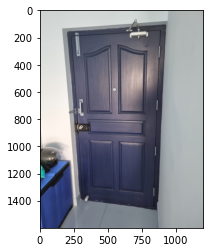

In [29]:
import base64
from PIL import Image
import io
import numpy as np
import cv2

imgdata = base64.b64decode(img_str)
# img = np.array(Image.open(io.BytesIO(imgdata)))
npimg = np.frombuffer(imgdata, np.uint8)
img = cv2.imdecode(npimg, cv2.IMREAD_COLOR)
print(type(imgdata))
print(img.shape)
import matplotlib.pyplot as plt
plt.imshow(img)
prediction_model.predict(imgdata)
# pred_model.predict(imgdata)

## Visualization (Not Tested)

Once our batch inference job is completed, let's visualize predictions. We'll use single random image for visualization. Feel free to re-run it many times.

In [ ]:
import io

import matplotlib
import matplotlib.patches as patches
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
def key_from_uri(s3_uri: str) -> str:
    """Get S3 object key from its URI"""
    return "/".join(Path(s3_uri).parts[2:])


bucket_rsr = boto3.resource("s3").Bucket(bucket)
predict_objs = list(
    bucket_rsr.objects.filter(Prefix=key_from_uri(inference_output) + "/")
)
img_objs = list(bucket_rsr.objects.filter(Prefix=key_from_uri(test_channel)))

In [ ]:
COLORS = [
    (0, 200, 0),
]


def plot_predictions_on_image(
    p_img: np.ndarray, p_preds: Mapping, score_thr: float = 0.5, show=True
) -> plt.Figure:
    r"""Plot bounding boxes predicted by an inference job on the corresponding image

    Parameters
    ----------
    p_img : np.ndarray
        input image used for prediction
    p_preds : Mapping
        dictionary with bounding boxes, predicted classes and confidence scores
    score_thr : float, optional
        show bounding boxes whose confidence score is bigger than `score_thr`, by default 0.5
    show : bool, optional
        show figure if True do not otherwise, by default True

    Returns
    -------
    plt.Figure
        figure handler

    Raises
    ------
    IOError
        If the prediction dictionary `p_preds` does not contain one of the required keys:
        `pred_classes`, `pred_boxes` and `scores`
    """
    for required_key in ("pred_classes", "pred_boxes", "scores"):
        if required_key not in p_preds:
            raise IOError(f"Missing required key: {required_key}")

    fig, fig_axis = plt.subplots(1)
    fig_axis.imshow(p_img)
    for class_id, bbox, score in zip(
        p_preds["pred_classes"], p_preds["pred_boxes"], p_preds["scores"]
    ):
        if score < score_thr:
            break  # bounding boxes are sorted by confidence score in descending order
        rect = patches.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            linewidth=1,
            edgecolor=[float(val) / 255 for val in COLORS[class_id]],
            facecolor="none",
        )
        fig_axis.add_patch(rect)
    plt.axis("off")
    if show:
        plt.show()
    return fig

In [ ]:
matplotlib.rcParams["figure.dpi"] = 300

sample_id = np.random.randint(0, len(img_objs), 1)[0]

img_obj = img_objs[sample_id]
pred_obj = predict_objs[sample_id]

img = np.asarray(Image.open(io.BytesIO(img_obj.get()["Body"].read())))
preds = json.loads(pred_obj.get()["Body"].read().decode("utf-8"))

sample_fig = plot_predictions_on_image(img, preds, 0.40, True)